# Machine Learning Techniques - ISIS4219

Segundo Semestre - 2021




## Integrantes

*   Daniel Mateo Guatibonza Solano - 201611360
*   Raquel Andrea Cerda Montañez - 201533520
*   Sergio Eduardo Cárdenas Landazabal - 201613444



## **Problema 1**

Utilice el conjunto de datos Fashion-MNIST para construir un clasificador de imágenes de productos. Para la construcción del modelo utilice los tres esquemas que se describen a continuación y compare los resultados:
<ol type="a">
  <li>Entrenamiento de un perceptrón multicapa.</li>
  <li>Entrenamiento de un encoder para realizar una reducción de la dimensionalidad. Sobre el nuevo conjunto de características construya el modelo de clasificación con un perceptrón multicapa.</li>
  <li>Entrenamiento de un denoising autoendoder para preentrenar una red profunda. Reuse las primeras capas de este autoencoder para construir un perceptrón multicapa (con solo el 10% de los datos).</li>
</ol>

Para los puntos b) y c) compruebe, y muestre con ejemplos, que las imágenes están bien reconstruidas.

## Librerías necesarias
En primer lugar, se importan todas las librerías requeridas para realizar la lectura, preprocesamiento y construcción de los modelos incluyendo las librerías requeridas para la selección de hiperparámetros.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import random

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, accuracy_score, make_scorer

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
from keras import applications

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.8.0-dev20211020


## Lectura de datos y preprocesamiento
En cuanto a la carga de datos, esta se realiza directamente a través de *keras* ya que el dataset a utilizar viene incluido con esta librería. Vale la pena indicar que este conjunto de datos viene ya con la partición del conjunto de entrenamiento y prueba.

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

Después de la carga, se normalizan las imágenes de forma que el valor de todos los píxeles se encuentre entre 0 y 1, lo que permite utilizar en los modelos como activación a la salida la función sigmoide. En cuanto al vector de las categorías a predecir, se efectúa la técnica de *one-hot encoding* dado que se cuenta con 10 clases no ordinales.

In [3]:
X_train = X_train / 255
X_test = X_test / 255

In [4]:
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

De esta forma, se valida la correcta interpretación de los datos al mostrar una de las imágenes en escala de grises junto con su respectiva clase codificada.

Etiqueta:
 0    0
1    0
2    0
3    1
4    0
5    0
6    0
7    0
8    0
9    0
Name: 28149, dtype: uint8


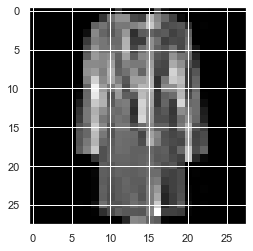

In [5]:
i = random.randint(1, X_train.shape[0])
print("Etiqueta:\n", y_train.iloc[i,:])
plt.imshow(X_train[i] , cmap = 'gray')

## Modelo 1: Entrenamiento de un perceptrón multicapa

Una vez se tienen los datos a utilizar como entrada y salida de los modelos, se parte por definir un modelo base para el caso de un clasificador compuesto exclusivamente por un perceptrón multicapa. Tal modelo se plantea con dos capas convolucionales que permitan extraer las características de las imágenes; ambas capas con un tamaño de *kernel* igual a 3, *strides* de 2 y número de filtros a la salida respectivamente de 16 y 8. Seguido a las capas convolucionales, se cuenta con una capa *Flatten* que organiza los mapas de características resultantes en un vector; con base en este, posteriormente se tiene la capa de salida de tamaño 10 de acuerdo al número de categorías del dataset. Por último, se compila el modelo especificando la función de pérdida a utilizar durante el entrenamiento (debido a que se trata de un problema de clasificación multiclase, se opta por la función de entropía cruzada categórica), el optimizador Adam y que se desea evidenciar el *accuracy*.

In [6]:
clasificador1 = Sequential(name="PerceptronMulticapa1")
clasificador1.add(Conv2D(filters=16, kernel_size=3, strides=2, padding="same", input_shape=(28, 28, 1)))
clasificador1.add(Conv2D(filters=8, kernel_size=3, strides=2, padding="same"))
clasificador1.add(Flatten())
clasificador1.add(Dense(10))
clasificador1.add(Activation('softmax'))
clasificador1.compile(loss='categorical_crossentropy',
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                      metrics=["accuracy"])
clasificador1.summary()

Model: "PerceptronMulticapa1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
 flatten (Flatten)           (None, 392)               0         
                                                                 
 dense (Dense)               (None, 10)                3930      
                                                                 
 activation (Activation)     (None, 10)                0         
                                                                 
Total params: 5,250
Trainable params: 5,250
Non-trainable params: 0
_________________________________________________________________


Adicionalmente, se define un criterio de parada del entrenamiento como un callback que realiza esto en caso de que entre 3 épocas no haya una disminución en la función de costo. 

In [7]:
early_stopping = EarlyStopping(monitor='loss', patience=3, verbose=1, mode='min', baseline=None, restore_best_weights=False)
callbacks = [early_stopping]

En este punto, se procede a realizar el entrenamiento del modelo base utilizando los datos de entrenamiento ajustados a la dimensión de entrada deseada, el criterio de parada definido, *batches* de 200 imágenes a la vez y un número máximo de épocas igual a 100. No obstante, se observa que a causa del *callback*, unicamente se entrenan 81 épocas. A partir de la exactitud que se observa sobre los datos de entrenamiento en la última iteración, se tiene un modelo con un comportamiento aceptable. Sin embargo, se procede a iterar sobre los hiperparámetros con el fin de obtener un mejor modelo.

In [8]:
clasificador1.fit(X_train.reshape(-1, 28, 28, 1), y_train, 
                    epochs=100,  batch_size=200, callbacks=callbacks)

Epoch 1/100
300/300 [==============================] - 3s 9ms/step - loss: 0.7994 - accuracy: 0.7245
Epoch 2/100
300/300 [==============================] - 3s 10ms/step - loss: 0.5258 - accuracy: 0.8148
Epoch 3/100
300/300 [==============================] - 3s 9ms/step - loss: 0.4873 - accuracy: 0.8314
Epoch 4/100
300/300 [==============================] - 3s 9ms/step - loss: 0.4678 - accuracy: 0.8368
Epoch 5/100
300/300 [==============================] - 3s 9ms/step - loss: 0.4557 - accuracy: 0.8419
Epoch 6/100
300/300 [==============================] - 3s 9ms/step - loss: 0.4465 - accuracy: 0.8454
Epoch 7/100
300/300 [==============================] - 3s 9ms/step - loss: 0.4390 - accuracy: 0.8467
Epoch 8/100
300/300 [==============================] - 3s 9ms/step - loss: 0.4344 - accuracy: 0.8492
Epoch 9/100
300/300 [==============================] - 3s 9ms/step - loss: 0.4295 - accuracy: 0.8507
Epoch 10/100
300/300 [==============================] - 3s 9ms/step - loss: 0.4259 - accur

300/300 [==============================] - 3s 9ms/step - loss: 0.3739 - accuracy: 0.8682
Epoch 00081: early stopping


Para lo anterior, se define una función en la que se plantean modelos que pueden o no contar con una capa densa entre las capas convolucionales y la capa de salida de la cual se puede iterar sobre el número de neuronas así como de su función de activación. En el caso en el que no se maneja tal capa intermedia, el número de capas de convolución puede variarse de uno a dos y se modifican el tamaño del filtro y el número de *strides* que manejan. De igual manera, se define el objeto de *sklearn* a partir de la clase *KerasClassifier* que permitirá efectuar la búsqueda de hiperparámetros.

In [9]:
def crear_clasificador1(fil1 = 16, fil2 = 8, nn3 = 25, n_layers= 3, ks=3, s=2, activacion_oculta = 'relu'):
    clasificador1 = Sequential(name="PerceptronMulticapa1")
    output = 10
    for i in range(n_layers):
        if i == 0:
            clasificador1.add(Conv2D(filters=fil1, kernel_size=ks, strides=s, padding="same", input_shape=(28, 28, 1)))
        elif i == 1:
            clasificador1.add(Conv2D(filters=fil1, kernel_size=ks, strides=s, padding="same"))
        elif i == 2:
            clasificador1.add(Dense(nn3, activation=activacion_oculta))
    clasificador1.add(Flatten()) 
    clasificador1.add(Dense(output, activation='softmax', name= 'Capa_Salida'))
    clasificador1.compile(loss='categorical_crossentropy',
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                      metrics=["accuracy"])
    return clasificador1

# Modelo que utiliza el GridSearch
modelo1_CV = KerasClassifier(build_fn=crear_clasificador1, epochs=100, verbose=1, shuffle=True)

Ahora se define el pipeline y los valores de los hiperparámetros sobre los que se iterará así como la función que se desea mejorar entre modelos, en esta ocasión el *accuracy*. Después de esto, se define que la validación cruzada estará compuesta por tres particiones y que el número de modelos que aleatoriamente se desean evaluar corresponden a 25.

In [10]:
pipe1 = Pipeline([('red_neuronal', modelo1_CV)])

param_grid = dict(red_neuronal__fil1 = [20, 16, 12],
                  red_neuronal__fil2 = [10, 8, 6],
                  red_neuronal__nn3 = [12, 8, 4],
                  red_neuronal__n_layers = [1, 2, 3],
                  red_neuronal__ks = [3, 5, 7],
                  red_neuronal__s = [2, 3, 4],
                  red_neuronal__activacion_oculta = ['relu','sigmoid'])

def my_custom_acc(y_true, y_pred):
    return accuracy_score(y_true.argmax(axis=-1), y_pred)

score = make_scorer(my_custom_acc, greater_is_better=True)
grid1 = RandomizedSearchCV(pipe1, param_grid, scoring=score, verbose=1, cv=3, n_iter=25, random_state=0)

Con base en esto, se procede a entrenar los 75 modelos (25 modelos x 3 particiones de validación) haciendo uso de nuevo del callback que permite detener la ejecución temprana de forma que este proceso no tome un tiempo exorbitante.

In [11]:
grid1.fit(X_train.reshape(-1, 28, 28, 1), y_train, red_neuronal__batch_size=200, red_neuronal__callbacks=callbacks)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Epoch 1/100
200/200 [==============================] - 1s 5ms/step - loss: 0.7166 - accuracy: 0.7566
Epoch 2/100
200/200 [==============================] - 1s 5ms/step - loss: 0.4835 - accuracy: 0.8321
Epoch 3/100
200/200 [==============================] - 1s 5ms/step - loss: 0.4541 - accuracy: 0.8432
Epoch 4/100
200/200 [==============================] - 1s 5ms/step - loss: 0.4372 - accuracy: 0.8494
Epoch 5/100
200/200 [==============================] - 1s 5ms/step - loss: 0.4270 - accuracy: 0.8529
Epoch 6/100
200/200 [==============================] - 1s 5ms/step - loss: 0.4145 - accuracy: 0.8583
Epoch 7/100
200/200 [==============================] - 1s 5ms/step - loss: 0.4109 - accuracy: 0.8578
Epoch 8/100
200/200 [==============================] - 1s 5ms/step - loss: 0.4024 - accuracy: 0.8611
Epoch 9/100
200/200 [==============================] - ETA: 0s - loss: 0.4010 - accuracy: 0.86 - 1s 5ms/step - loss: 0.4004 - accur

200/200 [==============================] - 1s 5ms/step - loss: 0.3240 - accuracy: 0.8857
Epoch 81/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3242 - accuracy: 0.8852
Epoch 82/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3244 - accuracy: 0.8854
Epoch 83/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3239 - accuracy: 0.8858
Epoch 84/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3250 - accuracy: 0.8853
Epoch 85/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3235 - accuracy: 0.8850
Epoch 86/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3227 - accuracy: 0.8863
Epoch 87/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3228 - accuracy: 0.8871
Epoch 88/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3232 - accuracy: 0.8857
Epoch 89/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3233 - accuracy: 

200/200 [==============================] - 1s 5ms/step - loss: 0.3287 - accuracy: 0.8824
Epoch 71/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3280 - accuracy: 0.8822
Epoch 72/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3294 - accuracy: 0.8819
Epoch 73/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3273 - accuracy: 0.8826
Epoch 74/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3289 - accuracy: 0.8814
Epoch 75/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3276 - accuracy: 0.8819
Epoch 76/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3274 - accuracy: 0.8815
Epoch 00076: early stopping
Epoch 1/100
200/200 [==============================] - 1s 5ms/step - loss: 0.7172 - accuracy: 0.7588
Epoch 2/100
200/200 [==============================] - 1s 5ms/step - loss: 0.4815 - accuracy: 0.8333
Epoch 3/100
200/200 [==============================] - 1s 5ms/step - 

Epoch 2/100
200/200 [==============================] - 2s 9ms/step - loss: 0.5819 - accuracy: 0.7930
Epoch 3/100
200/200 [==============================] - 2s 10ms/step - loss: 0.5167 - accuracy: 0.8177
Epoch 4/100
200/200 [==============================] - 2s 9ms/step - loss: 0.4822 - accuracy: 0.8286
Epoch 5/100
200/200 [==============================] - 2s 9ms/step - loss: 0.4597 - accuracy: 0.8394
Epoch 6/100
200/200 [==============================] - 2s 9ms/step - loss: 0.4423 - accuracy: 0.8447
Epoch 7/100
200/200 [==============================] - 2s 9ms/step - loss: 0.4265 - accuracy: 0.8494
Epoch 8/100
200/200 [==============================] - 2s 9ms/step - loss: 0.4172 - accuracy: 0.8529
Epoch 9/100
200/200 [==============================] - 2s 9ms/step - loss: 0.4073 - accuracy: 0.8569
Epoch 10/100
200/200 [==============================] - 2s 10ms/step - loss: 0.4004 - accuracy: 0.8598
Epoch 11/100
200/200 [==============================] - 2s 9ms/step - loss: 0.3917 - acc

200/200 [==============================] - 2s 10ms/step - loss: 0.5271 - accuracy: 0.8111
Epoch 4/100
200/200 [==============================] - 2s 10ms/step - loss: 0.4946 - accuracy: 0.8238
Epoch 5/100
200/200 [==============================] - 2s 10ms/step - loss: 0.4714 - accuracy: 0.8335
Epoch 6/100
200/200 [==============================] - 2s 10ms/step - loss: 0.4576 - accuracy: 0.8380
Epoch 7/100
200/200 [==============================] - 2s 10ms/step - loss: 0.4392 - accuracy: 0.8442
Epoch 8/100
200/200 [==============================] - 2s 10ms/step - loss: 0.4272 - accuracy: 0.8492
Epoch 9/100
200/200 [==============================] - 2s 10ms/step - loss: 0.4181 - accuracy: 0.8522
Epoch 10/100
200/200 [==============================] - 2s 9ms/step - loss: 0.4134 - accuracy: 0.8546
Epoch 11/100
200/200 [==============================] - 2s 9ms/step - loss: 0.4032 - accuracy: 0.8567
Epoch 12/100
200/200 [==============================] - 2s 9ms/step - loss: 0.3980 - accuracy:

200/200 [==============================] - 2s 9ms/step - loss: 0.3668 - accuracy: 0.8689
Epoch 14/100
200/200 [==============================] - 2s 9ms/step - loss: 0.3623 - accuracy: 0.8702
Epoch 15/100
200/200 [==============================] - 2s 9ms/step - loss: 0.3573 - accuracy: 0.8721
Epoch 16/100
200/200 [==============================] - 2s 9ms/step - loss: 0.3534 - accuracy: 0.8743
Epoch 17/100
200/200 [==============================] - 2s 9ms/step - loss: 0.3499 - accuracy: 0.8737
Epoch 18/100
200/200 [==============================] - 2s 9ms/step - loss: 0.3471 - accuracy: 0.8750
Epoch 19/100
200/200 [==============================] - 2s 9ms/step - loss: 0.3454 - accuracy: 0.8752
Epoch 20/100
200/200 [==============================] - 2s 9ms/step - loss: 0.3398 - accuracy: 0.8784
Epoch 21/100
200/200 [==============================] - 2s 9ms/step - loss: 0.3380 - accuracy: 0.8789
Epoch 22/100
200/200 [==============================] - 2s 9ms/step - loss: 0.3352 - accuracy: 

200/200 [==============================] - 2s 9ms/step - loss: 0.2753 - accuracy: 0.9006
Epoch 31/100
200/200 [==============================] - 2s 9ms/step - loss: 0.2719 - accuracy: 0.9024
Epoch 32/100
200/200 [==============================] - 2s 9ms/step - loss: 0.2699 - accuracy: 0.9029
Epoch 33/100
200/200 [==============================] - 2s 9ms/step - loss: 0.2689 - accuracy: 0.9037
Epoch 34/100
200/200 [==============================] - 2s 9ms/step - loss: 0.2664 - accuracy: 0.9036
Epoch 35/100
200/200 [==============================] - 2s 9ms/step - loss: 0.2652 - accuracy: 0.9038
Epoch 36/100
200/200 [==============================] - 2s 9ms/step - loss: 0.2639 - accuracy: 0.9050
Epoch 37/100
200/200 [==============================] - 2s 9ms/step - loss: 0.2606 - accuracy: 0.9051
Epoch 38/100
200/200 [==============================] - 2s 9ms/step - loss: 0.2600 - accuracy: 0.9047
Epoch 39/100
200/200 [==============================] - 2s 9ms/step - loss: 0.2602 - accuracy: 

200/200 [==============================] - 2s 9ms/step - loss: 0.2470 - accuracy: 0.9103
Epoch 52/100
200/200 [==============================] - 2s 9ms/step - loss: 0.2452 - accuracy: 0.9108
Epoch 53/100
200/200 [==============================] - 2s 9ms/step - loss: 0.2454 - accuracy: 0.9107
Epoch 54/100
200/200 [==============================] - 2s 9ms/step - loss: 0.2417 - accuracy: 0.9117
Epoch 55/100
200/200 [==============================] - 2s 9ms/step - loss: 0.2419 - accuracy: 0.9114
Epoch 56/100
200/200 [==============================] - 2s 9ms/step - loss: 0.2431 - accuracy: 0.9116
Epoch 57/100
200/200 [==============================] - 2s 9ms/step - loss: 0.2390 - accuracy: 0.9136
Epoch 58/100
200/200 [==============================] - 2s 9ms/step - loss: 0.2393 - accuracy: 0.9122
Epoch 59/100
200/200 [==============================] - 2s 9ms/step - loss: 0.2384 - accuracy: 0.9137
Epoch 60/100
200/200 [==============================] - 2s 9ms/step - loss: 0.2374 - accuracy: 

200/200 [==============================] - 2s 9ms/step - loss: 0.2715 - accuracy: 0.8998
Epoch 33/100
200/200 [==============================] - 2s 9ms/step - loss: 0.2702 - accuracy: 0.9007
Epoch 34/100
200/200 [==============================] - 2s 9ms/step - loss: 0.2669 - accuracy: 0.9023
Epoch 35/100
200/200 [==============================] - 2s 9ms/step - loss: 0.2658 - accuracy: 0.9029
Epoch 36/100
200/200 [==============================] - 2s 9ms/step - loss: 0.2637 - accuracy: 0.9031
Epoch 37/100
200/200 [==============================] - 2s 9ms/step - loss: 0.2616 - accuracy: 0.9036
Epoch 38/100
200/200 [==============================] - 2s 9ms/step - loss: 0.2609 - accuracy: 0.9042
Epoch 39/100
200/200 [==============================] - 2s 9ms/step - loss: 0.2609 - accuracy: 0.9041
Epoch 40/100
200/200 [==============================] - 2s 9ms/step - loss: 0.2566 - accuracy: 0.9059
Epoch 41/100
200/200 [==============================] - 2s 9ms/step - loss: 0.2559 - accuracy: 

200/200 [==============================] - 2s 9ms/step - loss: 0.3635 - accuracy: 0.8730
Epoch 24/100
200/200 [==============================] - 2s 9ms/step - loss: 0.3601 - accuracy: 0.8747
Epoch 25/100
200/200 [==============================] - 2s 9ms/step - loss: 0.3592 - accuracy: 0.8744
Epoch 26/100
200/200 [==============================] - 2s 9ms/step - loss: 0.3578 - accuracy: 0.8745
Epoch 27/100
200/200 [==============================] - 2s 9ms/step - loss: 0.3576 - accuracy: 0.8745
Epoch 28/100
200/200 [==============================] - 2s 9ms/step - loss: 0.3541 - accuracy: 0.8769
Epoch 29/100
200/200 [==============================] - 2s 9ms/step - loss: 0.3550 - accuracy: 0.8763
Epoch 30/100
200/200 [==============================] - 2s 9ms/step - loss: 0.3517 - accuracy: 0.8769
Epoch 31/100
200/200 [==============================] - 2s 10ms/step - loss: 0.3522 - accuracy: 0.8771
Epoch 32/100
200/200 [==============================] - 2s 9ms/step - loss: 0.3511 - accuracy:

200/200 [==============================] - 2s 9ms/step - loss: 0.4343 - accuracy: 0.8495
Epoch 5/100
200/200 [==============================] - 2s 9ms/step - loss: 0.4231 - accuracy: 0.8549
Epoch 6/100
200/200 [==============================] - 2s 9ms/step - loss: 0.4155 - accuracy: 0.8569
Epoch 7/100
200/200 [==============================] - 2s 9ms/step - loss: 0.4115 - accuracy: 0.8571
Epoch 8/100
200/200 [==============================] - 2s 9ms/step - loss: 0.4040 - accuracy: 0.8603
Epoch 9/100
200/200 [==============================] - 2s 9ms/step - loss: 0.4001 - accuracy: 0.8619
Epoch 10/100
200/200 [==============================] - 2s 9ms/step - loss: 0.3978 - accuracy: 0.8622
Epoch 11/100
200/200 [==============================] - 2s 9ms/step - loss: 0.3941 - accuracy: 0.8626
Epoch 12/100
200/200 [==============================] - 2s 9ms/step - loss: 0.3906 - accuracy: 0.8642
Epoch 13/100
200/200 [==============================] - 2s 9ms/step - loss: 0.3891 - accuracy: 0.864

200/200 [==============================] - 7s 33ms/step - loss: 0.5248 - accuracy: 0.8141
Epoch 3/100
200/200 [==============================] - 7s 33ms/step - loss: 0.4695 - accuracy: 0.8369
Epoch 4/100
200/200 [==============================] - 7s 33ms/step - loss: 0.4400 - accuracy: 0.8479
Epoch 5/100
200/200 [==============================] - 7s 33ms/step - loss: 0.4238 - accuracy: 0.8531
Epoch 6/100
200/200 [==============================] - 7s 33ms/step - loss: 0.4109 - accuracy: 0.8586
Epoch 7/100
200/200 [==============================] - 7s 33ms/step - loss: 0.4008 - accuracy: 0.8617
Epoch 8/100
200/200 [==============================] - 7s 33ms/step - loss: 0.3896 - accuracy: 0.8645
Epoch 9/100
200/200 [==============================] - 7s 33ms/step - loss: 0.3841 - accuracy: 0.8650
Epoch 10/100
200/200 [==============================] - 7s 34ms/step - loss: 0.3752 - accuracy: 0.8679
Epoch 11/100
200/200 [==============================] - 7s 35ms/step - loss: 0.3727 - accurac

200/200 [==============================] - 7s 33ms/step - loss: 0.2628 - accuracy: 0.9046
Epoch 82/100
200/200 [==============================] - 7s 33ms/step - loss: 0.2622 - accuracy: 0.9045
Epoch 83/100
200/200 [==============================] - 7s 33ms/step - loss: 0.2623 - accuracy: 0.9058
Epoch 84/100
200/200 [==============================] - 7s 33ms/step - loss: 0.2620 - accuracy: 0.9051
Epoch 85/100
200/200 [==============================] - 7s 33ms/step - loss: 0.2607 - accuracy: 0.9057
Epoch 86/100
200/200 [==============================] - 7s 33ms/step - loss: 0.2613 - accuracy: 0.9053
Epoch 87/100
200/200 [==============================] - 7s 33ms/step - loss: 0.2607 - accuracy: 0.9045
Epoch 88/100
200/200 [==============================] - 7s 33ms/step - loss: 0.2599 - accuracy: 0.9059
Epoch 89/100
200/200 [==============================] - 7s 33ms/step - loss: 0.2613 - accuracy: 0.9061
Epoch 90/100
200/200 [==============================] - 7s 33ms/step - loss: 0.2595 - 

200/200 [==============================] - 7s 33ms/step - loss: 0.2733 - accuracy: 0.9003
Epoch 61/100
200/200 [==============================] - 7s 33ms/step - loss: 0.2739 - accuracy: 0.8999
Epoch 62/100
200/200 [==============================] - 6s 32ms/step - loss: 0.2746 - accuracy: 0.8992
Epoch 63/100
200/200 [==============================] - 7s 33ms/step - loss: 0.2726 - accuracy: 0.9000
Epoch 64/100
200/200 [==============================] - 7s 33ms/step - loss: 0.2714 - accuracy: 0.9008
Epoch 65/100
200/200 [==============================] - 7s 33ms/step - loss: 0.2732 - accuracy: 0.8992
Epoch 66/100
200/200 [==============================] - 6s 32ms/step - loss: 0.2723 - accuracy: 0.8995
Epoch 67/100
200/200 [==============================] - 6s 32ms/step - loss: 0.2711 - accuracy: 0.9002
Epoch 68/100
200/200 [==============================] - 7s 32ms/step - loss: 0.2680 - accuracy: 0.9023
Epoch 69/100
200/200 [==============================] - 6s 32ms/step - loss: 0.2683 - 

200/200 [==============================] - 7s 33ms/step - loss: 0.2774 - accuracy: 0.8996
Epoch 69/100
200/200 [==============================] - 6s 32ms/step - loss: 0.2742 - accuracy: 0.9007
Epoch 70/100
200/200 [==============================] - 6s 32ms/step - loss: 0.2736 - accuracy: 0.9000
Epoch 71/100
200/200 [==============================] - 6s 32ms/step - loss: 0.2743 - accuracy: 0.9001
Epoch 72/100
200/200 [==============================] - 6s 32ms/step - loss: 0.2733 - accuracy: 0.9008
Epoch 73/100
200/200 [==============================] - 6s 32ms/step - loss: 0.2745 - accuracy: 0.9011
Epoch 74/100
200/200 [==============================] - 7s 33ms/step - loss: 0.2735 - accuracy: 0.9000
Epoch 75/100
200/200 [==============================] - 7s 34ms/step - loss: 0.2716 - accuracy: 0.9008
Epoch 76/100
200/200 [==============================] - 7s 33ms/step - loss: 0.2705 - accuracy: 0.9007
Epoch 77/100
200/200 [==============================] - 6s 32ms/step - loss: 0.2697 - 

200/200 [==============================] - 5s 27ms/step - loss: 0.2555 - accuracy: 0.9095
Epoch 48/100
200/200 [==============================] - 5s 27ms/step - loss: 0.2553 - accuracy: 0.9085
Epoch 49/100
200/200 [==============================] - 5s 27ms/step - loss: 0.2541 - accuracy: 0.9091
Epoch 50/100
200/200 [==============================] - 5s 27ms/step - loss: 0.2538 - accuracy: 0.9097
Epoch 51/100
200/200 [==============================] - 5s 27ms/step - loss: 0.2520 - accuracy: 0.9103
Epoch 52/100
200/200 [==============================] - 5s 27ms/step - loss: 0.2508 - accuracy: 0.9096
Epoch 53/100
200/200 [==============================] - 5s 27ms/step - loss: 0.2490 - accuracy: 0.9110
Epoch 54/100
200/200 [==============================] - 5s 27ms/step - loss: 0.2484 - accuracy: 0.9108
Epoch 55/100
200/200 [==============================] - 5s 27ms/step - loss: 0.2474 - accuracy: 0.9109
Epoch 56/100
200/200 [==============================] - 5s 27ms/step - loss: 0.2468 - 

200/200 [==============================] - 5s 27ms/step - loss: 0.2918 - accuracy: 0.8942
Epoch 27/100
200/200 [==============================] - 5s 27ms/step - loss: 0.2900 - accuracy: 0.8954
Epoch 28/100
200/200 [==============================] - 5s 27ms/step - loss: 0.2883 - accuracy: 0.8958
Epoch 29/100
200/200 [==============================] - 5s 27ms/step - loss: 0.2860 - accuracy: 0.8968
Epoch 30/100
200/200 [==============================] - 5s 27ms/step - loss: 0.2836 - accuracy: 0.8974
Epoch 31/100
200/200 [==============================] - 5s 27ms/step - loss: 0.2805 - accuracy: 0.8977
Epoch 32/100
200/200 [==============================] - 5s 27ms/step - loss: 0.2806 - accuracy: 0.8968
Epoch 33/100
200/200 [==============================] - 5s 27ms/step - loss: 0.2770 - accuracy: 0.8994
Epoch 34/100
200/200 [==============================] - 5s 27ms/step - loss: 0.2754 - accuracy: 0.8998
Epoch 35/100
200/200 [==============================] - 5s 27ms/step - loss: 0.2741 - 

200/200 [==============================] - 5s 26ms/step - loss: 0.4130 - accuracy: 0.8539
Epoch 6/100
200/200 [==============================] - 5s 27ms/step - loss: 0.3975 - accuracy: 0.8597
Epoch 7/100
200/200 [==============================] - 5s 26ms/step - loss: 0.3835 - accuracy: 0.8637
Epoch 8/100
200/200 [==============================] - 5s 26ms/step - loss: 0.3729 - accuracy: 0.8677
Epoch 9/100
200/200 [==============================] - 5s 26ms/step - loss: 0.3648 - accuracy: 0.8709
Epoch 10/100
200/200 [==============================] - 5s 26ms/step - loss: 0.3559 - accuracy: 0.8739
Epoch 11/100
200/200 [==============================] - 5s 26ms/step - loss: 0.3483 - accuracy: 0.8766
Epoch 12/100
200/200 [==============================] - 5s 26ms/step - loss: 0.3416 - accuracy: 0.8781
Epoch 13/100
200/200 [==============================] - 5s 26ms/step - loss: 0.3376 - accuracy: 0.8794
Epoch 14/100
200/200 [==============================] - 5s 26ms/step - loss: 0.3300 - accu

200/200 [==============================] - 5s 27ms/step - loss: 0.2090 - accuracy: 0.9247
Epoch 85/100
200/200 [==============================] - 5s 27ms/step - loss: 0.2095 - accuracy: 0.9251
Epoch 86/100
200/200 [==============================] - 5s 26ms/step - loss: 0.2093 - accuracy: 0.9243
Epoch 87/100
200/200 [==============================] - 5s 27ms/step - loss: 0.2086 - accuracy: 0.9260
Epoch 88/100
200/200 [==============================] - 5s 27ms/step - loss: 0.2063 - accuracy: 0.9263
Epoch 89/100
200/200 [==============================] - 5s 27ms/step - loss: 0.2065 - accuracy: 0.9261
Epoch 90/100
200/200 [==============================] - 5s 26ms/step - loss: 0.2046 - accuracy: 0.9265
Epoch 91/100
200/200 [==============================] - 5s 26ms/step - loss: 0.2051 - accuracy: 0.9270
Epoch 92/100
200/200 [==============================] - 5s 27ms/step - loss: 0.2059 - accuracy: 0.9255
Epoch 93/100
200/200 [==============================] - 5s 26ms/step - loss: 0.2055 - 

200/200 [==============================] - 1s 4ms/step - loss: 0.4609 - accuracy: 0.8392
Epoch 4/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4463 - accuracy: 0.8442
Epoch 5/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4330 - accuracy: 0.8496
Epoch 6/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4239 - accuracy: 0.8516
Epoch 7/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4198 - accuracy: 0.8533
Epoch 8/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4133 - accuracy: 0.8561
Epoch 9/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4095 - accuracy: 0.8557
Epoch 10/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4069 - accuracy: 0.8571
Epoch 11/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4051 - accuracy: 0.8581
Epoch 12/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4017 - accuracy: 0.8579

200/200 [==============================] - 1s 4ms/step - loss: 0.3715 - accuracy: 0.8695
Epoch 31/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3688 - accuracy: 0.8710
Epoch 32/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3680 - accuracy: 0.8711
Epoch 33/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3670 - accuracy: 0.8707
Epoch 34/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3667 - accuracy: 0.8712
Epoch 35/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3647 - accuracy: 0.8731
Epoch 36/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3650 - accuracy: 0.8719
Epoch 37/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3620 - accuracy: 0.8721
Epoch 38/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3631 - accuracy: 0.8728
Epoch 39/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3617 - accuracy: 

200/200 [==============================] - 1s 6ms/step - loss: 0.4017 - accuracy: 0.8613
Epoch 20/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3977 - accuracy: 0.8625
Epoch 21/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3959 - accuracy: 0.8631
Epoch 22/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3935 - accuracy: 0.8639
Epoch 23/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3932 - accuracy: 0.8642
Epoch 24/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3901 - accuracy: 0.8648
Epoch 25/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3875 - accuracy: 0.8662
Epoch 26/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3873 - accuracy: 0.8659
Epoch 27/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3861 - accuracy: 0.8662
Epoch 28/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3846 - accuracy: 

200/200 [==============================] - 1s 6ms/step - loss: 0.3833 - accuracy: 0.8641
Epoch 32/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3829 - accuracy: 0.8647
Epoch 33/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3825 - accuracy: 0.8651
Epoch 34/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3810 - accuracy: 0.8661
Epoch 35/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3791 - accuracy: 0.8652
Epoch 36/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3803 - accuracy: 0.8657
Epoch 37/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3783 - accuracy: 0.8652
Epoch 38/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3772 - accuracy: 0.8663
Epoch 39/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3754 - accuracy: 0.8669
Epoch 40/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3745 - accuracy: 

200/200 [==============================] - 1s 6ms/step - loss: 0.3977 - accuracy: 0.8616
Epoch 23/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3938 - accuracy: 0.8629
Epoch 24/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3938 - accuracy: 0.8626
Epoch 25/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3907 - accuracy: 0.8638
Epoch 26/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3893 - accuracy: 0.8642
Epoch 27/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3878 - accuracy: 0.8645
Epoch 28/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3875 - accuracy: 0.8654
Epoch 29/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3863 - accuracy: 0.8646
Epoch 30/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3848 - accuracy: 0.8658
Epoch 31/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3841 - accuracy: 

200/200 [==============================] - 1s 3ms/step - loss: 0.5980 - accuracy: 0.7857
Epoch 8/100
200/200 [==============================] - 1s 3ms/step - loss: 0.5907 - accuracy: 0.7878
Epoch 9/100
200/200 [==============================] - 1s 3ms/step - loss: 0.5840 - accuracy: 0.7926
Epoch 10/100
200/200 [==============================] - 1s 3ms/step - loss: 0.5762 - accuracy: 0.7954
Epoch 11/100
200/200 [==============================] - 1s 3ms/step - loss: 0.5718 - accuracy: 0.7973
Epoch 12/100
200/200 [==============================] - 1s 3ms/step - loss: 0.5667 - accuracy: 0.7973
Epoch 13/100
200/200 [==============================] - 1s 3ms/step - loss: 0.5630 - accuracy: 0.7991
Epoch 14/100
200/200 [==============================] - 1s 3ms/step - loss: 0.5589 - accuracy: 0.8009
Epoch 15/100
200/200 [==============================] - 1s 3ms/step - loss: 0.5577 - accuracy: 0.8012
Epoch 16/100
200/200 [==============================] - 1s 3ms/step - loss: 0.5529 - accuracy: 0.

200/200 [==============================] - 1s 3ms/step - loss: 0.5039 - accuracy: 0.8203
Epoch 88/100
200/200 [==============================] - 1s 3ms/step - loss: 0.5036 - accuracy: 0.8194
Epoch 89/100
200/200 [==============================] - 1s 3ms/step - loss: 0.5042 - accuracy: 0.8199
Epoch 90/100
200/200 [==============================] - 1s 3ms/step - loss: 0.5047 - accuracy: 0.8191
Epoch 91/100
200/200 [==============================] - 1s 3ms/step - loss: 0.5036 - accuracy: 0.8194
Epoch 92/100
200/200 [==============================] - 1s 3ms/step - loss: 0.5040 - accuracy: 0.8204
Epoch 93/100
200/200 [==============================] - 1s 3ms/step - loss: 0.5027 - accuracy: 0.8200
Epoch 94/100
200/200 [==============================] - 1s 3ms/step - loss: 0.5023 - accuracy: 0.8205
Epoch 95/100
200/200 [==============================] - 1s 3ms/step - loss: 0.5022 - accuracy: 0.8208
Epoch 96/100
200/200 [==============================] - 1s 3ms/step - loss: 0.5027 - accuracy: 

200/200 [==============================] - 1s 3ms/step - loss: 0.5107 - accuracy: 0.8202
Epoch 70/100
200/200 [==============================] - 1s 3ms/step - loss: 0.5089 - accuracy: 0.8201
Epoch 71/100
200/200 [==============================] - 1s 3ms/step - loss: 0.5079 - accuracy: 0.8210
Epoch 72/100
200/200 [==============================] - 1s 3ms/step - loss: 0.5089 - accuracy: 0.8217
Epoch 73/100
200/200 [==============================] - 1s 3ms/step - loss: 0.5093 - accuracy: 0.8214
Epoch 74/100
200/200 [==============================] - 1s 3ms/step - loss: 0.5089 - accuracy: 0.8194
Epoch 00074: early stopping
Epoch 1/100
200/200 [==============================] - 2s 10ms/step - loss: 0.8329 - accuracy: 0.7121 0s - loss: 0.8387 - accuracy: 0.71
Epoch 2/100
200/200 [==============================] - 2s 10ms/step - loss: 0.5264 - accuracy: 0.8166
Epoch 3/100
200/200 [==============================] - 2s 10ms/step - loss: 0.4878 - accuracy: 0.8315
Epoch 4/100
200/200 [===========

200/200 [==============================] - 2s 10ms/step - loss: 0.3578 - accuracy: 0.8751
Epoch 74/100
200/200 [==============================] - 2s 10ms/step - loss: 0.3582 - accuracy: 0.8740
Epoch 75/100
200/200 [==============================] - 2s 10ms/step - loss: 0.3564 - accuracy: 0.8752
Epoch 76/100
200/200 [==============================] - 2s 10ms/step - loss: 0.3569 - accuracy: 0.8748
Epoch 77/100
200/200 [==============================] - 2s 10ms/step - loss: 0.3561 - accuracy: 0.8763
Epoch 78/100
200/200 [==============================] - 2s 10ms/step - loss: 0.3565 - accuracy: 0.8751
Epoch 79/100
200/200 [==============================] - 2s 10ms/step - loss: 0.3552 - accuracy: 0.8756
Epoch 80/100
200/200 [==============================] - 2s 10ms/step - loss: 0.3547 - accuracy: 0.8758
Epoch 81/100
200/200 [==============================] - 2s 10ms/step - loss: 0.3540 - accuracy: 0.8765
Epoch 82/100
200/200 [==============================] - 2s 10ms/step - loss: 0.3540 - 

200/200 [==============================] - 2s 10ms/step - loss: 0.3647 - accuracy: 0.8703
Epoch 60/100
200/200 [==============================] - 2s 10ms/step - loss: 0.3653 - accuracy: 0.8690
Epoch 61/100
200/200 [==============================] - 2s 10ms/step - loss: 0.3657 - accuracy: 0.8703
Epoch 62/100
200/200 [==============================] - 2s 10ms/step - loss: 0.3630 - accuracy: 0.8700
Epoch 63/100
200/200 [==============================] - 2s 10ms/step - loss: 0.3647 - accuracy: 0.8698
Epoch 64/100
200/200 [==============================] - 2s 10ms/step - loss: 0.3632 - accuracy: 0.8715
Epoch 65/100
200/200 [==============================] - 2s 10ms/step - loss: 0.3633 - accuracy: 0.8707
Epoch 00065: early stopping
Epoch 1/100
200/200 [==============================] - 2s 10ms/step - loss: 0.8363 - accuracy: 0.7197
Epoch 2/100
200/200 [==============================] - 2s 10ms/step - loss: 0.5296 - accuracy: 0.8130
Epoch 3/100
200/200 [==============================] - 2s 10

200/200 [==============================] - 1s 3ms/step - loss: 0.4172 - accuracy: 0.8567
Epoch 12/100
200/200 [==============================] - 1s 3ms/step - loss: 0.4136 - accuracy: 0.8576
Epoch 13/100
200/200 [==============================] - 1s 3ms/step - loss: 0.4093 - accuracy: 0.8589
Epoch 14/100
200/200 [==============================] - 1s 3ms/step - loss: 0.4066 - accuracy: 0.8606
Epoch 15/100
200/200 [==============================] - 1s 3ms/step - loss: 0.4055 - accuracy: 0.8604
Epoch 16/100
200/200 [==============================] - 1s 3ms/step - loss: 0.4029 - accuracy: 0.8608
Epoch 17/100
200/200 [==============================] - 1s 3ms/step - loss: 0.4002 - accuracy: 0.8625
Epoch 18/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3985 - accuracy: 0.8632
Epoch 19/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3990 - accuracy: 0.8632
Epoch 20/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3941 - accuracy: 

200/200 [==============================] - 1s 3ms/step - loss: 0.4362 - accuracy: 0.8477
Epoch 9/100
200/200 [==============================] - 1s 3ms/step - loss: 0.4302 - accuracy: 0.8486
Epoch 10/100
200/200 [==============================] - 1s 3ms/step - loss: 0.4260 - accuracy: 0.8507
Epoch 11/100
200/200 [==============================] - 1s 3ms/step - loss: 0.4213 - accuracy: 0.8518
Epoch 12/100
200/200 [==============================] - 1s 3ms/step - loss: 0.4203 - accuracy: 0.8528
Epoch 13/100
200/200 [==============================] - 1s 3ms/step - loss: 0.4160 - accuracy: 0.8543
Epoch 14/100
200/200 [==============================] - 1s 3ms/step - loss: 0.4106 - accuracy: 0.8564
Epoch 15/100
200/200 [==============================] - 1s 3ms/step - loss: 0.4101 - accuracy: 0.8557
Epoch 16/100
200/200 [==============================] - 1s 3ms/step - loss: 0.4078 - accuracy: 0.8572
Epoch 17/100
200/200 [==============================] - 1s 3ms/step - loss: 0.4058 - accuracy: 0

200/200 [==============================] - 1s 3ms/step - loss: 0.3449 - accuracy: 0.8753
Epoch 89/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3443 - accuracy: 0.8765
Epoch 90/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3446 - accuracy: 0.8764
Epoch 91/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3442 - accuracy: 0.8764
Epoch 92/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3425 - accuracy: 0.8779
Epoch 93/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3423 - accuracy: 0.8770
Epoch 94/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3430 - accuracy: 0.8767
Epoch 95/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3417 - accuracy: 0.8785
Epoch 96/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3418 - accuracy: 0.8773
Epoch 97/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3409 - accuracy: 

200/200 [==============================] - 1s 3ms/step - loss: 0.3554 - accuracy: 0.8747
Epoch 68/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3540 - accuracy: 0.8753
Epoch 69/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3536 - accuracy: 0.8760
Epoch 70/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3538 - accuracy: 0.8758
Epoch 71/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3521 - accuracy: 0.8767
Epoch 72/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3510 - accuracy: 0.8768
Epoch 73/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3523 - accuracy: 0.8756
Epoch 74/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3516 - accuracy: 0.8765
Epoch 75/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3507 - accuracy: 0.8767
Epoch 76/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3505 - accuracy: 

200/200 [==============================] - 1s 5ms/step - loss: 0.3509 - accuracy: 0.8768
Epoch 48/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3476 - accuracy: 0.8783
Epoch 49/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3480 - accuracy: 0.8780
Epoch 50/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3485 - accuracy: 0.8778
Epoch 51/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3470 - accuracy: 0.8777
Epoch 52/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3470 - accuracy: 0.8778
Epoch 53/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3460 - accuracy: 0.8777
Epoch 54/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3463 - accuracy: 0.8789
Epoch 55/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3462 - accuracy: 0.8790
Epoch 56/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3428 - accuracy: 

200/200 [==============================] - 1s 5ms/step - loss: 0.3633 - accuracy: 0.8698
Epoch 35/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3608 - accuracy: 0.8709
Epoch 36/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3625 - accuracy: 0.8699
Epoch 37/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3594 - accuracy: 0.8718
Epoch 38/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3598 - accuracy: 0.8719
Epoch 39/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3576 - accuracy: 0.8726
Epoch 40/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3590 - accuracy: 0.8717
Epoch 41/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3552 - accuracy: 0.8735
Epoch 42/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3555 - accuracy: 0.8733
Epoch 43/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3534 - accuracy: 

200/200 [==============================] - 1s 5ms/step - loss: 0.3857 - accuracy: 0.8641
Epoch 19/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3843 - accuracy: 0.8657
Epoch 20/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3840 - accuracy: 0.8659
Epoch 21/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3801 - accuracy: 0.8656
Epoch 22/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3786 - accuracy: 0.8665
Epoch 23/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3785 - accuracy: 0.8682
Epoch 24/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3743 - accuracy: 0.8684
Epoch 25/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3735 - accuracy: 0.8699
Epoch 26/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3720 - accuracy: 0.8695
Epoch 27/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3729 - accuracy: 

200/200 [==============================] - 1s 5ms/step - loss: 0.3288 - accuracy: 0.8823
Epoch 99/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3288 - accuracy: 0.8836
Epoch 100/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3277 - accuracy: 0.8821
Epoch 1/100
200/200 [==============================] - 1s 3ms/step - loss: 0.8986 - accuracy: 0.6981
Epoch 2/100
200/200 [==============================] - 1s 3ms/step - loss: 0.5518 - accuracy: 0.8078
Epoch 3/100
200/200 [==============================] - 1s 4ms/step - loss: 0.5022 - accuracy: 0.8252
Epoch 4/100
200/200 [==============================] - 1s 3ms/step - loss: 0.4801 - accuracy: 0.8350
Epoch 5/100
200/200 [==============================] - 1s 3ms/step - loss: 0.4648 - accuracy: 0.8396
Epoch 6/100
200/200 [==============================] - 1s 3ms/step - loss: 0.4566 - accuracy: 0.8422
Epoch 7/100
200/200 [==============================] - 1s 3ms/step - loss: 0.4497 - accuracy: 0.8457

200/200 [==============================] - 1s 3ms/step - loss: 0.3573 - accuracy: 0.8746
Epoch 79/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3566 - accuracy: 0.8754
Epoch 80/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3569 - accuracy: 0.8744
Epoch 81/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3560 - accuracy: 0.8752
Epoch 82/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3559 - accuracy: 0.8745
Epoch 83/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3560 - accuracy: 0.8751
Epoch 84/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3548 - accuracy: 0.8747
Epoch 85/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3563 - accuracy: 0.8743
Epoch 86/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3552 - accuracy: 0.8754
Epoch 87/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3548 - accuracy: 

200/200 [==============================] - 1s 3ms/step - loss: 0.3702 - accuracy: 0.8696
Epoch 59/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3696 - accuracy: 0.8692
Epoch 60/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3688 - accuracy: 0.8698
Epoch 61/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3690 - accuracy: 0.8703
Epoch 62/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3676 - accuracy: 0.8698
Epoch 63/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3671 - accuracy: 0.8715
Epoch 64/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3669 - accuracy: 0.8696
Epoch 65/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3670 - accuracy: 0.8696
Epoch 66/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3650 - accuracy: 0.8718
Epoch 67/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3656 - accuracy: 

200/200 [==============================] - 1s 3ms/step - loss: 0.3770 - accuracy: 0.8690
Epoch 49/100
200/200 [==============================] - ETA: 0s - loss: 0.3761 - accuracy: 0.86 - 1s 3ms/step - loss: 0.3764 - accuracy: 0.8692
Epoch 50/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3751 - accuracy: 0.8706
Epoch 51/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3755 - accuracy: 0.8697
Epoch 52/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3745 - accuracy: 0.8704
Epoch 53/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3734 - accuracy: 0.8697
Epoch 54/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3732 - accuracy: 0.8692
Epoch 55/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3731 - accuracy: 0.8704
Epoch 56/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3717 - accuracy: 0.8709
Epoch 57/100
200/200 [==============================]

200/200 [==============================] - 1s 5ms/step - loss: 0.3653 - accuracy: 0.8731
Epoch 28/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3636 - accuracy: 0.8731
Epoch 29/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3613 - accuracy: 0.8743
Epoch 30/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3600 - accuracy: 0.8748
Epoch 31/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3589 - accuracy: 0.8747
Epoch 32/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3593 - accuracy: 0.8737
Epoch 33/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3592 - accuracy: 0.8736
Epoch 34/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3563 - accuracy: 0.8760
Epoch 35/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3546 - accuracy: 0.8761
Epoch 36/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3553 - accuracy: 

200/200 [==============================] - 1s 5ms/step - loss: 0.3773 - accuracy: 0.8659
Epoch 21/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3764 - accuracy: 0.8659
Epoch 22/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3752 - accuracy: 0.8672
Epoch 23/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3729 - accuracy: 0.8681
Epoch 24/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3725 - accuracy: 0.8671
Epoch 25/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3715 - accuracy: 0.8683
Epoch 26/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3682 - accuracy: 0.8687
Epoch 27/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3693 - accuracy: 0.8687
Epoch 28/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3671 - accuracy: 0.8695
Epoch 29/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3655 - accuracy: 

200/200 [==============================] - 1s 5ms/step - loss: 0.4132 - accuracy: 0.8572
Epoch 9/100
200/200 [==============================] - 1s 5ms/step - loss: 0.4077 - accuracy: 0.8586
Epoch 10/100
200/200 [==============================] - 1s 5ms/step - loss: 0.4044 - accuracy: 0.8606
Epoch 11/100
200/200 [==============================] - 1s 5ms/step - loss: 0.4016 - accuracy: 0.8602
Epoch 12/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3982 - accuracy: 0.8614
Epoch 13/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3964 - accuracy: 0.8617
Epoch 14/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3935 - accuracy: 0.8636
Epoch 15/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3915 - accuracy: 0.8633
Epoch 16/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3896 - accuracy: 0.8650
Epoch 17/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3851 - accuracy: 0

200/200 [==============================] - 5s 27ms/step - loss: 0.3720 - accuracy: 0.8699
Epoch 29/100
200/200 [==============================] - 5s 27ms/step - loss: 0.3719 - accuracy: 0.8698
Epoch 30/100
200/200 [==============================] - 5s 27ms/step - loss: 0.3702 - accuracy: 0.8707
Epoch 31/100
200/200 [==============================] - 5s 27ms/step - loss: 0.3698 - accuracy: 0.8712
Epoch 32/100
200/200 [==============================] - 5s 27ms/step - loss: 0.3692 - accuracy: 0.8715
Epoch 33/100
200/200 [==============================] - 5s 27ms/step - loss: 0.3667 - accuracy: 0.8719
Epoch 34/100
200/200 [==============================] - 5s 27ms/step - loss: 0.3664 - accuracy: 0.8715
Epoch 35/100
200/200 [==============================] - 5s 27ms/step - loss: 0.3656 - accuracy: 0.8727
Epoch 36/100
200/200 [==============================] - 5s 27ms/step - loss: 0.3647 - accuracy: 0.8713
Epoch 37/100
200/200 [==============================] - 5s 27ms/step - loss: 0.3657 - 

200/200 [==============================] - 5s 27ms/step - loss: 0.4013 - accuracy: 0.8590
Epoch 15/100
200/200 [==============================] - 5s 27ms/step - loss: 0.4005 - accuracy: 0.8587
Epoch 16/100
200/200 [==============================] - 5s 27ms/step - loss: 0.3944 - accuracy: 0.8605
Epoch 17/100
200/200 [==============================] - 5s 27ms/step - loss: 0.3934 - accuracy: 0.8608
Epoch 18/100
200/200 [==============================] - 5s 27ms/step - loss: 0.3905 - accuracy: 0.8623
Epoch 19/100
200/200 [==============================] - 5s 27ms/step - loss: 0.3900 - accuracy: 0.8614
Epoch 20/100
200/200 [==============================] - 5s 27ms/step - loss: 0.3891 - accuracy: 0.8620
Epoch 21/100
200/200 [==============================] - 5s 27ms/step - loss: 0.3852 - accuracy: 0.8640
Epoch 22/100
200/200 [==============================] - 5s 27ms/step - loss: 0.3856 - accuracy: 0.8629
Epoch 23/100
200/200 [==============================] - 5s 27ms/step - loss: 0.3813 - 

200/200 [==============================] - 0s 2ms/step - loss: 0.4637 - accuracy: 0.8395
Epoch 9/100
200/200 [==============================] - 0s 2ms/step - loss: 0.4580 - accuracy: 0.8434
Epoch 10/100
200/200 [==============================] - 0s 2ms/step - loss: 0.4559 - accuracy: 0.8431
Epoch 11/100
200/200 [==============================] - 0s 2ms/step - loss: 0.4516 - accuracy: 0.8441
Epoch 12/100
200/200 [==============================] - 0s 2ms/step - loss: 0.4510 - accuracy: 0.8449
Epoch 13/100
200/200 [==============================] - 0s 2ms/step - loss: 0.4453 - accuracy: 0.8470
Epoch 14/100
200/200 [==============================] - 0s 2ms/step - loss: 0.4437 - accuracy: 0.8463
Epoch 15/100
200/200 [==============================] - 0s 2ms/step - loss: 0.4408 - accuracy: 0.8482
Epoch 16/100
200/200 [==============================] - 1s 2ms/step - loss: 0.4416 - accuracy: 0.8465
Epoch 17/100
200/200 [==============================] - 0s 2ms/step - loss: 0.4369 - accuracy: 0

200/200 [==============================] - 1s 2ms/step - loss: 0.3905 - accuracy: 0.8636
Epoch 89/100
200/200 [==============================] - 0s 2ms/step - loss: 0.3900 - accuracy: 0.8625
Epoch 90/100
200/200 [==============================] - 0s 2ms/step - loss: 0.3903 - accuracy: 0.8624
Epoch 91/100
200/200 [==============================] - 0s 2ms/step - loss: 0.3899 - accuracy: 0.8640
Epoch 92/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3889 - accuracy: 0.8641
Epoch 93/100
200/200 [==============================] - 0s 2ms/step - loss: 0.3888 - accuracy: 0.8643
Epoch 94/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3898 - accuracy: 0.8624
Epoch 95/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3896 - accuracy: 0.8632
Epoch 96/100
200/200 [==============================] - 0s 2ms/step - loss: 0.3895 - accuracy: 0.8628
Epoch 00096: early stopping
Epoch 1/100
200/200 [==============================] - 1s 2ms/step 

Epoch 12/100
200/200 [==============================] - 0s 2ms/step - loss: 0.4528 - accuracy: 0.8406
Epoch 13/100
200/200 [==============================] - 0s 2ms/step - loss: 0.4507 - accuracy: 0.8411
Epoch 14/100
200/200 [==============================] - 1s 2ms/step - loss: 0.4462 - accuracy: 0.8448
Epoch 15/100
200/200 [==============================] - 0s 2ms/step - loss: 0.4435 - accuracy: 0.8448
Epoch 16/100
200/200 [==============================] - 0s 2ms/step - loss: 0.4409 - accuracy: 0.8456
Epoch 17/100
200/200 [==============================] - 0s 2ms/step - loss: 0.4406 - accuracy: 0.8467
Epoch 18/100
200/200 [==============================] - 0s 2ms/step - loss: 0.4373 - accuracy: 0.8466
Epoch 19/100
200/200 [==============================] - 0s 2ms/step - loss: 0.4355 - accuracy: 0.8490
Epoch 20/100
200/200 [==============================] - 0s 2ms/step - loss: 0.4339 - accuracy: 0.8477
Epoch 21/100
200/200 [==============================] - 0s 2ms/step - loss: 0.4317

200/200 [==============================] - 0s 2ms/step - loss: 0.3911 - accuracy: 0.8616
Epoch 93/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3918 - accuracy: 0.8618
Epoch 94/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3930 - accuracy: 0.8607
Epoch 95/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3906 - accuracy: 0.8624
Epoch 96/100
200/200 [==============================] - 0s 2ms/step - loss: 0.3907 - accuracy: 0.8610
Epoch 97/100
200/200 [==============================] - 0s 2ms/step - loss: 0.3908 - accuracy: 0.8618
Epoch 98/100
200/200 [==============================] - 0s 2ms/step - loss: 0.3898 - accuracy: 0.8611
Epoch 99/100
200/200 [==============================] - 0s 2ms/step - loss: 0.3897 - accuracy: 0.8609
Epoch 100/100
200/200 [==============================] - 0s 2ms/step - loss: 0.3891 - accuracy: 0.8622
Epoch 1/100
200/200 [==============================] - 3s 16ms/step - loss: 0.7615 - accuracy:

200/200 [==============================] - 3s 16ms/step - loss: 0.3454 - accuracy: 0.8787 0s - los
Epoch 72/100
200/200 [==============================] - 3s 16ms/step - loss: 0.3452 - accuracy: 0.8776
Epoch 73/100
200/200 [==============================] - 3s 16ms/step - loss: 0.3446 - accuracy: 0.8778
Epoch 74/100
200/200 [==============================] - 3s 16ms/step - loss: 0.3437 - accuracy: 0.8787
Epoch 75/100
200/200 [==============================] - 3s 16ms/step - loss: 0.3442 - accuracy: 0.8783
Epoch 76/100
200/200 [==============================] - 3s 16ms/step - loss: 0.3439 - accuracy: 0.8791 0s - loss: 0.3433 - accura
Epoch 77/100
200/200 [==============================] - 3s 16ms/step - loss: 0.3457 - accuracy: 0.8782
Epoch 00077: early stopping
Epoch 1/100
200/200 [==============================] - 3s 16ms/step - loss: 0.7516 - accuracy: 0.7356
Epoch 2/100
200/200 [==============================] - 3s 16ms/step - loss: 0.5073 - accuracy: 0.8192
Epoch 3/100
200/200 [===

200/200 [==============================] - 3s 16ms/step - loss: 0.3458 - accuracy: 0.8765
Epoch 73/100
200/200 [==============================] - 3s 16ms/step - loss: 0.3467 - accuracy: 0.8751
Epoch 74/100
200/200 [==============================] - 3s 16ms/step - loss: 0.3467 - accuracy: 0.8755
Epoch 75/100
200/200 [==============================] - 3s 16ms/step - loss: 0.3447 - accuracy: 0.8768
Epoch 76/100
200/200 [==============================] - 3s 16ms/step - loss: 0.3460 - accuracy: 0.8751
Epoch 77/100
200/200 [==============================] - 3s 17ms/step - loss: 0.3457 - accuracy: 0.8765
Epoch 78/100
200/200 [==============================] - 3s 16ms/step - loss: 0.3452 - accuracy: 0.8760
Epoch 00078: early stopping
Epoch 1/100
200/200 [==============================] - 4s 16ms/step - loss: 0.7579 - accuracy: 0.7336
Epoch 2/100
200/200 [==============================] - 3s 16ms/step - loss: 0.4988 - accuracy: 0.8257
Epoch 3/100
200/200 [==============================] - 3s 16

200/200 [==============================] - 3s 16ms/step - loss: 0.3484 - accuracy: 0.8763
Epoch 73/100
200/200 [==============================] - 3s 16ms/step - loss: 0.3481 - accuracy: 0.8753
Epoch 74/100
200/200 [==============================] - 3s 16ms/step - loss: 0.3484 - accuracy: 0.8765
Epoch 00074: early stopping
Epoch 1/100
200/200 [==============================] - 1s 3ms/step - loss: 1.5017 - accuracy: 0.4872
Epoch 2/100
200/200 [==============================] - 1s 3ms/step - loss: 0.8892 - accuracy: 0.6891
Epoch 3/100
200/200 [==============================] - 1s 3ms/step - loss: 0.8006 - accuracy: 0.7158
Epoch 4/100
200/200 [==============================] - 1s 3ms/step - loss: 0.7557 - accuracy: 0.7293
Epoch 5/100
200/200 [==============================] - 1s 3ms/step - loss: 0.7257 - accuracy: 0.7403
Epoch 6/100
200/200 [==============================] - 1s 3ms/step - loss: 0.7071 - accuracy: 0.7482
Epoch 7/100
200/200 [==============================] - 1s 3ms/step - l

200/200 [==============================] - 1s 3ms/step - loss: 0.6569 - accuracy: 0.7692
Epoch 12/100
200/200 [==============================] - 1s 3ms/step - loss: 0.6514 - accuracy: 0.7719
Epoch 13/100
200/200 [==============================] - 1s 3ms/step - loss: 0.6467 - accuracy: 0.7746
Epoch 14/100
200/200 [==============================] - 1s 3ms/step - loss: 0.6444 - accuracy: 0.7735
Epoch 15/100
200/200 [==============================] - 1s 3ms/step - loss: 0.6401 - accuracy: 0.7746
Epoch 16/100
200/200 [==============================] - 1s 3ms/step - loss: 0.6380 - accuracy: 0.7760
Epoch 17/100
200/200 [==============================] - 1s 3ms/step - loss: 0.6348 - accuracy: 0.7765
Epoch 18/100
200/200 [==============================] - 1s 3ms/step - loss: 0.6335 - accuracy: 0.7774
Epoch 19/100
200/200 [==============================] - 1s 3ms/step - loss: 0.6301 - accuracy: 0.7803
Epoch 20/100
200/200 [==============================] - 1s 3ms/step - loss: 0.6290 - accuracy: 

200/200 [==============================] - 1s 3ms/step - loss: 0.6271 - accuracy: 0.7776
Epoch 29/100
200/200 [==============================] - 1s 3ms/step - loss: 0.6254 - accuracy: 0.7778
Epoch 30/100
200/200 [==============================] - 1s 3ms/step - loss: 0.6232 - accuracy: 0.7789
Epoch 31/100
200/200 [==============================] - 1s 3ms/step - loss: 0.6232 - accuracy: 0.7791
Epoch 32/100
200/200 [==============================] - 1s 3ms/step - loss: 0.6206 - accuracy: 0.7798
Epoch 33/100
200/200 [==============================] - 1s 3ms/step - loss: 0.6198 - accuracy: 0.7803
Epoch 34/100
200/200 [==============================] - 1s 3ms/step - loss: 0.6194 - accuracy: 0.7804
Epoch 35/100
200/200 [==============================] - 1s 3ms/step - loss: 0.6189 - accuracy: 0.7791
Epoch 36/100
200/200 [==============================] - 1s 3ms/step - loss: 0.6185 - accuracy: 0.7806
Epoch 37/100
200/200 [==============================] - 1s 3ms/step - loss: 0.6169 - accuracy: 

200/200 [==============================] - 2s 12ms/step - loss: 0.3673 - accuracy: 0.8715 0s - loss: 0.367
Epoch 44/100
200/200 [==============================] - 2s 12ms/step - loss: 0.3661 - accuracy: 0.8723
Epoch 45/100
200/200 [==============================] - 2s 12ms/step - loss: 0.3650 - accuracy: 0.8712
Epoch 46/100
200/200 [==============================] - 2s 12ms/step - loss: 0.3630 - accuracy: 0.8724
Epoch 47/100
200/200 [==============================] - 2s 12ms/step - loss: 0.3627 - accuracy: 0.8733
Epoch 48/100
200/200 [==============================] - 2s 12ms/step - loss: 0.3621 - accuracy: 0.8731
Epoch 49/100
200/200 [==============================] - 2s 12ms/step - loss: 0.3605 - accuracy: 0.8730
Epoch 50/100
200/200 [==============================] - 2s 12ms/step - loss: 0.3612 - accuracy: 0.8741
Epoch 51/100
200/200 [==============================] - 2s 12ms/step - loss: 0.3607 - accuracy: 0.8727
Epoch 52/100
200/200 [==============================] - 2s 12ms/step 

Epoch 24/100
200/200 [==============================] - 2s 12ms/step - loss: 0.3889 - accuracy: 0.8622 0s - loss: 0.3905 - 
Epoch 25/100
200/200 [==============================] - 2s 12ms/step - loss: 0.3869 - accuracy: 0.8639
Epoch 26/100
200/200 [==============================] - 2s 12ms/step - loss: 0.3867 - accuracy: 0.8637
Epoch 27/100
200/200 [==============================] - 2s 12ms/step - loss: 0.3849 - accuracy: 0.8654
Epoch 28/100
200/200 [==============================] - 2s 12ms/step - loss: 0.3822 - accuracy: 0.8645 0s - loss: 0.3821 - accura - ETA: 0s - loss: 0.3821 - accuracy: 0.
Epoch 29/100
200/200 [==============================] - 2s 12ms/step - loss: 0.3817 - accuracy: 0.8648
Epoch 30/100
200/200 [==============================] - 2s 12ms/step - loss: 0.3823 - accuracy: 0.8633
Epoch 31/100
200/200 [==============================] - 2s 12ms/step - loss: 0.3785 - accuracy: 0.8659
Epoch 32/100
200/200 [==============================] - 2s 12ms/step - loss: 0.3781 - ac

200/200 [==============================] - 2s 12ms/step - loss: 0.3771 - accuracy: 0.8674 
Epoch 36/100
200/200 [==============================] - 2s 12ms/step - loss: 0.3764 - accuracy: 0.8677
Epoch 37/100
200/200 [==============================] - 2s 12ms/step - loss: 0.3736 - accuracy: 0.8686
Epoch 38/100
200/200 [==============================] - 2s 12ms/step - loss: 0.3734 - accuracy: 0.8694
Epoch 39/100
200/200 [==============================] - 2s 12ms/step - loss: 0.3733 - accuracy: 0.8691
Epoch 40/100
200/200 [==============================] - 2s 12ms/step - loss: 0.3725 - accuracy: 0.8688
Epoch 41/100
200/200 [==============================] - 2s 12ms/step - loss: 0.3710 - accuracy: 0.8694
Epoch 42/100
200/200 [==============================] - 2s 12ms/step - loss: 0.3700 - accuracy: 0.8707
Epoch 43/100
200/200 [==============================] - 3s 13ms/step - loss: 0.3684 - accuracy: 0.8709
Epoch 44/100
200/200 [==============================] - 2s 12ms/step - loss: 0.3687 -

200/200 [==============================] - 1s 3ms/step - loss: 0.5044 - accuracy: 0.8210
Epoch 47/100
200/200 [==============================] - 1s 3ms/step - loss: 0.5026 - accuracy: 0.8214
Epoch 48/100
200/200 [==============================] - 1s 3ms/step - loss: 0.5021 - accuracy: 0.8220
Epoch 49/100
200/200 [==============================] - 1s 3ms/step - loss: 0.5032 - accuracy: 0.8216
Epoch 50/100
200/200 [==============================] - 1s 3ms/step - loss: 0.5003 - accuracy: 0.8232
Epoch 51/100
200/200 [==============================] - 1s 3ms/step - loss: 0.5004 - accuracy: 0.8241
Epoch 52/100
200/200 [==============================] - 1s 3ms/step - loss: 0.4995 - accuracy: 0.8225
Epoch 53/100
200/200 [==============================] - 1s 3ms/step - loss: 0.4994 - accuracy: 0.8230
Epoch 54/100
200/200 [==============================] - 1s 3ms/step - loss: 0.4986 - accuracy: 0.8234
Epoch 55/100
200/200 [==============================] - 1s 3ms/step - loss: 0.4981 - accuracy: 

200/200 [==============================] - 1s 3ms/step - loss: 0.5317 - accuracy: 0.8106
Epoch 33/100
200/200 [==============================] - 1s 3ms/step - loss: 0.5303 - accuracy: 0.8119
Epoch 34/100
200/200 [==============================] - 1s 3ms/step - loss: 0.5292 - accuracy: 0.8127
Epoch 35/100
200/200 [==============================] - 1s 3ms/step - loss: 0.5292 - accuracy: 0.8119
Epoch 36/100
200/200 [==============================] - 1s 3ms/step - loss: 0.5277 - accuracy: 0.8117
Epoch 37/100
200/200 [==============================] - 1s 3ms/step - loss: 0.5258 - accuracy: 0.8128
Epoch 38/100
200/200 [==============================] - 1s 3ms/step - loss: 0.5253 - accuracy: 0.8123
Epoch 39/100
200/200 [==============================] - 1s 3ms/step - loss: 0.5243 - accuracy: 0.8129
Epoch 40/100
200/200 [==============================] - 1s 3ms/step - loss: 0.5233 - accuracy: 0.8134
Epoch 41/100
200/200 [==============================] - 1s 3ms/step - loss: 0.5210 - accuracy: 

200/200 [==============================] - 1s 3ms/step - loss: 0.5980 - accuracy: 0.7851
Epoch 13/100
200/200 [==============================] - 1s 3ms/step - loss: 0.5908 - accuracy: 0.7876
Epoch 14/100
200/200 [==============================] - 1s 3ms/step - loss: 0.5856 - accuracy: 0.7890
Epoch 15/100
200/200 [==============================] - 1s 3ms/step - loss: 0.5817 - accuracy: 0.7902
Epoch 16/100
200/200 [==============================] - 1s 3ms/step - loss: 0.5764 - accuracy: 0.7921
Epoch 17/100
200/200 [==============================] - 1s 3ms/step - loss: 0.5714 - accuracy: 0.7938
Epoch 18/100
200/200 [==============================] - 1s 3ms/step - loss: 0.5680 - accuracy: 0.7944
Epoch 19/100
200/200 [==============================] - 1s 3ms/step - loss: 0.5676 - accuracy: 0.7949
Epoch 20/100
200/200 [==============================] - 1s 3ms/step - loss: 0.5626 - accuracy: 0.7973
Epoch 21/100
200/200 [==============================] - 1s 3ms/step - loss: 0.5598 - accuracy: 

200/200 [==============================] - 1s 3ms/step - loss: 0.4913 - accuracy: 0.8254
Epoch 93/100
200/200 [==============================] - 1s 3ms/step - loss: 0.4926 - accuracy: 0.8246
Epoch 94/100
200/200 [==============================] - 1s 3ms/step - loss: 0.4912 - accuracy: 0.8251
Epoch 95/100
200/200 [==============================] - 1s 3ms/step - loss: 0.4904 - accuracy: 0.8258
Epoch 96/100
200/200 [==============================] - 1s 3ms/step - loss: 0.4909 - accuracy: 0.8259
Epoch 97/100
200/200 [==============================] - 1s 3ms/step - loss: 0.4903 - accuracy: 0.8253
Epoch 98/100
200/200 [==============================] - 1s 3ms/step - loss: 0.4908 - accuracy: 0.8260
Epoch 99/100
200/200 [==============================] - 1s 3ms/step - loss: 0.4893 - accuracy: 0.8257
Epoch 100/100
200/200 [==============================] - 1s 3ms/step - loss: 0.4910 - accuracy: 0.8253
Epoch 1/100
200/200 [==============================] - 1s 5ms/step - loss: 0.7533 - accuracy: 

200/200 [==============================] - 1s 5ms/step - loss: 0.3324 - accuracy: 0.8834
Epoch 73/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3319 - accuracy: 0.8824
Epoch 74/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3303 - accuracy: 0.8836
Epoch 75/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3319 - accuracy: 0.8831
Epoch 76/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3300 - accuracy: 0.8838
Epoch 77/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3298 - accuracy: 0.8837
Epoch 78/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3298 - accuracy: 0.8833
Epoch 79/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3296 - accuracy: 0.8830
Epoch 80/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3294 - accuracy: 0.8844
Epoch 81/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3296 - accuracy: 

200/200 [==============================] - 1s 5ms/step - loss: 0.3431 - accuracy: 0.8780
Epoch 53/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3431 - accuracy: 0.8768
Epoch 54/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3418 - accuracy: 0.8773
Epoch 55/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3412 - accuracy: 0.8781
Epoch 56/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3410 - accuracy: 0.8766
Epoch 57/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3390 - accuracy: 0.8787
Epoch 58/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3397 - accuracy: 0.8774
Epoch 59/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3381 - accuracy: 0.8782
Epoch 60/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3381 - accuracy: 0.8791
Epoch 61/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3368 - accuracy: 

200/200 [==============================] - 1s 5ms/step - loss: 0.3527 - accuracy: 0.8754
Epoch 47/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3509 - accuracy: 0.8760
Epoch 48/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3501 - accuracy: 0.8763
Epoch 49/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3489 - accuracy: 0.8766
Epoch 50/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3490 - accuracy: 0.8766
Epoch 51/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3488 - accuracy: 0.8768
Epoch 52/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3478 - accuracy: 0.8772
Epoch 53/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3477 - accuracy: 0.8783
Epoch 54/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3452 - accuracy: 0.8771
Epoch 55/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3452 - accuracy: 

200/200 [==============================] - 1s 7ms/step - loss: 0.3676 - accuracy: 0.8687
Epoch 27/100
200/200 [==============================] - 1s 7ms/step - loss: 0.3641 - accuracy: 0.8712
Epoch 28/100
200/200 [==============================] - 1s 7ms/step - loss: 0.3616 - accuracy: 0.8732
Epoch 29/100
200/200 [==============================] - 1s 7ms/step - loss: 0.3597 - accuracy: 0.8724
Epoch 30/100
200/200 [==============================] - 1s 7ms/step - loss: 0.3579 - accuracy: 0.8735
Epoch 31/100
200/200 [==============================] - 1s 7ms/step - loss: 0.3566 - accuracy: 0.8746
Epoch 32/100
200/200 [==============================] - 1s 7ms/step - loss: 0.3546 - accuracy: 0.8740
Epoch 33/100
200/200 [==============================] - 1s 7ms/step - loss: 0.3528 - accuracy: 0.8742
Epoch 34/100
200/200 [==============================] - 1s 7ms/step - loss: 0.3503 - accuracy: 0.8749
Epoch 35/100
200/200 [==============================] - 1s 7ms/step - loss: 0.3487 - accuracy: 

200/200 [==============================] - 1s 7ms/step - loss: 0.5069 - accuracy: 0.8183
Epoch 7/100
200/200 [==============================] - 1s 7ms/step - loss: 0.4866 - accuracy: 0.8263
Epoch 8/100
200/200 [==============================] - 1s 7ms/step - loss: 0.4706 - accuracy: 0.8314
Epoch 9/100
200/200 [==============================] - 1s 7ms/step - loss: 0.4571 - accuracy: 0.8367
Epoch 10/100
200/200 [==============================] - 1s 7ms/step - loss: 0.4454 - accuracy: 0.8414
Epoch 11/100
200/200 [==============================] - 1s 7ms/step - loss: 0.4356 - accuracy: 0.8434
Epoch 12/100
200/200 [==============================] - 1s 7ms/step - loss: 0.4279 - accuracy: 0.8462
Epoch 13/100
200/200 [==============================] - 1s 7ms/step - loss: 0.4206 - accuracy: 0.8492
Epoch 14/100
200/200 [==============================] - 1s 7ms/step - loss: 0.4143 - accuracy: 0.8515
Epoch 15/100
200/200 [==============================] - 1s 7ms/step - loss: 0.4086 - accuracy: 0.8

200/200 [==============================] - 1s 7ms/step - loss: 0.3046 - accuracy: 0.8885
Epoch 87/100
200/200 [==============================] - 1s 7ms/step - loss: 0.3045 - accuracy: 0.8888
Epoch 88/100
200/200 [==============================] - 1s 7ms/step - loss: 0.3036 - accuracy: 0.8899
Epoch 89/100
200/200 [==============================] - 1s 7ms/step - loss: 0.3024 - accuracy: 0.8909
Epoch 90/100
200/200 [==============================] - 1s 7ms/step - loss: 0.3023 - accuracy: 0.8908
Epoch 91/100
200/200 [==============================] - 1s 7ms/step - loss: 0.3018 - accuracy: 0.8911
Epoch 92/100
200/200 [==============================] - 1s 7ms/step - loss: 0.3012 - accuracy: 0.8901
Epoch 93/100
200/200 [==============================] - 1s 7ms/step - loss: 0.3006 - accuracy: 0.8907
Epoch 94/100
200/200 [==============================] - 1s 7ms/step - loss: 0.3004 - accuracy: 0.8900
Epoch 95/100
200/200 [==============================] - 1s 7ms/step - loss: 0.2992 - accuracy: 

200/200 [==============================] - 1s 7ms/step - loss: 0.3114 - accuracy: 0.8890
Epoch 67/100
200/200 [==============================] - 1s 7ms/step - loss: 0.3113 - accuracy: 0.8880
Epoch 68/100
200/200 [==============================] - 1s 7ms/step - loss: 0.3109 - accuracy: 0.8899
Epoch 69/100
200/200 [==============================] - 1s 7ms/step - loss: 0.3095 - accuracy: 0.8889
Epoch 70/100
200/200 [==============================] - 1s 7ms/step - loss: 0.3087 - accuracy: 0.8894
Epoch 71/100
200/200 [==============================] - 1s 7ms/step - loss: 0.3083 - accuracy: 0.8895
Epoch 72/100
200/200 [==============================] - 1s 7ms/step - loss: 0.3073 - accuracy: 0.8895
Epoch 73/100
200/200 [==============================] - 1s 7ms/step - loss: 0.3069 - accuracy: 0.8908
Epoch 74/100
200/200 [==============================] - 1s 7ms/step - loss: 0.3065 - accuracy: 0.8906
Epoch 75/100
200/200 [==============================] - 1s 7ms/step - loss: 0.3062 - accuracy: 

200/200 [==============================] - 1s 6ms/step - loss: 0.3517 - accuracy: 0.8770
Epoch 47/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3498 - accuracy: 0.8771
Epoch 48/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3495 - accuracy: 0.8773
Epoch 49/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3476 - accuracy: 0.8788
Epoch 50/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3481 - accuracy: 0.8776
Epoch 51/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3473 - accuracy: 0.8772
Epoch 52/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3464 - accuracy: 0.8783
Epoch 53/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3450 - accuracy: 0.8783
Epoch 54/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3451 - accuracy: 0.8781
Epoch 55/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3443 - accuracy: 

200/200 [==============================] - 1s 6ms/step - loss: 0.3550 - accuracy: 0.8737
Epoch 46/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3539 - accuracy: 0.8742
Epoch 47/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3526 - accuracy: 0.8732
Epoch 48/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3519 - accuracy: 0.8735
Epoch 49/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3510 - accuracy: 0.8745
Epoch 50/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3511 - accuracy: 0.8744
Epoch 51/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3498 - accuracy: 0.8745
Epoch 52/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3486 - accuracy: 0.8755
Epoch 53/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3482 - accuracy: 0.8754
Epoch 54/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3483 - accuracy: 

200/200 [==============================] - 1s 6ms/step - loss: 0.3598 - accuracy: 0.8717
Epoch 41/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3577 - accuracy: 0.8744
Epoch 42/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3579 - accuracy: 0.8748
Epoch 43/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3584 - accuracy: 0.8737
Epoch 44/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3560 - accuracy: 0.8748
Epoch 45/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3556 - accuracy: 0.8740
Epoch 46/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3539 - accuracy: 0.8757
Epoch 47/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3541 - accuracy: 0.8744
Epoch 48/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3533 - accuracy: 0.8742
Epoch 49/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3519 - accuracy: 

200/200 [==============================] - 2s 10ms/step - loss: 0.4000 - accuracy: 0.8601
Epoch 21/100
200/200 [==============================] - 2s 10ms/step - loss: 0.3979 - accuracy: 0.8618
Epoch 22/100
200/200 [==============================] - 2s 10ms/step - loss: 0.3957 - accuracy: 0.8626
Epoch 23/100
200/200 [==============================] - 2s 10ms/step - loss: 0.3947 - accuracy: 0.8615
Epoch 24/100
200/200 [==============================] - 2s 10ms/step - loss: 0.3919 - accuracy: 0.8633
Epoch 25/100
200/200 [==============================] - ETA: 0s - loss: 0.3901 - accuracy: 0.86 - 2s 9ms/step - loss: 0.3903 - accuracy: 0.8648
Epoch 26/100
200/200 [==============================] - 2s 10ms/step - loss: 0.3887 - accuracy: 0.8650
Epoch 27/100
200/200 [==============================] - 2s 9ms/step - loss: 0.3864 - accuracy: 0.8662
Epoch 28/100
200/200 [==============================] - 2s 10ms/step - loss: 0.3863 - accuracy: 0.8658
Epoch 29/100
200/200 [========================

200/200 [==============================] - 2s 10ms/step - loss: 0.4061 - accuracy: 0.8547
Epoch 20/100
200/200 [==============================] - 2s 10ms/step - loss: 0.4040 - accuracy: 0.8570
Epoch 21/100
200/200 [==============================] - 2s 10ms/step - loss: 0.4011 - accuracy: 0.8576
Epoch 22/100
200/200 [==============================] - 2s 10ms/step - loss: 0.4002 - accuracy: 0.8573
Epoch 23/100
200/200 [==============================] - 2s 10ms/step - loss: 0.3979 - accuracy: 0.8591
Epoch 24/100
200/200 [==============================] - 2s 10ms/step - loss: 0.3981 - accuracy: 0.8588
Epoch 25/100
200/200 [==============================] - 2s 9ms/step - loss: 0.3957 - accuracy: 0.8587
Epoch 26/100
200/200 [==============================] - 2s 10ms/step - loss: 0.3927 - accuracy: 0.8598
Epoch 27/100
200/200 [==============================] - 2s 10ms/step - loss: 0.3926 - accuracy: 0.8598
Epoch 28/100
200/200 [==============================] - 2s 10ms/step - loss: 0.3914 - a

200/200 [==============================] - 2s 9ms/step - loss: 0.3939 - accuracy: 0.8605
Epoch 23/100
200/200 [==============================] - 2s 9ms/step - loss: 0.3904 - accuracy: 0.8613
Epoch 24/100
200/200 [==============================] - 2s 9ms/step - loss: 0.3914 - accuracy: 0.8615
Epoch 25/100
200/200 [==============================] - 2s 9ms/step - loss: 0.3876 - accuracy: 0.8619
Epoch 26/100
200/200 [==============================] - 2s 9ms/step - loss: 0.3851 - accuracy: 0.8648
Epoch 27/100
200/200 [==============================] - 2s 9ms/step - loss: 0.3853 - accuracy: 0.8636
Epoch 28/100
200/200 [==============================] - 2s 9ms/step - loss: 0.3846 - accuracy: 0.8637
Epoch 29/100
200/200 [==============================] - 2s 9ms/step - loss: 0.3826 - accuracy: 0.8641
Epoch 30/100
200/200 [==============================] - 2s 9ms/step - loss: 0.3828 - accuracy: 0.8657
Epoch 31/100
200/200 [==============================] - 2s 9ms/step - loss: 0.3796 - accuracy: 

200/200 [==============================] - 1s 7ms/step - loss: 0.3512 - accuracy: 0.8773
Epoch 42/100
200/200 [==============================] - 1s 7ms/step - loss: 0.3516 - accuracy: 0.8773
Epoch 43/100
200/200 [==============================] - 1s 7ms/step - loss: 0.3505 - accuracy: 0.8775
Epoch 44/100
200/200 [==============================] - 1s 7ms/step - loss: 0.3493 - accuracy: 0.8776
Epoch 45/100
200/200 [==============================] - 1s 7ms/step - loss: 0.3489 - accuracy: 0.8775
Epoch 46/100
200/200 [==============================] - 1s 7ms/step - loss: 0.3479 - accuracy: 0.8780
Epoch 47/100
200/200 [==============================] - 1s 7ms/step - loss: 0.3476 - accuracy: 0.8779
Epoch 48/100
200/200 [==============================] - 1s 7ms/step - loss: 0.3469 - accuracy: 0.8772
Epoch 49/100
200/200 [==============================] - 1s 7ms/step - loss: 0.3472 - accuracy: 0.8773
Epoch 50/100
200/200 [==============================] - 1s 7ms/step - loss: 0.3459 - accuracy: 

200/200 [==============================] - 1s 7ms/step - loss: 0.3775 - accuracy: 0.8654
Epoch 22/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3746 - accuracy: 0.8681
Epoch 23/100
200/200 [==============================] - 1s 7ms/step - loss: 0.3733 - accuracy: 0.8684
Epoch 24/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3721 - accuracy: 0.8684
Epoch 25/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3705 - accuracy: 0.8681
Epoch 26/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3702 - accuracy: 0.8679
Epoch 27/100
200/200 [==============================] - 1s 7ms/step - loss: 0.3697 - accuracy: 0.8689
Epoch 28/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3654 - accuracy: 0.8696
Epoch 29/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3653 - accuracy: 0.8695
Epoch 30/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3638 - accuracy: 

200/200 [==============================] - 1s 6ms/step - loss: 0.3957 - accuracy: 0.8637
Epoch 14/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3949 - accuracy: 0.8620
Epoch 15/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3903 - accuracy: 0.8651
Epoch 16/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3886 - accuracy: 0.8648
Epoch 17/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3859 - accuracy: 0.8663
Epoch 18/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3837 - accuracy: 0.8657
Epoch 19/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3837 - accuracy: 0.8664
Epoch 20/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3813 - accuracy: 0.8673
Epoch 21/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3781 - accuracy: 0.8676
Epoch 22/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3768 - accuracy: 

200/200 [==============================] - 1s 7ms/step - loss: 0.3310 - accuracy: 0.8826
Epoch 94/100
200/200 [==============================] - 1s 7ms/step - loss: 0.3309 - accuracy: 0.8813
Epoch 00094: early stopping
Epoch 1/100
300/300 [==============================] - 2s 6ms/step - loss: 0.6435 - accuracy: 0.7793
Epoch 2/100
300/300 [==============================] - 2s 6ms/step - loss: 0.4613 - accuracy: 0.8407
Epoch 3/100
300/300 [==============================] - 2s 5ms/step - loss: 0.4388 - accuracy: 0.8487
Epoch 4/100
300/300 [==============================] - 2s 5ms/step - loss: 0.4266 - accuracy: 0.8520
Epoch 5/100
300/300 [==============================] - 2s 5ms/step - loss: 0.4157 - accuracy: 0.8554
Epoch 6/100
300/300 [==============================] - 2s 5ms/step - loss: 0.4089 - accuracy: 0.8588
Epoch 7/100
300/300 [==============================] - 2s 5ms/step - loss: 0.4057 - accuracy: 0.8594
Epoch 8/100
300/300 [==============================] - 2s 5ms/step - loss:

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('red_neuronal',
                                              <keras.wrappers.scikit_learn.KerasClassifier object at 0x0000025624CA54C8>)]),
                   n_iter=25,
                   param_distributions={'red_neuronal__activacion_oculta': ['relu',
                                                                            'sigmoid'],
                                        'red_neuronal__fil1': [20, 16, 12],
                                        'red_neuronal__fil2': [10, 8, 6],
                                        'red_neuronal__ks': [3, 5, 7],
                                        'red_neuronal__n_layers': [1, 2, 3],
                                        'red_neuronal__nn3': [12, 8, 4],
                                        'red_neuronal__s': [2, 3, 4]},
                   random_state=0, scoring=make_scorer(my_custom_acc),
                   verbose=1)

Una vez entrenados los distintos modelos, se evalua el desempeño del mejor de ellos sobre los datos de entrenamiento donde se valida que se obtuvo una mejor exactitud sobre estos datos (0.8789) respecto al modelo base (0.8682), tal como era de esperarse gracias a la búsqueda de hiperparámetros. Finalmente, se comprueba el desempeño del modelo obtenido sobre los datos de prueba provistos por el mismo dataset donde se observa una leve reducción en el valor de la métrica de interés a causa de que estos datos son nuevos para el modelo.

In [69]:
best_model1 = grid1.best_estimator_
evaluation = best_model1['red_neuronal'].model.evaluate(X_train.reshape(-1, 28, 28, 1), y_train)
print('Train Loss : {:.4f}, Train Accuracy : {:.4f}'.format(evaluation[0], evaluation[1]))

1875/1875 [==============================] - 3s 2ms/step - loss: 0.3413 - accuracy: 0.8789
Train Loss : 0.3413, Train Accuracy : 0.8789


In [70]:
evaluation = best_model1['red_neuronal'].model.evaluate(X_test.reshape(-1, 28, 28, 1), y_test)
print('Test Loss : {:.4f}, Test Accuracy : {:.4f}'.format(evaluation[0], evaluation[1]))

313/313 [==============================] - 0s 1ms/step - loss: 0.4678 - accuracy: 0.8381
Test Loss : 0.4678, Test Accuracy : 0.8381


De igual forma, se presenta el reporte de métricas para las distintas clases donde se observa que las categorías que más le cuestan clasificar al modelo corresponden a las 2, 4 y 6. Tal comportamiento se comprueba con la matriz de confusión donde se observa que precisamente existe cierto error de clasificación entre tales clases.

--------------------------------------------------------
Reporte para el modelo sobre datos de prueba
              precision    recall  f1-score   support

           0       0.80      0.80      0.80      1000
           1       0.98      0.95      0.97      1000
           2       0.72      0.71      0.72      1000
           3       0.80      0.88      0.84      1000
           4       0.76      0.71      0.73      1000
           5       0.93      0.93      0.93      1000
           6       0.60      0.59      0.60      1000
           7       0.91      0.94      0.92      1000
           8       0.94      0.92      0.93      1000
           9       0.95      0.94      0.94      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000

--------------------------------------------------------


Text(54.260000000000005, 0.5, 'Etiquetas predichas')

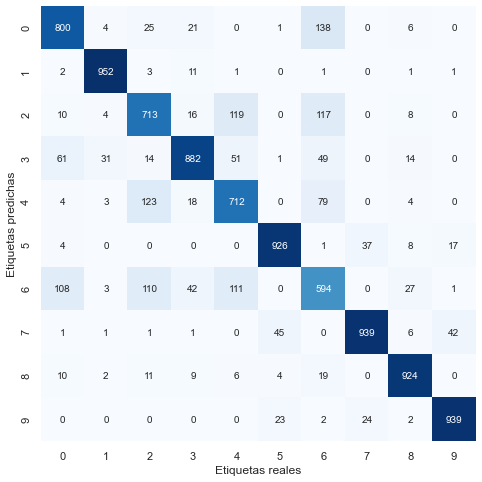

In [15]:
y_pred_test = best_model1.predict(X_test)
print('--------------------------------------------------------')
print('Reporte para el modelo sobre datos de prueba')
print(classification_report(y_test.to_numpy().argmax(axis=-1), y_pred_test))
print('--------------------------------------------------------')
plt.figure(figsize=(8,8))
mat = confusion_matrix(y_test.to_numpy().argmax(axis=-1), y_pred_test)
sns.heatmap(mat.T, square=True, annot=True, cmap='Blues',fmt='d', cbar=False)
plt.xlabel('Etiquetas reales')
plt.ylabel('Etiquetas predichas')

## Modelo 2: Entrenamiento de un encoder para realizar una reducción de la dimensionalidad y sobre el nuevo conjunto de características se contruye el modelo de clasificación con un perceptrón multicapa.
De forma análoga al primer modelo, se parte de una arquitectura base del autoencoder en el que se cuenta con la misma estructura ya presentada de capas convolucionales para el encoder y de forma inversa para el decoder. Es de resaltar que en la capa de salida se utiliza la función de activación sigmoide dada la normalización inicial de las imágenes. Posteriormente, se compila el modelo usando ahora la función de costo MSE considerando que ahora se tiene un problema de regresión. Después de esto, y utilizando de nuevo el criterio de parada, se entrena este modelo.

In [16]:
autoencoder2 = Sequential(name="Autoencoder2")
autoencoder2.add(Conv2D(filters=16, kernel_size=3, strides=2, padding="same", input_shape=(28, 28, 1)))
autoencoder2.add(Conv2D(filters=8, kernel_size=3, strides=2, padding="same"))
autoencoder2.add(Conv2D(filters=8, kernel_size=3, strides=1, padding="same", name="encoder"))
autoencoder2.add(Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding="same"))
autoencoder2.add(Conv2DTranspose(filters=1, kernel_size=3, strides=2, activation='sigmoid', padding="same"))
autoencoder2.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
autoencoder2.summary()

Model: "Autoencoder2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_120 (Conv2D)         (None, 14, 14, 16)        160       
                                                                 
 conv2d_121 (Conv2D)         (None, 7, 7, 8)           1160      
                                                                 
 encoder (Conv2D)            (None, 7, 7, 8)           584       
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 16)       1168      
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 1)        145       
 ranspose)                                                       
                                                                 
Total params: 3,217
Trainable params: 3,217
Non-traina

In [17]:
autoencoder2.fit(X_train.reshape(-1, 28, 28, 1), X_train.reshape(-1, 28, 28, 1), 
                    epochs=100, batch_size=200, callbacks=callbacks)

Epoch 1/100
300/300 [==============================] - ETA: 0s - loss: 0.043 - 7s 22ms/step - loss: 0.0428
Epoch 2/100
300/300 [==============================] - ETA: 0s - loss: 0.013 - 7s 22ms/step - loss: 0.0134
Epoch 3/100
300/300 [==============================] - 7s 22ms/step - loss: 0.0096
Epoch 4/100
300/300 [==============================] - 7s 22ms/step - loss: 0.0079
Epoch 5/100
300/300 [==============================] - 7s 22ms/step - loss: 0.0068
Epoch 6/100
300/300 [==============================] - 7s 22ms/step - loss: 0.0061
Epoch 7/100
300/300 [==============================] - 7s 22ms/step - loss: 0.0057
Epoch 8/100
300/300 [==============================] - 7s 22ms/step - loss: 0.0053
Epoch 9/100
300/300 [==============================] - 7s 22ms/step - loss: 0.0050
Epoch 10/100
300/300 [==============================] - 7s 22ms/step - loss: 0.0047
Epoch 11/100
300/300 [==============================] - 7s 22ms/step - loss: 0.0045
Epoch 12/100
300/300 [===============

300/300 [==============================] - 6s 21ms/step - loss: 0.0036
Epoch 98/100
300/300 [==============================] - 6s 21ms/step - loss: 0.0036
Epoch 99/100
300/300 [==============================] - ETA: 0s - loss: 0.003 - 6s 21ms/step - loss: 0.0036
Epoch 100/100
300/300 [==============================] - 6s 22ms/step - loss: 0.0036


Con el propósito de evidenciar la capacidad de reconstrucción del autoencoder resultante, se presentan 10 de las imágenes de entrenamiento originales junto a su respectiva imagen reconstruida. Como se puede observar, aunque en algunos casos se pierden ciertos detalles de la imagen, las imágenes resultantes son considerablemente similares a las originales.

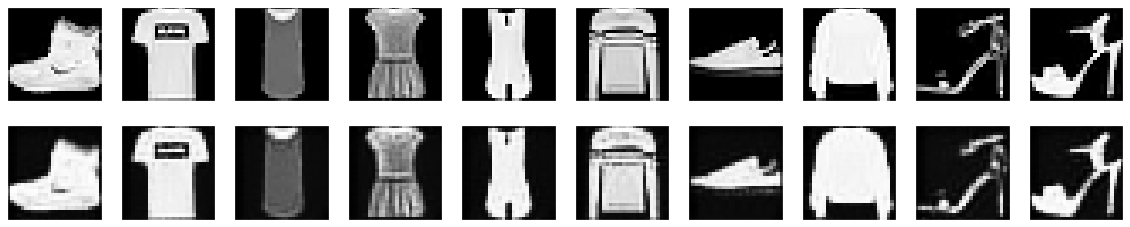

In [18]:
predicted = autoencoder2.predict(X_train[:10].reshape(-1, 28, 28, 1))
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
for images, row in zip([X_train[:10], predicted], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

Así pues, se crea de nuevo una función auxiliar que permita modificar el número de capas de convolución del autoencoder, los filtros en cada una de estas capas, el tamaño de los *kernels* y el número de *strides*. Sin embargo, luego de definir el pipeline junto con los distintos valores de los hiperparámetros a iterar e intentar ejecutar el entrenamiento de los múltiples modelos, se obtuvo que la librería utilizada no fue capaz de entrenar ninguno de los modelos a causa de un error en la función especificada para compararlos. Incluso definiendo una función propia que calcular tal score, el resultado fue insatisfactorio.

In [35]:
def crear_autoencoder2(fil1 = 16, fil2 = 8, fil3 = 4, n_layers= 3, ks=3, s=2):
    autoencoder = Sequential(name="Autoencoder")
    filters = [fil1, fil2, fil3]
    for i in range(n_layers):
        if i == 0:
            autoencoder.add(Conv2D(filters=filters[i], kernel_size=ks, strides=s, padding="same", input_shape=(28, 28, 1)))
        elif i == 1:
            autoencoder.add(Conv2D(filters=filters[i], kernel_size=ks, strides=s, padding="same"))
        else:
            autoencoder.add(Conv2D(filters=filters[i], kernel_size=ks, strides=1, padding="same"))
    for i in range(n_layers-1, -1, -1):
        if i == n_layers-1:
            autoencoder.add(Conv2D(filters=filters[i], kernel_size=ks, strides=1, padding="same", name="encoder"))
        elif i == 0:
            autoencoder.add(Conv2DTranspose(filters=filters[i], kernel_size=ks, strides=s, padding="same"))
        else:
            autoencoder.add(Conv2DTranspose(filters=filters[i], kernel_size=ks, strides=1, padding="same"))
    autoencoder.add(Conv2DTranspose(filters=1, kernel_size=ks, strides=s, activation='sigmoid', padding="same"))
    autoencoder.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
    return autoencoder

# Modelo que utiliza el GridSearch
autoencoder2_CV = KerasClassifier(build_fn=crear_autoencoder2, epochs=100, verbose=1, shuffle=True)

In [36]:
pipe_autoencoder2 = Pipeline([('autoencoder', autoencoder2_CV)])

param_grid = dict(autoencoder__fil1 = [20, 16, 12],
                  autoencoder__fil2 = [10, 8, 6],
                  autoencoder__fil3 = [5, 4, 3],
                  autoencoder__n_layers = [2, 3],
                  autoencoder__ks = [3, 5, 7],
                  autoencoder__s = [1, 2])

def my_mse(y_true, y_pred):
    img_true = y_true.reshape(-1, 28, 28, 1)
    img_pred = y_pred.reshape(-1, 28, 28, 1)
    return (np.square(img_true - img_pred)).mean(axis=None)
    
score = make_scorer(my_mse, greater_is_better=False)
grid_autoencoder2 = RandomizedSearchCV(pipe_autoencoder2, param_grid, 
                                       scoring=score, verbose=2, cv=3, n_iter=25, random_state=27)

In [37]:
grid_autoencoder2.fit(X_train.reshape(-1, 28, 28, 1), X_train.reshape(-1, 28, 28, 1), 
                      autoencoder__batch_size=200, autoencoder__callbacks=callbacks)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] END autoencoder__fil1=20, autoencoder__fil2=10, autoencoder__fil3=4, autoencoder__ks=3, autoencoder__n_layers=2, autoencoder__s=1; total time=   0.4s
[CV] END autoencoder__fil1=20, autoencoder__fil2=10, autoencoder__fil3=4, autoencoder__ks=3, autoencoder__n_layers=2, autoencoder__s=1; total time=   0.3s
[CV] END autoencoder__fil1=20, autoencoder__fil2=10, autoencoder__fil3=4, autoencoder__ks=3, autoencoder__n_layers=2, autoencoder__s=1; total time=   0.3s
[CV] END autoencoder__fil1=16, autoencoder__fil2=8, autoencoder__fil3=3, autoencoder__ks=3, autoencoder__n_layers=2, autoencoder__s=2; total time=   0.3s
[CV] END autoencoder__fil1=16, autoencoder__fil2=8, autoencoder__fil3=3, autoencoder__ks=3, autoencoder__n_layers=2, autoencoder__s=2; total time=   0.3s
[CV] END autoencoder__fil1=16, autoencoder__fil2=8, autoencoder__fil3=3, autoencoder__ks=3, autoencoder__n_layers=2, autoencoder__s=2; total time=   0.3s
[CV] END aut

[CV] END autoencoder__fil1=20, autoencoder__fil2=10, autoencoder__fil3=4, autoencoder__ks=7, autoencoder__n_layers=2, autoencoder__s=2; total time=   0.3s
[CV] END autoencoder__fil1=20, autoencoder__fil2=10, autoencoder__fil3=5, autoencoder__ks=7, autoencoder__n_layers=2, autoencoder__s=1; total time=   0.3s
[CV] END autoencoder__fil1=20, autoencoder__fil2=10, autoencoder__fil3=5, autoencoder__ks=7, autoencoder__n_layers=2, autoencoder__s=1; total time=   0.3s
[CV] END autoencoder__fil1=20, autoencoder__fil2=10, autoencoder__fil3=5, autoencoder__ks=7, autoencoder__n_layers=2, autoencoder__s=1; total time=   0.3s
[CV] END autoencoder__fil1=12, autoencoder__fil2=8, autoencoder__fil3=3, autoencoder__ks=5, autoencoder__n_layers=2, autoencoder__s=2; total time=   0.3s
[CV] END autoencoder__fil1=12, autoencoder__fil2=8, autoencoder__fil3=3, autoencoder__ks=5, autoencoder__n_layers=2, autoencoder__s=2; total time=   0.3s
[CV] END autoencoder__fil1=12, autoencoder__fil2=8, autoencoder__fil3=3,

NotFittedError: All estimators failed to fit

En este punto, una alternativa sería tratar de implementar la búsqueda de hiperparámetros manualmente debido a que *sklearn* no está diseñado para esta labor con base en la métrica de interés. Sin embargo, considerando el alcance de la actividad del laboratorio y que el modelo base del autoencoder presenta el comportamiento que se espera, se procede a utilizar dicho modelo para construir el clasificador. De esta forma, se extraen las capas convolucionales entrenadas de la sección del encoder y se congelan de forma que al entrenar el clasificador como tal no se vean alterados sus pesos. Luego del encoder, se agrega la capa de salida para la clasificación por medio de la activación *softmax* y la entropía cruzada categórica nuevamente como la función de costo. Es importante resaltar que este modelo comprende un clasificador base y, una vez compilado, se procede a entrenarlo.

In [38]:
clasificador2 = Sequential(name='PerceptronMulticapa2')
for layers in autoencoder2.layers:
    layers.trainable = False
    clasificador2.add(layers)
    if layers.name == "encoder":
        break
clasificador2.add(Flatten())
clasificador2.add(Dense(10))
clasificador2.add(Activation('softmax'))
clasificador2.compile(loss='categorical_crossentropy',
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                      metrics=["accuracy"])
clasificador2.summary()

Model: "PerceptronMulticapa2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_120 (Conv2D)         (None, 14, 14, 16)        160       
                                                                 
 conv2d_121 (Conv2D)         (None, 7, 7, 8)           1160      
                                                                 
 encoder (Conv2D)            (None, 7, 7, 8)           584       
                                                                 
 flatten_79 (Flatten)        (None, 392)               0         
                                                                 
 dense_28 (Dense)            (None, 10)                3930      
                                                                 
 activation_4 (Activation)   (None, 10)                0         
                                                                 
Total params: 5,834
Trainable params: 3,930
No

In [39]:
clasificador2.fit(X_train.reshape(-1, 28, 28, 1), y_train, 
                    epochs=100, batch_size=200, callbacks=callbacks)

Epoch 1/100
300/300 [==============================] - 1s 4ms/step - loss: 0.8313 - accuracy: 0.7195
Epoch 2/100
300/300 [==============================] - 1s 4ms/step - loss: 0.5160 - accuracy: 0.8232
Epoch 3/100
300/300 [==============================] - 1s 4ms/step - loss: 0.4727 - accuracy: 0.8382
Epoch 4/100
300/300 [==============================] - 1s 4ms/step - loss: 0.4530 - accuracy: 0.8440
Epoch 5/100
300/300 [==============================] - 1s 4ms/step - loss: 0.4395 - accuracy: 0.8488
Epoch 6/100
300/300 [==============================] - 1s 4ms/step - loss: 0.4318 - accuracy: 0.8514
Epoch 7/100
300/300 [==============================] - 1s 4ms/step - loss: 0.4249 - accuracy: 0.8540
Epoch 8/100
300/300 [==============================] - 1s 4ms/step - loss: 0.4204 - accuracy: 0.8548
Epoch 9/100
300/300 [==============================] - 1s 4ms/step - loss: 0.4163 - accuracy: 0.8567
Epoch 10/100
300/300 [==============================] - 1s 4ms/step - loss: 0.4130 - accura

Una vez entrenado al clasificador, se evalua su desempeño sobre los datos de entrenamiento obteniéndose una exactitud aceptable que en comparación con el modelo base de la primera actividad es levemente mayor.

In [71]:
evaluation = clasificador2.evaluate(X_train.reshape(-1, 28, 28, 1), y_train)
print('Train Loss : {:.4f}, Train Accuracy : {:.4f}'.format(evaluation[0], evaluation[1]))

1875/1875 [==============================] - 3s 2ms/step - loss: 0.3766 - accuracy: 0.8691
Train Loss : 0.3766, Train Accuracy : 0.8691


Así pues, de nuevo se genera una función para modificar los hiperparámetros exclusivos del clasificador. Entre ellos, si se utiliza o no una capa intermedia, el número de neuronas en esta, el factor de *dropout* y la función de activación. Seguido a esto, se define el pipeline, los valores de interés para los hiperparámetros sobre los cuales iterar y se efectúa el entrenamiento de los distintos modelos.

In [43]:
def crear_clasificador2(capa_oculta=False, nn=8, dropout=0.1, activacion_oculta='relu'):
    global autoencoder2
    clasificador2 = Sequential(name="Clasificador2")
    for layers in autoencoder2.layers:
        layers.trainable = False
        clasificador2.add(layers)
        if layers.name == "encoder":
            break
    clasificador2.add(Flatten())
    if capa_oculta:
        clasificador2.add(Dense(nn))
        clasificador2.add(Activation(activacion_oculta))
        clasificador2.add(Dropout(dropout))
    clasificador2.add(Dense(10))
    clasificador2.add(Activation('softmax'))
    clasificador2.compile(loss='categorical_crossentropy',
                          optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                          metrics=["accuracy"])
    return clasificador2

clasificador2_CV = KerasClassifier(build_fn=crear_clasificador2, epochs=100, verbose=1, shuffle=True)

In [44]:
pipe_clasificador2 = Pipeline([('red_neuronal', clasificador2_CV)])

param_grid = dict(red_neuronal__capa_oculta = [True, False],
                  red_neuronal__nn = [20, 40, 60, 80],
                  red_neuronal__dropout = [0.1, 0.2, 0.3],
                  red_neuronal__activacion_oculta = ['relu', 'sigmoid'])

score = make_scorer(my_custom_acc, greater_is_better=True)
grid_clasificador2 = RandomizedSearchCV(pipe_clasificador2, param_grid, 
                                        scoring=score, verbose=2, cv=3, n_iter=25, random_state=0)

In [45]:
grid_clasificador2.fit(X_train.reshape(-1, 28, 28, 1), y_train, 
                       red_neuronal__batch_size=200, red_neuronal__callbacks=callbacks)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Epoch 1/100
200/200 [==============================] - 1s 4ms/step - loss: 1.2046 - accuracy: 0.6532
Epoch 2/100
200/200 [==============================] - 1s 4ms/step - loss: 0.6880 - accuracy: 0.7896
Epoch 3/100
200/200 [==============================] - 1s 4ms/step - loss: 0.5771 - accuracy: 0.8133
Epoch 4/100
200/200 [==============================] - 1s 4ms/step - loss: 0.5268 - accuracy: 0.8242
Epoch 5/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4958 - accuracy: 0.8331
Epoch 6/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4705 - accuracy: 0.8400
Epoch 7/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4556 - accuracy: 0.8441
Epoch 8/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4397 - accuracy: 0.8489
Epoch 9/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4293 - accuracy: 0.8512
Epoch 10/100
200/200 [========

200/200 [==============================] - 1s 4ms/step - loss: 0.2689 - accuracy: 0.9025
Epoch 81/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2686 - accuracy: 0.9017
Epoch 82/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2701 - accuracy: 0.9007
Epoch 83/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2654 - accuracy: 0.9024
Epoch 84/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2666 - accuracy: 0.9032
Epoch 85/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2662 - accuracy: 0.9033
Epoch 86/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2640 - accuracy: 0.9046
Epoch 87/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2653 - accuracy: 0.9021
Epoch 88/100
200/200 [==============================] - 1s 5ms/step - loss: 0.2663 - accuracy: 0.9035
Epoch 89/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2620 - accuracy: 

200/200 [==============================] - 1s 4ms/step - loss: 0.2842 - accuracy: 0.8940
Epoch 67/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2829 - accuracy: 0.8946
Epoch 68/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2802 - accuracy: 0.8970
Epoch 69/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2806 - accuracy: 0.8954
Epoch 70/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2788 - accuracy: 0.8956
Epoch 71/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2811 - accuracy: 0.8951
Epoch 72/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2781 - accuracy: 0.8962
Epoch 73/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2781 - accuracy: 0.8957
Epoch 74/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2796 - accuracy: 0.8972
Epoch 75/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2767 - accuracy: 

200/200 [==============================] - 1s 4ms/step - loss: 0.2882 - accuracy: 0.8948
Epoch 59/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2899 - accuracy: 0.8941
Epoch 60/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2885 - accuracy: 0.8951
Epoch 61/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2879 - accuracy: 0.8941
Epoch 62/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2878 - accuracy: 0.8945
Epoch 63/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2861 - accuracy: 0.8941
Epoch 64/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2842 - accuracy: 0.8956
Epoch 65/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2822 - accuracy: 0.8974
Epoch 66/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2833 - accuracy: 0.8960
Epoch 67/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2836 - accuracy: 

200/200 [==============================] - 1s 4ms/step - loss: 0.4559 - accuracy: 0.8372
Epoch 13/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4485 - accuracy: 0.8364
Epoch 14/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4442 - accuracy: 0.8383
Epoch 15/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4394 - accuracy: 0.8395
Epoch 16/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4347 - accuracy: 0.8427
Epoch 17/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4309 - accuracy: 0.8445
Epoch 18/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4293 - accuracy: 0.8443
Epoch 19/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4260 - accuracy: 0.8461
Epoch 20/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4233 - accuracy: 0.8468
Epoch 21/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4255 - accuracy: 

200/200 [==============================] - 1s 4ms/step - loss: 0.3926 - accuracy: 0.8553
Epoch 34/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3930 - accuracy: 0.8548
Epoch 35/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3891 - accuracy: 0.8547
Epoch 36/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3872 - accuracy: 0.8559: 0s - l
Epoch 37/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3865 - accuracy: 0.8553
Epoch 38/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3845 - accuracy: 0.8579
Epoch 39/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3835 - accuracy: 0.8547
Epoch 40/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3844 - accuracy: 0.8555
Epoch 41/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3807 - accuracy: 0.8588
Epoch 42/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3832 - ac

200/200 [==============================] - 1s 4ms/step - loss: 0.1965 - accuracy: 0.9293
Epoch 66/100
200/200 [==============================] - 1s 4ms/step - loss: 0.1978 - accuracy: 0.9289
Epoch 67/100
200/200 [==============================] - 1s 4ms/step - loss: 0.1933 - accuracy: 0.9299
Epoch 68/100
200/200 [==============================] - 1s 4ms/step - loss: 0.1939 - accuracy: 0.9292
Epoch 69/100
200/200 [==============================] - 1s 4ms/step - loss: 0.1923 - accuracy: 0.9300
Epoch 70/100
200/200 [==============================] - 1s 4ms/step - loss: 0.1927 - accuracy: 0.9295
Epoch 71/100
200/200 [==============================] - 1s 4ms/step - loss: 0.1908 - accuracy: 0.9308
Epoch 72/100
200/200 [==============================] - 1s 4ms/step - loss: 0.1913 - accuracy: 0.9311
Epoch 73/100
200/200 [==============================] - 1s 4ms/step - loss: 0.1859 - accuracy: 0.9334
Epoch 74/100
200/200 [==============================] - ETA: 0s - loss: 0.1868 - accuracy: 0.93

200/200 [==============================] - 1s 4ms/step - loss: 0.2327 - accuracy: 0.9162
Epoch 46/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2285 - accuracy: 0.9171
Epoch 47/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2279 - accuracy: 0.9188
Epoch 48/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2266 - accuracy: 0.9178
Epoch 49/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2250 - accuracy: 0.9184
Epoch 50/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2204 - accuracy: 0.9220
Epoch 51/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2203 - accuracy: 0.9213
Epoch 52/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2186 - accuracy: 0.9202
Epoch 53/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2162 - accuracy: 0.9217
Epoch 54/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2156 - accuracy: 

200/200 [==============================] - 1s 4ms/step - loss: 0.2540 - accuracy: 0.9089
Epoch 35/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2492 - accuracy: 0.9108
Epoch 36/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2477 - accuracy: 0.9112
Epoch 37/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2473 - accuracy: 0.9112
Epoch 38/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2429 - accuracy: 0.9129
Epoch 39/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2395 - accuracy: 0.9136
Epoch 40/100
200/200 [==============================] - 1s 5ms/step - loss: 0.2383 - accuracy: 0.9146
Epoch 41/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2375 - accuracy: 0.9141
Epoch 42/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2338 - accuracy: 0.9151
Epoch 43/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2310 - accuracy: 

200/200 [==============================] - 1s 4ms/step - loss: 0.3657 - accuracy: 0.8694
Epoch 14/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3574 - accuracy: 0.8737
Epoch 15/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3517 - accuracy: 0.8750
Epoch 16/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3455 - accuracy: 0.8773
Epoch 17/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3444 - accuracy: 0.8773
Epoch 18/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3347 - accuracy: 0.8810
Epoch 19/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3344 - accuracy: 0.8802
Epoch 20/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3264 - accuracy: 0.8828
Epoch 21/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3237 - accuracy: 0.8854
Epoch 22/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3204 - accuracy: 

200/200 [==============================] - 1s 4ms/step - loss: 0.3037 - accuracy: 0.8909
Epoch 28/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3009 - accuracy: 0.8897
Epoch 29/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2989 - accuracy: 0.8925
Epoch 30/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2966 - accuracy: 0.8930
Epoch 31/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2923 - accuracy: 0.8942
Epoch 32/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2925 - accuracy: 0.8940
Epoch 33/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2905 - accuracy: 0.8957
Epoch 34/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2856 - accuracy: 0.8969
Epoch 35/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2850 - accuracy: 0.8984
Epoch 36/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2823 - accuracy: 

200/200 [==============================] - 1s 7ms/step - loss: 0.2503 - accuracy: 0.9075
Epoch 51/100
200/200 [==============================] - 1s 7ms/step - loss: 0.2455 - accuracy: 0.9110
Epoch 52/100
200/200 [==============================] - 1s 6ms/step - loss: 0.2431 - accuracy: 0.9107
Epoch 53/100
200/200 [==============================] - ETA: 0s - loss: 0.2427 - accuracy: 0.90 - 1s 5ms/step - loss: 0.2432 - accuracy: 0.9097
Epoch 54/100
200/200 [==============================] - 1s 5ms/step - loss: 0.2404 - accuracy: 0.9120
Epoch 55/100
200/200 [==============================] - 1s 5ms/step - loss: 0.2419 - accuracy: 0.9106
Epoch 56/100
200/200 [==============================] - 1s 5ms/step - loss: 0.2390 - accuracy: 0.9125
Epoch 57/100
200/200 [==============================] - 1s 6ms/step - loss: 0.2375 - accuracy: 0.9118
Epoch 58/100
200/200 [==============================] - 1s 5ms/step - loss: 0.2317 - accuracy: 0.9138
Epoch 59/100
200/200 [==============================]

200/200 [==============================] - 1s 4ms/step - loss: 0.5819 - accuracy: 0.7992
Epoch 11/100
200/200 [==============================] - 1s 4ms/step - loss: 0.5686 - accuracy: 0.8036
Epoch 12/100
200/200 [==============================] - 1s 4ms/step - loss: 0.5596 - accuracy: 0.8048
Epoch 13/100
200/200 [==============================] - 1s 5ms/step - loss: 0.5501 - accuracy: 0.8046
Epoch 14/100
200/200 [==============================] - 1s 5ms/step - loss: 0.5435 - accuracy: 0.8084
Epoch 15/100
200/200 [==============================] - 1s 4ms/step - loss: 0.5364 - accuracy: 0.8118
Epoch 16/100
200/200 [==============================] - 1s 4ms/step - loss: 0.5343 - accuracy: 0.8093
Epoch 17/100
200/200 [==============================] - 1s 4ms/step - loss: 0.5252 - accuracy: 0.8142
Epoch 18/100
200/200 [==============================] - 1s 4ms/step - loss: 0.5209 - accuracy: 0.8134
Epoch 19/100
200/200 [==============================] - 1s 4ms/step - loss: 0.5188 - accuracy: 

200/200 [==============================] - 1s 4ms/step - loss: 0.4712 - accuracy: 0.8297
Epoch 42/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4736 - accuracy: 0.8278
Epoch 43/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4694 - accuracy: 0.8270
Epoch 44/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4673 - accuracy: 0.8309
Epoch 45/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4660 - accuracy: 0.8298
Epoch 46/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4694 - accuracy: 0.8279
Epoch 47/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4668 - accuracy: 0.8315
Epoch 48/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4672 - accuracy: 0.8291
Epoch 00048: early stopping
[CV] END red_neuronal__activacion_oculta=sigmoid, red_neuronal__capa_oculta=True, red_neuronal__dropout=0.3, red_neuronal__nn=20; total time=  44.3s
Epoch 1/100
200/200 

200/200 [==============================] - 1s 4ms/step - loss: 0.4169 - accuracy: 0.8541
Epoch 12/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4137 - accuracy: 0.8558
Epoch 13/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4101 - accuracy: 0.8564
Epoch 14/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4078 - accuracy: 0.8586
Epoch 15/100
200/200 [==============================] - ETA: 0s - loss: 0.4061 - accuracy: 0.85 - 1s 4ms/step - loss: 0.4057 - accuracy: 0.8590
Epoch 16/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4044 - accuracy: 0.8585
Epoch 17/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4022 - accuracy: 0.8599
Epoch 18/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3995 - accuracy: 0.8602
Epoch 19/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3980 - accuracy: 0.8612
Epoch 20/100
200/200 [==============================]

200/200 [==============================] - 1s 4ms/step - loss: 0.3859 - accuracy: 0.8658
Epoch 35/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3857 - accuracy: 0.8652
Epoch 36/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3848 - accuracy: 0.8661
Epoch 37/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3857 - accuracy: 0.8660
Epoch 38/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3850 - accuracy: 0.8655
Epoch 39/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3843 - accuracy: 0.8651
Epoch 40/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3825 - accuracy: 0.8667
Epoch 41/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3828 - accuracy: 0.8666
Epoch 42/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3819 - accuracy: 0.8678
Epoch 43/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3821 - accuracy: 

200/200 [==============================] - 1s 4ms/step - loss: 0.2933 - accuracy: 0.8938
Epoch 45/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2939 - accuracy: 0.8920
Epoch 46/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2917 - accuracy: 0.8932
Epoch 47/100
200/200 [==============================] - 1s 5ms/step - loss: 0.2908 - accuracy: 0.8949
Epoch 48/100
200/200 [==============================] - 1s 5ms/step - loss: 0.2878 - accuracy: 0.8964
Epoch 49/100
200/200 [==============================] - 1s 5ms/step - loss: 0.2893 - accuracy: 0.8948
Epoch 50/100
200/200 [==============================] - 1s 5ms/step - loss: 0.2840 - accuracy: 0.8955
Epoch 51/100
200/200 [==============================] - 1s 5ms/step - loss: 0.2841 - accuracy: 0.8968
Epoch 52/100
200/200 [==============================] - 1s 5ms/step - loss: 0.2844 - accuracy: 0.8970
Epoch 53/100
200/200 [==============================] - 1s 5ms/step - loss: 0.2810 - accuracy: 

200/200 [==============================] - 1s 4ms/step - loss: 0.3236 - accuracy: 0.8826
Epoch 30/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3215 - accuracy: 0.8837
Epoch 31/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3205 - accuracy: 0.8835
Epoch 32/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3169 - accuracy: 0.8839
Epoch 33/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3121 - accuracy: 0.8865
Epoch 34/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3111 - accuracy: 0.8861
Epoch 35/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3075 - accuracy: 0.8881
Epoch 36/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3039 - accuracy: 0.8893
Epoch 37/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3054 - accuracy: 0.8877
Epoch 38/100
200/200 [==============================] - 1s 5ms/step - loss: 0.2991 - accuracy: 

200/200 [==============================] - 1s 4ms/step - loss: 0.2904 - accuracy: 0.8945
Epoch 45/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2904 - accuracy: 0.8952
Epoch 46/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2854 - accuracy: 0.8956
Epoch 47/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2865 - accuracy: 0.8959
Epoch 48/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2848 - accuracy: 0.8968
Epoch 49/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2851 - accuracy: 0.8950
Epoch 50/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2785 - accuracy: 0.8969
Epoch 51/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2779 - accuracy: 0.8992
Epoch 52/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2775 - accuracy: 0.8992
Epoch 53/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2757 - accuracy: 

200/200 [==============================] - 1s 4ms/step - loss: 0.3786 - accuracy: 0.8676
Epoch 44/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3786 - accuracy: 0.8679
Epoch 45/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3782 - accuracy: 0.8688
Epoch 00045: early stopping
[CV] END red_neuronal__activacion_oculta=sigmoid, red_neuronal__capa_oculta=False, red_neuronal__dropout=0.2, red_neuronal__nn=20; total time=  37.2s
Epoch 1/100
200/200 [==============================] - 1s 4ms/step - loss: 0.9655 - accuracy: 0.6695
Epoch 2/100
200/200 [==============================] - 1s 4ms/step - loss: 0.5630 - accuracy: 0.8059
Epoch 3/100
200/200 [==============================] - 1s 4ms/step - loss: 0.5058 - accuracy: 0.8256
Epoch 4/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4774 - accuracy: 0.8333
Epoch 5/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4612 - accuracy: 0.8402
Epoch 6/100
200/200 [===

200/200 [==============================] - 1s 4ms/step - loss: 0.4259 - accuracy: 0.8541
Epoch 10/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4218 - accuracy: 0.8551
Epoch 11/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4195 - accuracy: 0.8565
Epoch 12/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4155 - accuracy: 0.8566
Epoch 13/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4111 - accuracy: 0.8591
Epoch 14/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4086 - accuracy: 0.8591
Epoch 15/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4063 - accuracy: 0.8608
Epoch 16/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4047 - accuracy: 0.8599
Epoch 17/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4031 - accuracy: 0.8615
Epoch 18/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4005 - accuracy: 

200/200 [==============================] - 1s 5ms/step - loss: 0.2278 - accuracy: 0.9154
Epoch 26/100
200/200 [==============================] - 1s 5ms/step - loss: 0.2234 - accuracy: 0.9176
Epoch 27/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2196 - accuracy: 0.9179
Epoch 28/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2170 - accuracy: 0.9199
Epoch 29/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2153 - accuracy: 0.9205
Epoch 30/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2113 - accuracy: 0.9203
Epoch 31/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2092 - accuracy: 0.9226
Epoch 32/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2059 - accuracy: 0.9240
Epoch 33/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2031 - accuracy: 0.9251
Epoch 34/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2008 - accuracy: 

200/200 [==============================] - 1s 5ms/step - loss: 0.1887 - accuracy: 0.9285
Epoch 35/100
200/200 [==============================] - 1s 5ms/step - loss: 0.1876 - accuracy: 0.9304
Epoch 36/100
200/200 [==============================] - 1s 5ms/step - loss: 0.1861 - accuracy: 0.9302
Epoch 37/100
200/200 [==============================] - 1s 5ms/step - loss: 0.1842 - accuracy: 0.9297
Epoch 38/100
200/200 [==============================] - 1s 5ms/step - loss: 0.1847 - accuracy: 0.9303
Epoch 39/100
200/200 [==============================] - 1s 5ms/step - loss: 0.1801 - accuracy: 0.9329
Epoch 40/100
200/200 [==============================] - 1s 5ms/step - loss: 0.1754 - accuracy: 0.9337
Epoch 41/100
200/200 [==============================] - 1s 5ms/step - loss: 0.1777 - accuracy: 0.9334
Epoch 42/100
200/200 [==============================] - 1s 5ms/step - loss: 0.1718 - accuracy: 0.9357
Epoch 43/100
200/200 [==============================] - 1s 5ms/step - loss: 0.1718 - accuracy: 

200/200 [==============================] - 1s 5ms/step - loss: 0.1729 - accuracy: 0.9356
Epoch 47/100
200/200 [==============================] - 1s 5ms/step - loss: 0.1695 - accuracy: 0.9366
Epoch 48/100
200/200 [==============================] - 1s 5ms/step - loss: 0.1694 - accuracy: 0.9372
Epoch 49/100
200/200 [==============================] - 1s 5ms/step - loss: 0.1700 - accuracy: 0.9371
Epoch 50/100
200/200 [==============================] - 1s 5ms/step - loss: 0.1704 - accuracy: 0.9359
Epoch 51/100
200/200 [==============================] - 1s 5ms/step - loss: 0.1685 - accuracy: 0.9367
Epoch 52/100
200/200 [==============================] - 1s 5ms/step - loss: 0.1623 - accuracy: 0.9386
Epoch 53/100
200/200 [==============================] - 1s 5ms/step - loss: 0.1589 - accuracy: 0.9412
Epoch 54/100
200/200 [==============================] - 1s 5ms/step - loss: 0.1614 - accuracy: 0.9378
Epoch 55/100
200/200 [==============================] - 1s 5ms/step - loss: 0.1604 - accuracy: 

Epoch 1/100
200/200 [==============================] - 1s 5ms/step - loss: 0.8696 - accuracy: 0.6985
Epoch 2/100
200/200 [==============================] - 1s 4ms/step - loss: 0.5468 - accuracy: 0.8076
Epoch 3/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4829 - accuracy: 0.8292
Epoch 4/100
200/200 [==============================] - 1s 5ms/step - loss: 0.4479 - accuracy: 0.8393
Epoch 5/100
200/200 [==============================] - 1s 5ms/step - loss: 0.4268 - accuracy: 0.8478
Epoch 6/100
200/200 [==============================] - 1s 5ms/step - loss: 0.4071 - accuracy: 0.8529
Epoch 7/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3937 - accuracy: 0.8577
Epoch 8/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3828 - accuracy: 0.8621
Epoch 9/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3686 - accuracy: 0.8670
Epoch 10/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3632 - accura

200/200 [==============================] - 1s 5ms/step - loss: 0.4043 - accuracy: 0.8575
Epoch 7/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3878 - accuracy: 0.8615
Epoch 8/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3772 - accuracy: 0.8661
Epoch 9/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3662 - accuracy: 0.8699
Epoch 10/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3550 - accuracy: 0.8732
Epoch 11/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3513 - accuracy: 0.8747
Epoch 12/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3400 - accuracy: 0.8782
Epoch 13/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3369 - accuracy: 0.8801
Epoch 14/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3303 - accuracy: 0.8823
Epoch 15/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3220 - accuracy: 0.8

200/200 [==============================] - 1s 4ms/step - loss: 0.2848 - accuracy: 0.8948
Epoch 19/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2772 - accuracy: 0.8978
Epoch 20/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2773 - accuracy: 0.8974
Epoch 21/100
200/200 [==============================] - 1s 5ms/step - loss: 0.2689 - accuracy: 0.9007
Epoch 22/100
200/200 [==============================] - 1s 5ms/step - loss: 0.2649 - accuracy: 0.9015: 0s -
Epoch 23/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2590 - accuracy: 0.9049
Epoch 24/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2614 - accuracy: 0.9013
Epoch 25/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2540 - accuracy: 0.9051
Epoch 26/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2534 - accuracy: 0.9079
Epoch 27/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2526 - accu

200/200 [==============================] - 1s 5ms/step - loss: 0.2450 - accuracy: 0.9089
Epoch 29/100
200/200 [==============================] - 1s 5ms/step - loss: 0.2445 - accuracy: 0.9091
Epoch 30/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2393 - accuracy: 0.9107
Epoch 31/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2382 - accuracy: 0.9106
Epoch 32/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2334 - accuracy: 0.9129
Epoch 33/100
200/200 [==============================] - 1s 5ms/step - loss: 0.2324 - accuracy: 0.9122
Epoch 34/100
200/200 [==============================] - 1s 5ms/step - loss: 0.2282 - accuracy: 0.9139
Epoch 35/100
200/200 [==============================] - 1s 5ms/step - loss: 0.2296 - accuracy: 0.9125
Epoch 36/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2250 - accuracy: 0.9153
Epoch 37/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2266 - accuracy: 

200/200 [==============================] - 1s 4ms/step - loss: 0.3230 - accuracy: 0.8832
Epoch 12/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3165 - accuracy: 0.8839
Epoch 13/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3107 - accuracy: 0.8887
Epoch 14/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3013 - accuracy: 0.8900
Epoch 15/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2949 - accuracy: 0.8924
Epoch 16/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2893 - accuracy: 0.8939
Epoch 17/100
200/200 [==============================] - 1s 5ms/step - loss: 0.2875 - accuracy: 0.8955
Epoch 18/100
200/200 [==============================] - 1s 5ms/step - loss: 0.2828 - accuracy: 0.8956
Epoch 19/100
200/200 [==============================] - 1s 5ms/step - loss: 0.2762 - accuracy: 0.8986
Epoch 20/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2730 - accuracy: 

200/200 [==============================] - 1s 4ms/step - loss: 0.3187 - accuracy: 0.8860
Epoch 18/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3138 - accuracy: 0.8881
Epoch 19/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3068 - accuracy: 0.8900
Epoch 20/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3004 - accuracy: 0.8928
Epoch 21/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2973 - accuracy: 0.8942
Epoch 22/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2924 - accuracy: 0.8953
Epoch 23/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2918 - accuracy: 0.8963
Epoch 24/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2862 - accuracy: 0.8976
Epoch 25/100
200/200 [==============================] - 1s 5ms/step - loss: 0.2808 - accuracy: 0.8985
Epoch 26/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2771 - accuracy: 

200/200 [==============================] - 1s 5ms/step - loss: 0.2758 - accuracy: 0.8994
Epoch 28/100
200/200 [==============================] - 1s 5ms/step - loss: 0.2713 - accuracy: 0.9014
Epoch 29/100
200/200 [==============================] - 1s 5ms/step - loss: 0.2698 - accuracy: 0.9018
Epoch 30/100
200/200 [==============================] - 1s 5ms/step - loss: 0.2650 - accuracy: 0.9041
Epoch 31/100
200/200 [==============================] - 1s 5ms/step - loss: 0.2622 - accuracy: 0.9040
Epoch 32/100
200/200 [==============================] - 1s 5ms/step - loss: 0.2578 - accuracy: 0.9057
Epoch 33/100
200/200 [==============================] - 1s 5ms/step - loss: 0.2573 - accuracy: 0.9047
Epoch 34/100
200/200 [==============================] - 1s 5ms/step - loss: 0.2545 - accuracy: 0.9072
Epoch 35/100
200/200 [==============================] - 1s 5ms/step - loss: 0.2508 - accuracy: 0.9085
Epoch 36/100
200/200 [==============================] - 1s 5ms/step - loss: 0.2486 - accuracy: 

200/200 [==============================] - 1s 5ms/step - loss: 0.3525 - accuracy: 0.8751
Epoch 13/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3439 - accuracy: 0.8771
Epoch 14/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3380 - accuracy: 0.8798
Epoch 15/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3304 - accuracy: 0.8814
Epoch 16/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3228 - accuracy: 0.8845
Epoch 17/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3197 - accuracy: 0.8854
Epoch 18/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3138 - accuracy: 0.8865
Epoch 19/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3070 - accuracy: 0.8898
Epoch 20/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3042 - accuracy: 0.8917
Epoch 21/100
200/200 [==============================] - 1s 5ms/step - loss: 0.2989 - accuracy: 

200/200 [==============================] - 1s 4ms/step - loss: 0.1651 - accuracy: 0.9384
Epoch 93/100
200/200 [==============================] - 1s 4ms/step - loss: 0.1631 - accuracy: 0.9391
Epoch 94/100
200/200 [==============================] - 1s 4ms/step - loss: 0.1625 - accuracy: 0.9401
Epoch 95/100
200/200 [==============================] - 1s 4ms/step - loss: 0.1602 - accuracy: 0.9409
Epoch 96/100
200/200 [==============================] - 1s 4ms/step - loss: 0.1611 - accuracy: 0.9404
Epoch 97/100
200/200 [==============================] - 1s 4ms/step - loss: 0.1608 - accuracy: 0.9406
Epoch 98/100
200/200 [==============================] - 1s 4ms/step - loss: 0.1602 - accuracy: 0.9412
Epoch 00098: early stopping
[CV] END red_neuronal__activacion_oculta=sigmoid, red_neuronal__capa_oculta=True, red_neuronal__dropout=0.2, red_neuronal__nn=80; total time= 1.5min
Epoch 1/100
200/200 [==============================] - 1s 4ms/step - loss: 1.2330 - accuracy: 0.6344
Epoch 2/100
200/200 [

200/200 [==============================] - 1s 4ms/step - loss: 0.3127 - accuracy: 0.8849
Epoch 73/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3108 - accuracy: 0.8848
Epoch 74/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3094 - accuracy: 0.8861
Epoch 75/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3090 - accuracy: 0.8867
Epoch 76/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3089 - accuracy: 0.8857
Epoch 77/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3071 - accuracy: 0.8879
Epoch 78/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3099 - accuracy: 0.8860
Epoch 79/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3068 - accuracy: 0.8865
Epoch 80/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3051 - accuracy: 0.8878
Epoch 81/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3062 - accuracy: 

200/200 [==============================] - 1s 4ms/step - loss: 0.5339 - accuracy: 0.8216
Epoch 6/100
200/200 [==============================] - 1s 4ms/step - loss: 0.5068 - accuracy: 0.8293
Epoch 7/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4914 - accuracy: 0.8303
Epoch 8/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4749 - accuracy: 0.8354
Epoch 9/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4632 - accuracy: 0.8391
Epoch 10/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4540 - accuracy: 0.8440
Epoch 11/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4476 - accuracy: 0.8445
Epoch 12/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4398 - accuracy: 0.8457: 0s - loss:
Epoch 13/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4316 - accuracy: 0.8487
Epoch 14/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4235 - ac

200/200 [==============================] - 1s 4ms/step - loss: 0.4162 - accuracy: 0.8546
Epoch 6/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3961 - accuracy: 0.8609
Epoch 7/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3821 - accuracy: 0.8643
Epoch 8/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3713 - accuracy: 0.8689
Epoch 9/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3600 - accuracy: 0.8725
Epoch 10/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3496 - accuracy: 0.8754
Epoch 11/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3395 - accuracy: 0.8794
Epoch 12/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3307 - accuracy: 0.8831
Epoch 13/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3250 - accuracy: 0.8849
Epoch 14/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3184 - accuracy: 0.88

200/200 [==============================] - 1s 4ms/step - loss: 0.1413 - accuracy: 0.9492
Epoch 86/100
200/200 [==============================] - 1s 4ms/step - loss: 0.1390 - accuracy: 0.9513
Epoch 87/100
200/200 [==============================] - 1s 4ms/step - loss: 0.1371 - accuracy: 0.9510
Epoch 88/100
200/200 [==============================] - 1s 4ms/step - loss: 0.1386 - accuracy: 0.9495
Epoch 89/100
200/200 [==============================] - 1s 4ms/step - loss: 0.1367 - accuracy: 0.9513
Epoch 90/100
200/200 [==============================] - 1s 4ms/step - loss: 0.1360 - accuracy: 0.9515
Epoch 91/100
200/200 [==============================] - 1s 4ms/step - loss: 0.1381 - accuracy: 0.9499
Epoch 92/100
200/200 [==============================] - 1s 4ms/step - loss: 0.1353 - accuracy: 0.9517
Epoch 93/100
200/200 [==============================] - 1s 4ms/step - loss: 0.1317 - accuracy: 0.9530
Epoch 94/100
200/200 [==============================] - 1s 4ms/step - loss: 0.1339 - accuracy: 

200/200 [==============================] - 1s 4ms/step - loss: 0.1628 - accuracy: 0.9412
Epoch 65/100
200/200 [==============================] - 1s 4ms/step - loss: 0.1636 - accuracy: 0.9406
Epoch 66/100
200/200 [==============================] - 1s 4ms/step - loss: 0.1582 - accuracy: 0.9441
Epoch 67/100
200/200 [==============================] - 1s 4ms/step - loss: 0.1594 - accuracy: 0.9426
Epoch 68/100
200/200 [==============================] - 1s 4ms/step - loss: 0.1581 - accuracy: 0.9435
Epoch 69/100
200/200 [==============================] - 1s 4ms/step - loss: 0.1588 - accuracy: 0.9419
Epoch 70/100
200/200 [==============================] - 1s 4ms/step - loss: 0.1564 - accuracy: 0.9431
Epoch 71/100
200/200 [==============================] - 1s 4ms/step - loss: 0.1548 - accuracy: 0.9435
Epoch 72/100
200/200 [==============================] - 1s 4ms/step - loss: 0.1519 - accuracy: 0.9455
Epoch 73/100
200/200 [==============================] - 1s 4ms/step - loss: 0.1534 - accuracy: 

200/200 [==============================] - 1s 4ms/step - loss: 0.1663 - accuracy: 0.9391
Epoch 64/100
200/200 [==============================] - 1s 4ms/step - loss: 0.1639 - accuracy: 0.9405
Epoch 65/100
200/200 [==============================] - 1s 5ms/step - loss: 0.1635 - accuracy: 0.9414
Epoch 66/100
200/200 [==============================] - 1s 4ms/step - loss: 0.1618 - accuracy: 0.9428
Epoch 67/100
200/200 [==============================] - 1s 4ms/step - loss: 0.1592 - accuracy: 0.9427
Epoch 68/100
200/200 [==============================] - 1s 4ms/step - loss: 0.1617 - accuracy: 0.9412
Epoch 69/100
200/200 [==============================] - 1s 4ms/step - loss: 0.1589 - accuracy: 0.9431
Epoch 70/100
200/200 [==============================] - 1s 4ms/step - loss: 0.1601 - accuracy: 0.9423
Epoch 71/100
200/200 [==============================] - 1s 4ms/step - loss: 0.1564 - accuracy: 0.9438
Epoch 72/100
200/200 [==============================] - 1s 4ms/step - loss: 0.1538 - accuracy: 

200/200 [==============================] - 1s 4ms/step - loss: 0.3794 - accuracy: 0.8677
Epoch 43/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3796 - accuracy: 0.8681
Epoch 00043: early stopping
[CV] END red_neuronal__activacion_oculta=sigmoid, red_neuronal__capa_oculta=False, red_neuronal__dropout=0.3, red_neuronal__nn=80; total time=  35.4s
Epoch 1/100
200/200 [==============================] - 1s 4ms/step - loss: 0.9271 - accuracy: 0.6843
Epoch 2/100
200/200 [==============================] - 1s 4ms/step - loss: 0.5598 - accuracy: 0.8080
Epoch 3/100
200/200 [==============================] - 1s 4ms/step - loss: 0.5039 - accuracy: 0.8269
Epoch 4/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4759 - accuracy: 0.8351
Epoch 5/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4580 - accuracy: 0.8405
Epoch 6/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4474 - accuracy: 0.8436
Epoch 7/100
200/200 [====

200/200 [==============================] - 1s 4ms/step - loss: 0.4183 - accuracy: 0.8572
Epoch 12/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4148 - accuracy: 0.8573
Epoch 13/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4120 - accuracy: 0.8589
Epoch 14/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4089 - accuracy: 0.8598
Epoch 15/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4068 - accuracy: 0.8606
Epoch 16/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4046 - accuracy: 0.8603
Epoch 17/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4029 - accuracy: 0.8608
Epoch 18/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4012 - accuracy: 0.8609
Epoch 19/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3998 - accuracy: 0.8622
Epoch 20/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3992 - accuracy: 

200/200 [==============================] - 1s 4ms/step - loss: 0.1893 - accuracy: 0.9301
Epoch 37/100
200/200 [==============================] - 1s 4ms/step - loss: 0.1887 - accuracy: 0.9301
Epoch 38/100
200/200 [==============================] - 1s 4ms/step - loss: 0.1838 - accuracy: 0.9323
Epoch 39/100
200/200 [==============================] - 1s 4ms/step - loss: 0.1820 - accuracy: 0.9334
Epoch 40/100
200/200 [==============================] - 1s 4ms/step - loss: 0.1815 - accuracy: 0.9326
Epoch 41/100
200/200 [==============================] - 1s 4ms/step - loss: 0.1784 - accuracy: 0.9344
Epoch 42/100
200/200 [==============================] - 1s 4ms/step - loss: 0.1739 - accuracy: 0.9360
Epoch 43/100
200/200 [==============================] - 1s 4ms/step - loss: 0.1736 - accuracy: 0.9362
Epoch 44/100
200/200 [==============================] - 1s 4ms/step - loss: 0.1725 - accuracy: 0.9355
Epoch 45/100
200/200 [==============================] - 1s 4ms/step - loss: 0.1682 - accuracy: 

200/200 [==============================] - 1s 4ms/step - loss: 0.1459 - accuracy: 0.9453
Epoch 63/100
200/200 [==============================] - 1s 4ms/step - loss: 0.1478 - accuracy: 0.9445
Epoch 64/100
200/200 [==============================] - 1s 4ms/step - loss: 0.1466 - accuracy: 0.9456
Epoch 00064: early stopping
[CV] END red_neuronal__activacion_oculta=relu, red_neuronal__capa_oculta=True, red_neuronal__dropout=0.1, red_neuronal__nn=60; total time=  56.5s
Epoch 1/100
200/200 [==============================] - 1s 4ms/step - loss: 0.7489 - accuracy: 0.7396
Epoch 2/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4788 - accuracy: 0.8309
Epoch 3/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4233 - accuracy: 0.8489
Epoch 4/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3907 - accuracy: 0.8605
Epoch 5/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3719 - accuracy: 0.8656
Epoch 6/100
200/200 [=======

200/200 [==============================] - 1s 4ms/step - loss: 0.3852 - accuracy: 0.8671
Epoch 30/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3845 - accuracy: 0.8659
Epoch 31/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3843 - accuracy: 0.8666
Epoch 32/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3837 - accuracy: 0.8666
Epoch 33/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3835 - accuracy: 0.8676
Epoch 34/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3825 - accuracy: 0.8672
Epoch 35/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3822 - accuracy: 0.8671
Epoch 36/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3815 - accuracy: 0.8673
Epoch 37/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3808 - accuracy: 0.8674
Epoch 38/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3799 - accuracy: 

200/200 [==============================] - 1s 4ms/step - loss: 0.3903 - accuracy: 0.8635
Epoch 28/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3891 - accuracy: 0.8631
Epoch 29/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3891 - accuracy: 0.8625
Epoch 30/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3875 - accuracy: 0.8646
Epoch 31/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3871 - accuracy: 0.8644
Epoch 32/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3860 - accuracy: 0.8637
Epoch 33/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3860 - accuracy: 0.8638
Epoch 34/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3852 - accuracy: 0.8647
Epoch 35/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3842 - accuracy: 0.8638
Epoch 36/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3840 - accuracy: 

200/200 [==============================] - 1s 4ms/step - loss: 0.3830 - accuracy: 0.8664
Epoch 41/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3825 - accuracy: 0.8659
Epoch 42/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3822 - accuracy: 0.8673
Epoch 43/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3823 - accuracy: 0.8673
Epoch 44/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3815 - accuracy: 0.8676
Epoch 45/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3812 - accuracy: 0.8682
Epoch 46/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3809 - accuracy: 0.8668
Epoch 47/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3797 - accuracy: 0.8680
Epoch 48/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3806 - accuracy: 0.8677
Epoch 49/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3810 - accuracy: 

200/200 [==============================] - 1s 4ms/step - loss: 0.3736 - accuracy: 0.8699
Epoch 59/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3743 - accuracy: 0.8681
Epoch 60/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3736 - accuracy: 0.8704
Epoch 61/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3736 - accuracy: 0.8696
Epoch 62/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3736 - accuracy: 0.8693
Epoch 63/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3735 - accuracy: 0.8695
Epoch 64/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3729 - accuracy: 0.8690
Epoch 65/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3727 - accuracy: 0.8698
Epoch 66/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3728 - accuracy: 0.8689
Epoch 67/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3720 - accuracy: 

200/200 [==============================] - 1s 4ms/step - loss: 0.3743 - accuracy: 0.8680
Epoch 00065: early stopping
[CV] END red_neuronal__activacion_oculta=relu, red_neuronal__capa_oculta=False, red_neuronal__dropout=0.2, red_neuronal__nn=60; total time=  54.0s
Epoch 1/100
200/200 [==============================] - 1s 4ms/step - loss: 0.9516 - accuracy: 0.6762
Epoch 2/100
200/200 [==============================] - 1s 4ms/step - loss: 0.5625 - accuracy: 0.8090
Epoch 3/100
200/200 [==============================] - 1s 4ms/step - loss: 0.5052 - accuracy: 0.8271
Epoch 4/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4769 - accuracy: 0.8360
Epoch 5/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4596 - accuracy: 0.8422
Epoch 6/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4476 - accuracy: 0.8464
Epoch 7/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4383 - accuracy: 0.8501
Epoch 8/100
200/200 [========

200/200 [==============================] - 1s 4ms/step - loss: 0.3880 - accuracy: 0.8657
Epoch 28/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3869 - accuracy: 0.8652
Epoch 29/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3858 - accuracy: 0.8669
Epoch 30/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3856 - accuracy: 0.8666
Epoch 31/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3859 - accuracy: 0.8662
Epoch 32/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3852 - accuracy: 0.8664
Epoch 33/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3834 - accuracy: 0.8666
Epoch 34/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3821 - accuracy: 0.8679
Epoch 35/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3828 - accuracy: 0.8673
Epoch 36/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3813 - accuracy: 

200/200 [==============================] - 1s 4ms/step - loss: 0.3776 - accuracy: 0.8665
Epoch 53/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3771 - accuracy: 0.8664
Epoch 54/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3772 - accuracy: 0.8665
Epoch 55/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3767 - accuracy: 0.8660
Epoch 56/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3763 - accuracy: 0.8669
Epoch 57/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3760 - accuracy: 0.8671
Epoch 58/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3762 - accuracy: 0.8667
Epoch 59/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3764 - accuracy: 0.8666
Epoch 60/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3749 - accuracy: 0.8687
Epoch 61/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3755 - accuracy: 

200/200 [==============================] - 1s 4ms/step - loss: 0.6637 - accuracy: 0.7906
Epoch 5/100
200/200 [==============================] - 1s 4ms/step - loss: 0.6157 - accuracy: 0.8024
Epoch 6/100
200/200 [==============================] - 1s 4ms/step - loss: 0.5850 - accuracy: 0.8100
Epoch 7/100
200/200 [==============================] - 1s 4ms/step - loss: 0.5603 - accuracy: 0.8145
Epoch 8/100
200/200 [==============================] - 1s 4ms/step - loss: 0.5412 - accuracy: 0.8190
Epoch 9/100
200/200 [==============================] - 1s 4ms/step - loss: 0.5274 - accuracy: 0.8223
Epoch 10/100
200/200 [==============================] - 1s 4ms/step - loss: 0.5159 - accuracy: 0.8274
Epoch 11/100
200/200 [==============================] - 1s 4ms/step - loss: 0.5089 - accuracy: 0.8269
Epoch 12/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4961 - accuracy: 0.8307
Epoch 13/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4926 - accuracy: 0.830

200/200 [==============================] - 1s 4ms/step - loss: 0.4616 - accuracy: 0.8390
Epoch 18/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4563 - accuracy: 0.8397
Epoch 19/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4558 - accuracy: 0.8382
Epoch 20/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4515 - accuracy: 0.8406
Epoch 21/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4466 - accuracy: 0.8444
Epoch 22/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4463 - accuracy: 0.8402
Epoch 23/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4410 - accuracy: 0.8444
Epoch 24/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4375 - accuracy: 0.8439
Epoch 25/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4377 - accuracy: 0.8438
Epoch 26/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4307 - accuracy: 

200/200 [==============================] - 1s 4ms/step - loss: 0.4091 - accuracy: 0.8538
Epoch 45/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4083 - accuracy: 0.8530
Epoch 46/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4047 - accuracy: 0.8536
Epoch 47/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4028 - accuracy: 0.8564
Epoch 48/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4023 - accuracy: 0.8555
Epoch 49/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4030 - accuracy: 0.8566
Epoch 50/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4016 - accuracy: 0.8566
Epoch 51/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4001 - accuracy: 0.8559
Epoch 52/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3955 - accuracy: 0.8569
Epoch 53/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4021 - accuracy: 

200/200 [==============================] - 1s 4ms/step - loss: 0.3726 - accuracy: 0.8694
Epoch 68/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3721 - accuracy: 0.8691
Epoch 69/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3722 - accuracy: 0.8702
Epoch 00069: early stopping
[CV] END red_neuronal__activacion_oculta=relu, red_neuronal__capa_oculta=False, red_neuronal__dropout=0.3, red_neuronal__nn=60; total time=  56.3s
Epoch 1/100
200/200 [==============================] - 1s 4ms/step - loss: 0.9008 - accuracy: 0.6902
Epoch 2/100
200/200 [==============================] - 1s 4ms/step - loss: 0.5575 - accuracy: 0.8076
Epoch 3/100
200/200 [==============================] - 1s 4ms/step - loss: 0.5024 - accuracy: 0.8260
Epoch 4/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4755 - accuracy: 0.8358
Epoch 5/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4583 - accuracy: 0.8406
Epoch 6/100
200/200 [======

200/200 [==============================] - 1s 4ms/step - loss: 0.3887 - accuracy: 0.8646
Epoch 30/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3886 - accuracy: 0.8638
Epoch 31/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3870 - accuracy: 0.8661
Epoch 32/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3869 - accuracy: 0.8657
Epoch 33/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3865 - accuracy: 0.8658
Epoch 34/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3864 - accuracy: 0.8660
Epoch 35/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3849 - accuracy: 0.8667
Epoch 36/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3844 - accuracy: 0.8662
Epoch 37/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3846 - accuracy: 0.8667
Epoch 38/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3841 - accuracy: 

200/200 [==============================] - 1s 4ms/step - loss: 0.3749 - accuracy: 0.8686
Epoch 55/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3751 - accuracy: 0.8694
Epoch 56/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3746 - accuracy: 0.8694
Epoch 57/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3753 - accuracy: 0.8689
Epoch 58/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3748 - accuracy: 0.8681
Epoch 59/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3745 - accuracy: 0.8702
Epoch 60/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3725 - accuracy: 0.8704
Epoch 61/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3739 - accuracy: 0.8686
Epoch 62/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3740 - accuracy: 0.8689
Epoch 63/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3731 - accuracy: 

200/200 [==============================] - 1s 4ms/step - loss: 0.4168 - accuracy: 0.8571
Epoch 12/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4131 - accuracy: 0.8572
Epoch 13/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4095 - accuracy: 0.8594
Epoch 14/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4075 - accuracy: 0.8601
Epoch 15/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4056 - accuracy: 0.8599
Epoch 16/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4041 - accuracy: 0.8604
Epoch 17/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4025 - accuracy: 0.8615: 0s - l
Epoch 18/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3997 - accuracy: 0.8616
Epoch 19/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3988 - accuracy: 0.8615
Epoch 20/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3972 - ac

200/200 [==============================] - 1s 4ms/step - loss: 0.4178 - accuracy: 0.8563: 0s - l
Epoch 11/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4151 - accuracy: 0.8568
Epoch 12/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4112 - accuracy: 0.8591
Epoch 13/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4089 - accuracy: 0.8596
Epoch 14/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4053 - accuracy: 0.8600
Epoch 15/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4031 - accuracy: 0.8607
Epoch 16/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4019 - accuracy: 0.8605
Epoch 17/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3998 - accuracy: 0.8623
Epoch 18/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3981 - accuracy: 0.8626
Epoch 19/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3962 - ac

200/200 [==============================] - 1s 4ms/step - loss: 0.3928 - accuracy: 0.8621
Epoch 26/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3911 - accuracy: 0.8635
Epoch 27/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3893 - accuracy: 0.8630
Epoch 28/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3895 - accuracy: 0.8631
Epoch 29/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3878 - accuracy: 0.8640
Epoch 30/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3888 - accuracy: 0.8628
Epoch 31/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3863 - accuracy: 0.8637
Epoch 32/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3856 - accuracy: 0.8637
Epoch 33/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3847 - accuracy: 0.8655
Epoch 34/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3841 - accuracy: 

200/200 [==============================] - 1s 4ms/step - loss: 0.3838 - accuracy: 0.8653
Epoch 41/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3826 - accuracy: 0.8674
Epoch 42/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3819 - accuracy: 0.8675: 0s - l
Epoch 43/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3834 - accuracy: 0.8666
Epoch 44/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3808 - accuracy: 0.8670
Epoch 45/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3817 - accuracy: 0.8661
Epoch 46/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3803 - accuracy: 0.8677
Epoch 47/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3798 - accuracy: 0.8676
Epoch 48/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3811 - accuracy: 0.8668
Epoch 49/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3797 - ac

200/200 [==============================] - 1s 4ms/step - loss: 0.3755 - accuracy: 0.8694
Epoch 56/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3747 - accuracy: 0.8691
Epoch 57/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3750 - accuracy: 0.8689
Epoch 58/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3747 - accuracy: 0.8698
Epoch 59/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3739 - accuracy: 0.8691
Epoch 60/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3735 - accuracy: 0.8695
Epoch 61/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3743 - accuracy: 0.8698
Epoch 62/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3735 - accuracy: 0.8704
Epoch 63/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3733 - accuracy: 0.8701
Epoch 64/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3737 - accuracy: 

200/200 [==============================] - 1s 4ms/step - loss: 0.3763 - accuracy: 0.8665
Epoch 00057: early stopping
[CV] END red_neuronal__activacion_oculta=relu, red_neuronal__capa_oculta=False, red_neuronal__dropout=0.3, red_neuronal__nn=20; total time=  48.1s
Epoch 1/100
200/200 [==============================] - 1s 4ms/step - loss: 0.8905 - accuracy: 0.6971
Epoch 2/100
200/200 [==============================] - 1s 4ms/step - loss: 0.5515 - accuracy: 0.8121
Epoch 3/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4993 - accuracy: 0.8282
Epoch 4/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4729 - accuracy: 0.8378
Epoch 5/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4564 - accuracy: 0.8439
Epoch 6/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4460 - accuracy: 0.8474
Epoch 7/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4377 - accuracy: 0.8493
Epoch 8/100
200/200 [========

200/200 [==============================] - 1s 4ms/step - loss: 0.4173 - accuracy: 0.8568
Epoch 11/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4143 - accuracy: 0.8584
Epoch 12/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4097 - accuracy: 0.8596
Epoch 13/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4064 - accuracy: 0.8604
Epoch 14/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4044 - accuracy: 0.8606
Epoch 15/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4027 - accuracy: 0.8612
Epoch 16/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4013 - accuracy: 0.8610
Epoch 17/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3995 - accuracy: 0.8623
Epoch 18/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3976 - accuracy: 0.8638
Epoch 19/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3952 - accuracy: 

200/200 [==============================] - 1s 4ms/step - loss: 0.3895 - accuracy: 0.8634
Epoch 28/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3892 - accuracy: 0.8627
Epoch 29/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3878 - accuracy: 0.8633
Epoch 30/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3868 - accuracy: 0.8645
Epoch 31/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3862 - accuracy: 0.8645
Epoch 32/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3869 - accuracy: 0.8636
Epoch 33/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3852 - accuracy: 0.8641
Epoch 34/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3856 - accuracy: 0.8639
Epoch 35/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3839 - accuracy: 0.8657
Epoch 36/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3832 - accuracy: 

300/300 [==============================] - 1s 4ms/step - loss: 0.5960 - accuracy: 0.8041
Epoch 3/100
300/300 [==============================] - 1s 4ms/step - loss: 0.5198 - accuracy: 0.8224
Epoch 4/100
300/300 [==============================] - 1s 4ms/step - loss: 0.4814 - accuracy: 0.8347
Epoch 5/100
300/300 [==============================] - 1s 4ms/step - loss: 0.4550 - accuracy: 0.8405
Epoch 6/100
300/300 [==============================] - 1s 4ms/step - loss: 0.4378 - accuracy: 0.8457
Epoch 7/100
300/300 [==============================] - 1s 4ms/step - loss: 0.4225 - accuracy: 0.8517
Epoch 8/100
300/300 [==============================] - 1s 4ms/step - loss: 0.4127 - accuracy: 0.8534
Epoch 9/100
300/300 [==============================] - 1s 4ms/step - loss: 0.4060 - accuracy: 0.8555
Epoch 10/100
300/300 [==============================] - 1s 4ms/step - loss: 0.3932 - accuracy: 0.8610
Epoch 11/100
300/300 [==============================] - 1s 4ms/step - loss: 0.3889 - accuracy: 0.8617


300/300 [==============================] - 1s 4ms/step - loss: 0.2778 - accuracy: 0.8995
Epoch 83/100
300/300 [==============================] - 1s 4ms/step - loss: 0.2770 - accuracy: 0.8986
Epoch 84/100
300/300 [==============================] - 1s 4ms/step - loss: 0.2757 - accuracy: 0.8987
Epoch 85/100
300/300 [==============================] - 1s 4ms/step - loss: 0.2769 - accuracy: 0.8977
Epoch 86/100
300/300 [==============================] - 1s 4ms/step - loss: 0.2746 - accuracy: 0.8982
Epoch 87/100
300/300 [==============================] - 1s 4ms/step - loss: 0.2737 - accuracy: 0.8981
Epoch 88/100
300/300 [==============================] - 1s 4ms/step - loss: 0.2733 - accuracy: 0.8980
Epoch 89/100
300/300 [==============================] - 1s 4ms/step - loss: 0.2746 - accuracy: 0.8998
Epoch 90/100
300/300 [==============================] - 1s 4ms/step - loss: 0.2730 - accuracy: 0.8993
Epoch 91/100
300/300 [==============================] - 1s 4ms/step - loss: 0.2734 - accuracy: 

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('red_neuronal',
                                              <keras.wrappers.scikit_learn.KerasClassifier object at 0x000002564C3E4D48>)]),
                   n_iter=25,
                   param_distributions={'red_neuronal__activacion_oculta': ['relu',
                                                                            'sigmoid'],
                                        'red_neuronal__capa_oculta': [True,
                                                                      False],
                                        'red_neuronal__dropout': [0.1, 0.2,
                                                                  0.3],
                                        'red_neuronal__nn': [20, 40, 60, 80]},
                   random_state=0, scoring=make_scorer(my_custom_acc),
                   verbose=2)

Como se observa a continuación, el mejor clasificador obtenido en esta ocasión presenta un métrica de exactitud mucho mejor tanto sobre los datos de entrenamiento como en los de prueba ya que se obtuvo aproximadamente un 5% más de exactitud sobre ambos conjuntos con respecto al mejor clasificador obtenido sin haber pasado por la etapa del autoencoder.

In [72]:
best_model2 = grid_clasificador2.best_estimator_
evaluation = best_model2['red_neuronal'].model.evaluate(X_train.reshape(-1, 28, 28, 1), y_train)
print('Train Loss : {:.4f}, Train Accuracy : {:.4f}'.format(evaluation[0], evaluation[1]))

1875/1875 [==============================] - 4s 2ms/step - loss: 0.2110 - accuracy: 0.9233
Train Loss : 0.2110, Train Accuracy : 0.9233


In [73]:
evaluation = best_model2['red_neuronal'].model.evaluate(X_test.reshape(-1, 28, 28, 1), y_test)
print('Test Loss : {:.4f}, Test Accuracy : {:.4f}'.format(evaluation[0], evaluation[1]))

313/313 [==============================] - 1s 2ms/step - loss: 0.3739 - accuracy: 0.8717
Test Loss : 0.3739, Test Accuracy : 0.8717


De igual forma, se presenta el reporte con las distintas métricas donde se observa que las clases 2 y 4 presentan métricas más cercanas con respecto a las demás categorías aunque la clase 6 continua siendo la que más clasificaciones erradas posee. Lo anterior se evidencia en la matriz de confusión de igual manera.

--------------------------------------------------------
Reporte para el modelo sobre datos de prueba
              precision    recall  f1-score   support

           0       0.80      0.85      0.82      1000
           1       0.98      0.96      0.97      1000
           2       0.79      0.78      0.78      1000
           3       0.87      0.88      0.87      1000
           4       0.76      0.84      0.80      1000
           5       0.96      0.94      0.95      1000
           6       0.71      0.60      0.65      1000
           7       0.94      0.95      0.94      1000
           8       0.95      0.96      0.95      1000
           9       0.95      0.96      0.96      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

--------------------------------------------------------


Text(54.260000000000005, 0.5, 'Etiquetas predichas')

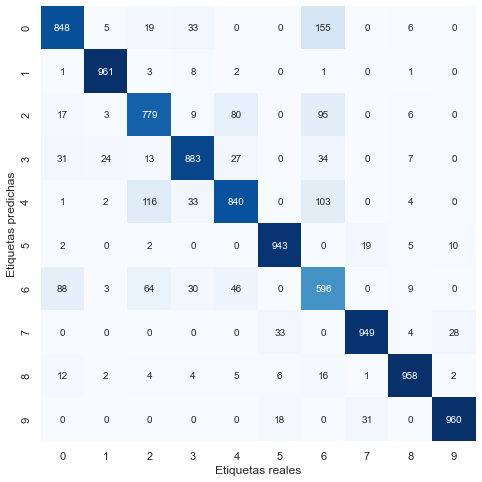

In [48]:
y_pred_test = best_model2.predict(X_test)
print('--------------------------------------------------------')
print('Reporte para el modelo sobre datos de prueba')
print(classification_report(y_test.to_numpy().argmax(axis=-1), y_pred_test))
print('--------------------------------------------------------')
plt.figure(figsize=(8,8))
mat = confusion_matrix(y_test.to_numpy().argmax(axis=-1), y_pred_test)
sns.heatmap(mat.T, square=True, annot=True, cmap='Blues',fmt='d', cbar=False)
plt.xlabel('Etiquetas reales')
plt.ylabel('Etiquetas predichas')

## Modelo 3: Entrenamiento de un denoising autoendoder para preentrenar una red profunda y construcción de un perceptrón multicapa al reutilizar las primeras capas del autoencoder
Para este modelo, inicialmente se genera una función que permite agregar cierto factor de ruido aleatorio a las imágenes. Luego, esta es aplicada sobre el conjunto de imágenes de entrenamiento al definir el factor de ruido de 0.2 y se evidencia una de las imágenes con ruido junto a su etiqueta de clase.

In [81]:
def noising_image(data, noise_factor, seed):
    noise_dataset = []
    np.random.seed(seed)
    for img in data:
        noisy_image = img + noise_factor * np.random.randn(*img.shape)
        noisy_image = np.clip(noisy_image, 0., 1.)
        noise_dataset.append(noisy_image)
    noise_dataset = np.array(noise_dataset)
    return noise_dataset

In [50]:
X_train_noise = noising_image(X_train, 0.2, 0)

Etiqueta:
 0    0
1    0
2    0
3    1
4    0
5    0
6    0
7    0
8    0
9    0
Name: 28149, dtype: uint8


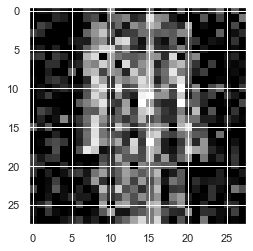

In [51]:
print("Etiqueta:\n", y_train.iloc[i,:])
plt.imshow(X_train_noise[i], cmap="gray")

Posteriormente, se define la misma arquitectura base para el denoising autoencoder que para el autoencoder base de la actividad 2. Una vez compilado, se entrena al aplicar como entrada el conjunto de datos con ruido y como salida el conjunto de datos original. Esto permitirá que el modelo aprenda a reconstruir imágenes removiendo el ruido, lo que implica que en el proceso de reducción de dimensionalidad este se deberá enfocar en las características propias de las prendas de ropa.

In [52]:
autoencoder3 = Sequential(name="Denoising_Autoencoder3")
autoencoder3.add(Conv2D(filters=16, kernel_size=3, strides=2, padding="same", input_shape=(28, 28, 1)))
autoencoder3.add(Conv2D(filters=8, kernel_size=3, strides=2, padding="same"))
autoencoder3.add(Conv2D(filters=8, kernel_size=3, strides=1, padding="same", name="encoder"))
autoencoder3.add(Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding="same"))
autoencoder3.add(Conv2DTranspose(filters=1, kernel_size=3, strides=2, activation='sigmoid', padding="same"))
autoencoder3.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
autoencoder3.summary()

Model: "Denoising_Autoencoder3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_122 (Conv2D)         (None, 14, 14, 16)        160       
                                                                 
 conv2d_123 (Conv2D)         (None, 7, 7, 8)           1160      
                                                                 
 encoder (Conv2D)            (None, 7, 7, 8)           584       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 14, 14, 16)       1168      
 ranspose)                                                       
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 28, 28, 1)        145       
 ranspose)                                                       
                                                                 
Total params: 3,217
Trainable params: 3,217


In [53]:
autoencoder3.fit(X_train_noise.reshape(-1, 28, 28, 1), X_train.reshape(-1, 28, 28, 1), 
                epochs=100, batch_size=200, callbacks=callbacks)

Epoch 1/100
300/300 [==============================] - 7s 23ms/step - loss: 0.0481
Epoch 2/100
300/300 [==============================] - 7s 23ms/step - loss: 0.0164
Epoch 3/100
300/300 [==============================] - 7s 22ms/step - loss: 0.0142
Epoch 4/100
300/300 [==============================] - 7s 23ms/step - loss: 0.0129
Epoch 5/100
300/300 [==============================] - 7s 22ms/step - loss: 0.0121
Epoch 6/100
300/300 [==============================] - 7s 23ms/step - loss: 0.0116
Epoch 7/100
300/300 [==============================] - 7s 23ms/step - loss: 0.0113
Epoch 8/100
300/300 [==============================] - 7s 23ms/step - loss: 0.0111
Epoch 9/100
300/300 [==============================] - 7s 23ms/step - loss: 0.0109
Epoch 10/100
300/300 [==============================] - 7s 22ms/step - loss: 0.0107
Epoch 11/100
300/300 [==============================] - 7s 22ms/step - loss: 0.0106
Epoch 12/100
300/300 [==============================] - 7s 23ms/step - loss: 0.0105
E

300/300 [==============================] - 7s 23ms/step - loss: 0.0098
Epoch 99/100
300/300 [==============================] - 7s 24ms/step - loss: 0.0098
Epoch 00099: early stopping


Al utilizar el autoencoder denoising sobre algunas de las imágenes con ruido utilizados en el entrenamiento, se puede evidenciar un comportamiento satisfactorio donde para las distintas prendas el ruido se vio eliminado y el objeto reconstruido es acorde al original a pesar de una pérdida en la calidad de la imagen.

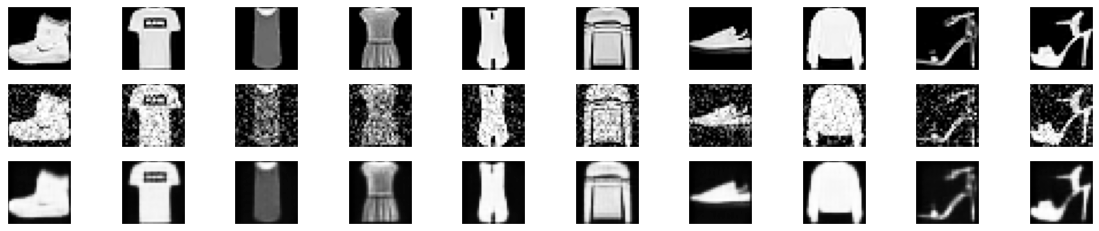

In [54]:
predicted = autoencoder3.predict(X_train[:10].reshape(-1, 28, 28, 1))
fig, axes = plt.subplots(nrows=3, ncols=10, sharex=True, sharey=True, figsize=(20,4))
for images, row in zip([X_train[:10], X_train_noise[:10], predicted], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

En último lugar, se genera la función que permitirá iterar sobre los hiperparámetros de este autoencoder. No obstante, tal como ocurrió en la actividad previa, la librería que realiza la búsqueda de hiperparámetros (*RandomizedSearchCV*) no es capaz de entrenar estos modelos por lo que nuevamente se opta por usar el autoencoder base para la construcción del clasificador a razón de que este presenta un buen comportamiento a la hora de remover el ruido de las imágenes.

In [55]:
def crear_autoencoder3(fil1 = 16, fil2 = 8, fil3 = 4, n_layers= 3, ks=3, s=2):
    autoencoder = Sequential(name="Autoencoder")
    filters = [fil1, fil2, fil3]
    for i in range(n_layers):
        if i == 0:
            autoencoder.add(Conv2D(filters=filters[i], kernel_size=ks, strides=s, padding="same", input_shape=(28, 28, 1)))
        else:
            autoencoder.add(Conv2D(filters=filters[i], kernel_size=ks, strides=s, padding="same"))
    for i in range(n_layers-1, -1, -1):
        if i == 0:
            autoencoder.add(Conv2D(filters=filters[i], kernel_size=ks, s=1, padding="same", name="encoder"))
        else:
            autoencoder.add(Conv2DTranspose(filters=filters[i], kernel_size=ks, strides=s, padding="same"))
    autoencoder.add(Conv2DTranspose(filters=1, kernel_size=ks, strides=s, activation='sigmoid', padding="same"))
    autoencoder.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
    return autoencoder

# Modelo que utiliza el GridSearch
autoencoder3_CV = KerasClassifier(build_fn=crear_autoencoder3, epochs=100, verbose=2, shuffle=True)

In [56]:
pipe_autoencoder3 = Pipeline([('autoencoder', autoencoder3_CV)])

param_grid = dict(autoencoder__fil1 = [20, 16, 12],
                  autoencoder__fil2 = [10, 8, 6],
                  autoencoder__fil3 = [5, 4, 3],
                  autoencoder__n_layers = [2, 3],
                  autoencoder__ks = [3, 5, 7],
                  autoencoder__s = [2, 3, 4])

score = make_scorer(mean_squared_error, greater_is_better=False)
grid_autoencoder3 = RandomizedSearchCV(pipe_autoencoder3, param_grid, scoring=score, verbose=2, cv=3, n_iter=25, random_state=0)

In [57]:
grid_autoencoder3.fit(X_train_noise.reshape(-1, 28, 28, 1), X_train.reshape(-1, 28, 28, 1),
                      autoencoder__batch_size=200, autoencoder__callbacks=callbacks)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] END autoencoder__fil1=20, autoencoder__fil2=10, autoencoder__fil3=5, autoencoder__ks=7, autoencoder__n_layers=3, autoencoder__s=2; total time=   0.4s
[CV] END autoencoder__fil1=20, autoencoder__fil2=10, autoencoder__fil3=5, autoencoder__ks=7, autoencoder__n_layers=3, autoencoder__s=2; total time=   0.3s
[CV] END autoencoder__fil1=20, autoencoder__fil2=10, autoencoder__fil3=5, autoencoder__ks=7, autoencoder__n_layers=3, autoencoder__s=2; total time=   0.3s
[CV] END autoencoder__fil1=16, autoencoder__fil2=8, autoencoder__fil3=4, autoencoder__ks=7, autoencoder__n_layers=3, autoencoder__s=2; total time=   0.3s
[CV] END autoencoder__fil1=16, autoencoder__fil2=8, autoencoder__fil3=4, autoencoder__ks=7, autoencoder__n_layers=3, autoencoder__s=2; total time=   0.3s
[CV] END autoencoder__fil1=16, autoencoder__fil2=8, autoencoder__fil3=4, autoencoder__ks=7, autoencoder__n_layers=3, autoencoder__s=2; total time=   0.3s
[CV] END aut

[CV] END autoencoder__fil1=20, autoencoder__fil2=6, autoencoder__fil3=3, autoencoder__ks=7, autoencoder__n_layers=3, autoencoder__s=2; total time=   0.3s
[CV] END autoencoder__fil1=16, autoencoder__fil2=6, autoencoder__fil3=5, autoencoder__ks=5, autoencoder__n_layers=2, autoencoder__s=4; total time=   0.3s
[CV] END autoencoder__fil1=16, autoencoder__fil2=6, autoencoder__fil3=5, autoencoder__ks=5, autoencoder__n_layers=2, autoencoder__s=4; total time=   0.3s
[CV] END autoencoder__fil1=16, autoencoder__fil2=6, autoencoder__fil3=5, autoencoder__ks=5, autoencoder__n_layers=2, autoencoder__s=4; total time=   0.3s
[CV] END autoencoder__fil1=12, autoencoder__fil2=6, autoencoder__fil3=5, autoencoder__ks=5, autoencoder__n_layers=2, autoencoder__s=2; total time=   0.3s
[CV] END autoencoder__fil1=12, autoencoder__fil2=6, autoencoder__fil3=5, autoencoder__ks=5, autoencoder__n_layers=2, autoencoder__s=2; total time=   0.3s
[CV] END autoencoder__fil1=12, autoencoder__fil2=6, autoencoder__fil3=5, aut

NotFittedError: All estimators failed to fit

De acuerdo a las indicaciones del laboratorio, se realiza una partición de los datos de entrenamiento del 10% para entrenar el clasificador. Vale la pena mencionar que esto se desarrolla sobre los datos originales y no sobre los datos con ruido ya que el clasificador no tendrá como entrada las imágenes alteradas.

In [82]:
X_train_10, _, y_train_10, _ = train_test_split(X_train, y_train, test_size=0.9, random_state=0)

Posteriormente, se extraen las capas de codificación del autoencoder denoising, se congelan los pesos y se adiciona la capa de salida tal como se desarrolló en la actividad previa. Seguido a esto, se entrena el modelo con la partición del 10%.

In [83]:
clasificador3 = Sequential(name='PerceptronMulticapa3')
for layers in autoencoder3.layers:
    layers.trainable = False
    clasificador3.add(layers)
    if layers.name == "encoder":
        break
clasificador3.add(Flatten())
clasificador3.add(Dense(10))
clasificador3.add(Activation('softmax'))
clasificador3.compile(loss='categorical_crossentropy',
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                      metrics=["accuracy"])
clasificador3.summary()

Model: "PerceptronMulticapa3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_122 (Conv2D)         (None, 14, 14, 16)        160       
                                                                 
 conv2d_123 (Conv2D)         (None, 7, 7, 8)           1160      
                                                                 
 encoder (Conv2D)            (None, 7, 7, 8)           584       
                                                                 
 flatten_310 (Flatten)       (None, 392)               0         
                                                                 
 dense_388 (Dense)           (None, 10)                3930      
                                                                 
 activation_364 (Activation)  (None, 10)               0         
                                                                 
Total params: 5,834
Trainable params: 3,930
No

In [84]:
clasificador3.fit(X_train_10.reshape(-1, 28, 28, 1), y_train_10, 
                    epochs=100, batch_size=200, callbacks=callbacks)

Epoch 1/100
30/30 [==============================] - 0s 5ms/step - loss: 1.9959 - accuracy: 0.3230
Epoch 2/100
30/30 [==============================] - 0s 5ms/step - loss: 1.0336 - accuracy: 0.6462
Epoch 3/100
30/30 [==============================] - 0s 5ms/step - loss: 0.8322 - accuracy: 0.7172
Epoch 4/100
30/30 [==============================] - 0s 5ms/step - loss: 0.7479 - accuracy: 0.7413
Epoch 5/100
30/30 [==============================] - 0s 5ms/step - loss: 0.6910 - accuracy: 0.7628
Epoch 6/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6541 - accuracy: 0.7775
Epoch 7/100
30/30 [==============================] - 0s 5ms/step - loss: 0.6284 - accuracy: 0.7855
Epoch 8/100
30/30 [==============================] - 0s 5ms/step - loss: 0.6064 - accuracy: 0.7947
Epoch 9/100
30/30 [==============================] - 0s 5ms/step - loss: 0.5883 - accuracy: 0.7992
Epoch 10/100
30/30 [==============================] - 0s 5ms/step - loss: 0.5718 - accuracy: 0.8073
Epoch 11/

Tal como se puede observar, la exactitud obtenida para este modelo es un poco más baja en contraste con los modelos ya evaluados. No obstante, se procede a realizar la búsqueda de hiperparámetros nuevamente a través de la misma función ya definida. Una vez creado el pipeline y los valores a iterar, se entrenan los múltiples modelos.

In [85]:
evaluation = clasificador3.evaluate(X_train.reshape(-1, 28, 28, 1), y_train)
print('Train Loss : {:.4f}, Train Accuracy : {:.4f}'.format(evaluation[0], evaluation[1]))

1875/1875 [==============================] - 3s 2ms/step - loss: 0.4750 - accuracy: 0.8352
Train Loss : 0.4750, Train Accuracy : 0.8352


In [86]:
def crear_clasificador3(capa_oculta=False, nn=8, dropout=0.1, activacion_oculta='relu'):
    global autoencoder3
    clasificador3 = Sequential(name="Clasificador3")
    for layers in autoencoder3.layers:
        layers.trainable = False
        clasificador3.add(layers)
        if layers.name == "encoder":
            break
    clasificador3.add(Flatten())
    if capa_oculta:
        clasificador3.add(Dense(nn))
        clasificador3.add(Activation(activacion_oculta))
        clasificador3.add(Dropout(dropout))
    clasificador3.add(Dense(10))
    clasificador3.add(Activation('softmax'))
    clasificador3.compile(loss='categorical_crossentropy',
                          optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                          metrics=["accuracy"])
    return clasificador3

clasificador3_CV = KerasClassifier(build_fn=crear_clasificador3, epochs=100, verbose=1, shuffle=True)

In [87]:
pipe_clasificador3 = Pipeline([('red_neuronal', clasificador3_CV)])

param_grid = dict(red_neuronal__capa_oculta = [True, False],
                  red_neuronal__nn = [20, 40, 60, 80],
                  red_neuronal__dropout = [0.1, 0.2, 0.3],
                  red_neuronal__activacion_oculta = ['relu', 'sigmoid'])

score = make_scorer(my_custom_acc, greater_is_better=True)
grid_clasificador3 = RandomizedSearchCV(pipe_clasificador3, param_grid, scoring=score, verbose=2, cv=3, n_iter=25, random_state=0)

In [88]:
grid_clasificador3.fit(X_train_10.reshape(-1, 28, 28, 1), y_train_10, 
                       red_neuronal__batch_size=200, red_neuronal__callbacks=callbacks)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Epoch 1/100
20/20 [==============================] - 0s 5ms/step - loss: 2.0559 - accuracy: 0.2882
Epoch 2/100
20/20 [==============================] - 0s 5ms/step - loss: 1.5477 - accuracy: 0.5430
Epoch 3/100
20/20 [==============================] - 0s 5ms/step - loss: 1.2987 - accuracy: 0.6290
Epoch 4/100
20/20 [==============================] - 0s 5ms/step - loss: 1.1505 - accuracy: 0.6750
Epoch 5/100
20/20 [==============================] - 0s 5ms/step - loss: 1.0545 - accuracy: 0.7017
Epoch 6/100
20/20 [==============================] - 0s 5ms/step - loss: 0.9772 - accuracy: 0.7170
Epoch 7/100
20/20 [==============================] - 0s 5ms/step - loss: 0.9216 - accuracy: 0.7225
Epoch 8/100
20/20 [==============================] - 0s 5ms/step - loss: 0.8671 - accuracy: 0.7380
Epoch 9/100
20/20 [==============================] - 0s 5ms/step - loss: 0.8307 - accuracy: 0.7470
Epoch 10/100
20/20 [============================

20/20 [==============================] - 0s 5ms/step - loss: 0.3675 - accuracy: 0.8695
Epoch 83/100
20/20 [==============================] - 0s 5ms/step - loss: 0.3626 - accuracy: 0.8730
Epoch 84/100
20/20 [==============================] - 0s 5ms/step - loss: 0.3654 - accuracy: 0.8715
Epoch 85/100
20/20 [==============================] - 0s 5ms/step - loss: 0.3649 - accuracy: 0.8698
Epoch 86/100
20/20 [==============================] - 0s 5ms/step - loss: 0.3666 - accuracy: 0.8680
Epoch 00086: early stopping
[CV] END red_neuronal__activacion_oculta=sigmoid, red_neuronal__capa_oculta=True, red_neuronal__dropout=0.2, red_neuronal__nn=40; total time=   9.3s
Epoch 1/100
20/20 [==============================] - 0s 5ms/step - loss: 2.0481 - accuracy: 0.3002
Epoch 2/100
20/20 [==============================] - 0s 5ms/step - loss: 1.5484 - accuracy: 0.5558
Epoch 3/100
20/20 [==============================] - 0s 5ms/step - loss: 1.3093 - accuracy: 0.6233
Epoch 4/100
20/20 [====================

20/20 [==============================] - 0s 5ms/step - loss: 0.7155 - accuracy: 0.7725
Epoch 14/100
20/20 [==============================] - 0s 5ms/step - loss: 0.7045 - accuracy: 0.7747
Epoch 15/100
20/20 [==============================] - 0s 5ms/step - loss: 0.6863 - accuracy: 0.7710
Epoch 16/100
20/20 [==============================] - 0s 5ms/step - loss: 0.6579 - accuracy: 0.7840
Epoch 17/100
20/20 [==============================] - 0s 5ms/step - loss: 0.6514 - accuracy: 0.7893
Epoch 18/100
20/20 [==============================] - 0s 5ms/step - loss: 0.6287 - accuracy: 0.7970
Epoch 19/100
20/20 [==============================] - 0s 5ms/step - loss: 0.6136 - accuracy: 0.8037
Epoch 20/100
20/20 [==============================] - 0s 5ms/step - loss: 0.6168 - accuracy: 0.7935
Epoch 21/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5987 - accuracy: 0.7983
Epoch 22/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5918 - accuracy: 0.8125
Epoch 23/100


20/20 [==============================] - 0s 5ms/step - loss: 0.5319 - accuracy: 0.8155
Epoch 32/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5321 - accuracy: 0.8155
Epoch 33/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5440 - accuracy: 0.8073
Epoch 34/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5181 - accuracy: 0.8198
Epoch 35/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5159 - accuracy: 0.8170
Epoch 36/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5157 - accuracy: 0.8202
Epoch 37/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5075 - accuracy: 0.8198
Epoch 38/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5027 - accuracy: 0.8213
Epoch 39/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5052 - accuracy: 0.8215
Epoch 40/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4932 - accuracy: 0.8253
Epoch 41/100


20/20 [==============================] - 0s 5ms/step - loss: 0.4615 - accuracy: 0.8342
Epoch 51/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4801 - accuracy: 0.8232
Epoch 52/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4668 - accuracy: 0.8315
Epoch 53/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4542 - accuracy: 0.8367
Epoch 54/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4571 - accuracy: 0.8378
Epoch 55/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4590 - accuracy: 0.8342
Epoch 56/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4490 - accuracy: 0.8390
Epoch 57/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4547 - accuracy: 0.8332
Epoch 58/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4519 - accuracy: 0.8335
Epoch 59/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4567 - accuracy: 0.8353
Epoch 00059: 

20/20 [==============================] - 0s 5ms/step - loss: 0.6472 - accuracy: 0.7857
Epoch 12/100
20/20 [==============================] - 0s 5ms/step - loss: 0.6229 - accuracy: 0.7943
Epoch 13/100
20/20 [==============================] - 0s 5ms/step - loss: 0.6066 - accuracy: 0.7997
Epoch 14/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5944 - accuracy: 0.8010
Epoch 15/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5746 - accuracy: 0.8058
Epoch 16/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5672 - accuracy: 0.8092
Epoch 17/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5576 - accuracy: 0.8127
Epoch 18/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5418 - accuracy: 0.8135
Epoch 19/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5327 - accuracy: 0.8217
Epoch 20/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5250 - accuracy: 0.8183
Epoch 21/100


20/20 [==============================] - 0s 5ms/step - loss: 0.2619 - accuracy: 0.9105
Epoch 94/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2590 - accuracy: 0.9143
Epoch 95/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2556 - accuracy: 0.9107
Epoch 96/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2549 - accuracy: 0.9125
Epoch 97/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2554 - accuracy: 0.9112
Epoch 98/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2398 - accuracy: 0.9185
Epoch 99/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2490 - accuracy: 0.9153
Epoch 100/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2397 - accuracy: 0.9197
[CV] END red_neuronal__activacion_oculta=sigmoid, red_neuronal__capa_oculta=True, red_neuronal__dropout=0.1, red_neuronal__nn=60; total time=  10.5s
Epoch 1/100
20/20 [==============================] - 0s 5ms/ste

Epoch 13/100
20/20 [==============================] - 0s 5ms/step - loss: 0.6037 - accuracy: 0.8035
Epoch 14/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5843 - accuracy: 0.8102
Epoch 15/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5741 - accuracy: 0.8120
Epoch 16/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5596 - accuracy: 0.8125
Epoch 17/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5470 - accuracy: 0.8220
Epoch 18/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5371 - accuracy: 0.8152
Epoch 19/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5314 - accuracy: 0.8167
Epoch 20/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5180 - accuracy: 0.8240
Epoch 21/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5104 - accuracy: 0.8313
Epoch 22/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4947 - accuracy: 0.8315


20/20 [==============================] - 0s 5ms/step - loss: 0.4093 - accuracy: 0.8515
Epoch 45/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4046 - accuracy: 0.8547
Epoch 46/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4011 - accuracy: 0.8577
Epoch 47/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4039 - accuracy: 0.8550
Epoch 48/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4078 - accuracy: 0.8508
Epoch 49/100
20/20 [==============================] - 0s 5ms/step - loss: 0.3861 - accuracy: 0.8633
Epoch 50/100
20/20 [==============================] - 0s 5ms/step - loss: 0.3848 - accuracy: 0.8675
Epoch 51/100
20/20 [==============================] - 0s 5ms/step - loss: 0.3914 - accuracy: 0.8577
Epoch 52/100
20/20 [==============================] - 0s 5ms/step - loss: 0.3781 - accuracy: 0.8633
Epoch 53/100
20/20 [==============================] - 0s 5ms/step - loss: 0.3790 - accuracy: 0.8622
Epoch 54/100


Epoch 1/100
20/20 [==============================] - 0s 5ms/step - loss: 1.9646 - accuracy: 0.3237
Epoch 2/100
20/20 [==============================] - 0s 5ms/step - loss: 1.3810 - accuracy: 0.5745
Epoch 3/100
20/20 [==============================] - 0s 5ms/step - loss: 1.1399 - accuracy: 0.6575
Epoch 4/100
20/20 [==============================] - 0s 5ms/step - loss: 1.0118 - accuracy: 0.7000
Epoch 5/100
20/20 [==============================] - 0s 5ms/step - loss: 0.9148 - accuracy: 0.7180
Epoch 6/100
20/20 [==============================] - 0s 5ms/step - loss: 0.8486 - accuracy: 0.7345
Epoch 7/100
20/20 [==============================] - 0s 5ms/step - loss: 0.8019 - accuracy: 0.7423
Epoch 8/100
20/20 [==============================] - 0s 5ms/step - loss: 0.7621 - accuracy: 0.7477
Epoch 9/100
20/20 [==============================] - 0s 5ms/step - loss: 0.7324 - accuracy: 0.7542
Epoch 10/100
20/20 [==============================] - 0s 5ms/step - loss: 0.7054 - accuracy: 0.7625
Epoch 11/

20/20 [==============================] - 0s 5ms/step - loss: 1.3218 - accuracy: 0.6488
Epoch 9/100
20/20 [==============================] - 0s 5ms/step - loss: 1.2654 - accuracy: 0.6650
Epoch 10/100
20/20 [==============================] - 0s 4ms/step - loss: 1.2137 - accuracy: 0.6730
Epoch 11/100
20/20 [==============================] - 0s 5ms/step - loss: 1.1780 - accuracy: 0.6743
Epoch 12/100
20/20 [==============================] - 0s 4ms/step - loss: 1.1309 - accuracy: 0.6952
Epoch 13/100
20/20 [==============================] - 0s 4ms/step - loss: 1.0889 - accuracy: 0.6967
Epoch 14/100
20/20 [==============================] - 0s 4ms/step - loss: 1.0599 - accuracy: 0.7020
Epoch 15/100
20/20 [==============================] - 0s 4ms/step - loss: 1.0335 - accuracy: 0.7023
Epoch 16/100
20/20 [==============================] - 0s 4ms/step - loss: 0.9940 - accuracy: 0.7185
Epoch 17/100
20/20 [==============================] - 0s 5ms/step - loss: 0.9811 - accuracy: 0.7135
Epoch 18/100
2

20/20 [==============================] - 0s 5ms/step - loss: 0.7773 - accuracy: 0.7570
Epoch 33/100
20/20 [==============================] - 0s 5ms/step - loss: 0.7609 - accuracy: 0.7563
Epoch 34/100
20/20 [==============================] - 0s 4ms/step - loss: 0.7564 - accuracy: 0.7595
Epoch 35/100
20/20 [==============================] - 0s 5ms/step - loss: 0.7590 - accuracy: 0.7655
Epoch 36/100
20/20 [==============================] - 0s 5ms/step - loss: 0.7442 - accuracy: 0.7623
Epoch 37/100
20/20 [==============================] - 0s 5ms/step - loss: 0.7455 - accuracy: 0.7657
Epoch 38/100
20/20 [==============================] - 0s 5ms/step - loss: 0.7407 - accuracy: 0.7585
Epoch 39/100
20/20 [==============================] - 0s 5ms/step - loss: 0.7301 - accuracy: 0.7707
Epoch 40/100
20/20 [==============================] - 0s 5ms/step - loss: 0.7390 - accuracy: 0.7607
Epoch 41/100
20/20 [==============================] - 0s 5ms/step - loss: 0.7261 - accuracy: 0.7692
Epoch 42/100


20/20 [==============================] - 0s 5ms/step - loss: 0.6620 - accuracy: 0.7793
Epoch 53/100
20/20 [==============================] - 0s 4ms/step - loss: 0.6658 - accuracy: 0.7753
Epoch 54/100
20/20 [==============================] - 0s 5ms/step - loss: 0.6498 - accuracy: 0.7793
Epoch 55/100
20/20 [==============================] - 0s 4ms/step - loss: 0.6510 - accuracy: 0.7908
Epoch 56/100
20/20 [==============================] - 0s 4ms/step - loss: 0.6446 - accuracy: 0.7782
Epoch 57/100
20/20 [==============================] - 0s 4ms/step - loss: 0.6331 - accuracy: 0.7822
Epoch 58/100
20/20 [==============================] - 0s 5ms/step - loss: 0.6372 - accuracy: 0.7980
Epoch 59/100
20/20 [==============================] - 0s 5ms/step - loss: 0.6259 - accuracy: 0.7908
Epoch 60/100
20/20 [==============================] - 0s 5ms/step - loss: 0.6354 - accuracy: 0.7857
Epoch 61/100
20/20 [==============================] - 0s 5ms/step - loss: 0.6207 - accuracy: 0.7828
Epoch 62/100


Epoch 65/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3910 - accuracy: 0.8673
Epoch 66/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3894 - accuracy: 0.8658
Epoch 67/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3880 - accuracy: 0.8648
Epoch 68/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3865 - accuracy: 0.8652
Epoch 69/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3886 - accuracy: 0.8643
Epoch 70/100
20/20 [==============================] - 0s 5ms/step - loss: 0.3831 - accuracy: 0.8685
Epoch 71/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3820 - accuracy: 0.8680
Epoch 72/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3804 - accuracy: 0.8685
Epoch 73/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3808 - accuracy: 0.8685
Epoch 74/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3803 - accuracy: 0.8725


20/20 [==============================] - 0s 4ms/step - loss: 0.4248 - accuracy: 0.8528
Epoch 45/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4237 - accuracy: 0.8555
Epoch 46/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4218 - accuracy: 0.8537
Epoch 47/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4194 - accuracy: 0.8543
Epoch 48/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4225 - accuracy: 0.8495
Epoch 49/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4173 - accuracy: 0.8580
Epoch 50/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4149 - accuracy: 0.8547
Epoch 51/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4126 - accuracy: 0.8560
Epoch 52/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4115 - accuracy: 0.8540
Epoch 53/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4079 - accuracy: 0.8570
Epoch 54/100


20/20 [==============================] - 0s 4ms/step - loss: 0.4857 - accuracy: 0.8350
Epoch 25/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4810 - accuracy: 0.8370
Epoch 26/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4781 - accuracy: 0.8372
Epoch 27/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4716 - accuracy: 0.8365
Epoch 28/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4717 - accuracy: 0.8382
Epoch 29/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4675 - accuracy: 0.8410
Epoch 30/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4632 - accuracy: 0.8415
Epoch 31/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4592 - accuracy: 0.8440
Epoch 32/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4543 - accuracy: 0.8485
Epoch 33/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4521 - accuracy: 0.8482
Epoch 34/100


20/20 [==============================] - 0s 5ms/step - loss: 1.0627 - accuracy: 0.6875
Epoch 5/100
20/20 [==============================] - 0s 5ms/step - loss: 0.9650 - accuracy: 0.7048
Epoch 6/100
20/20 [==============================] - 0s 5ms/step - loss: 0.9014 - accuracy: 0.7122
Epoch 7/100
20/20 [==============================] - 0s 5ms/step - loss: 0.8512 - accuracy: 0.7303
Epoch 8/100
20/20 [==============================] - 0s 5ms/step - loss: 0.8109 - accuracy: 0.7350
Epoch 9/100
20/20 [==============================] - 0s 5ms/step - loss: 0.7798 - accuracy: 0.7455
Epoch 10/100
20/20 [==============================] - 0s 5ms/step - loss: 0.7429 - accuracy: 0.7620
Epoch 11/100
20/20 [==============================] - 0s 5ms/step - loss: 0.7313 - accuracy: 0.7620
Epoch 12/100
20/20 [==============================] - 0s 5ms/step - loss: 0.7027 - accuracy: 0.7673
Epoch 13/100
20/20 [==============================] - 0s 5ms/step - loss: 0.6879 - accuracy: 0.7757
Epoch 14/100
20/20

20/20 [==============================] - 0s 5ms/step - loss: 0.8007 - accuracy: 0.7430
Epoch 9/100
20/20 [==============================] - 0s 5ms/step - loss: 0.7604 - accuracy: 0.7595
Epoch 10/100
20/20 [==============================] - 0s 5ms/step - loss: 0.7472 - accuracy: 0.7513
Epoch 11/100
20/20 [==============================] - 0s 5ms/step - loss: 0.7174 - accuracy: 0.7673
Epoch 12/100
20/20 [==============================] - 0s 5ms/step - loss: 0.7035 - accuracy: 0.7730
Epoch 13/100
20/20 [==============================] - 0s 5ms/step - loss: 0.6615 - accuracy: 0.7788
Epoch 14/100
20/20 [==============================] - 0s 5ms/step - loss: 0.6642 - accuracy: 0.7760
Epoch 15/100
20/20 [==============================] - 0s 5ms/step - loss: 0.6482 - accuracy: 0.7908
Epoch 16/100
20/20 [==============================] - 0s 5ms/step - loss: 0.6273 - accuracy: 0.7937
Epoch 17/100
20/20 [==============================] - 0s 5ms/step - loss: 0.6195 - accuracy: 0.7945
Epoch 18/100
2

20/20 [==============================] - 0s 5ms/step - loss: 1.0719 - accuracy: 0.6722
Epoch 5/100
20/20 [==============================] - 0s 5ms/step - loss: 0.9792 - accuracy: 0.7020
Epoch 6/100
20/20 [==============================] - 0s 5ms/step - loss: 0.9084 - accuracy: 0.7090
Epoch 7/100
20/20 [==============================] - 0s 5ms/step - loss: 0.8674 - accuracy: 0.7272
Epoch 8/100
20/20 [==============================] - 0s 5ms/step - loss: 0.8151 - accuracy: 0.7390
Epoch 9/100
20/20 [==============================] - 0s 5ms/step - loss: 0.7751 - accuracy: 0.7475
Epoch 10/100
20/20 [==============================] - 0s 5ms/step - loss: 0.7564 - accuracy: 0.7485
Epoch 11/100
20/20 [==============================] - 0s 5ms/step - loss: 0.7291 - accuracy: 0.7645
Epoch 12/100
20/20 [==============================] - 0s 5ms/step - loss: 0.7085 - accuracy: 0.7697
Epoch 13/100
20/20 [==============================] - 0s 5ms/step - loss: 0.6903 - accuracy: 0.7690
Epoch 14/100
20/20

20/20 [==============================] - 0s 4ms/step - loss: 0.5708 - accuracy: 0.8002
Epoch 14/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5584 - accuracy: 0.8070
Epoch 15/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5493 - accuracy: 0.8065
Epoch 16/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5428 - accuracy: 0.8110
Epoch 17/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5357 - accuracy: 0.8138
Epoch 18/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5286 - accuracy: 0.8163
Epoch 19/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5203 - accuracy: 0.8210
Epoch 20/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5146 - accuracy: 0.8223
Epoch 21/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5095 - accuracy: 0.8210
Epoch 22/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5003 - accuracy: 0.8290
Epoch 23/100


20/20 [==============================] - 0s 4ms/step - loss: 0.7429 - accuracy: 0.7495
Epoch 6/100
20/20 [==============================] - 0s 4ms/step - loss: 0.7015 - accuracy: 0.7615
Epoch 7/100
20/20 [==============================] - 0s 5ms/step - loss: 0.6700 - accuracy: 0.7695
Epoch 8/100
20/20 [==============================] - 0s 4ms/step - loss: 0.6443 - accuracy: 0.7803
Epoch 9/100
20/20 [==============================] - 0s 4ms/step - loss: 0.6251 - accuracy: 0.7890
Epoch 10/100
20/20 [==============================] - 0s 4ms/step - loss: 0.6083 - accuracy: 0.7977
Epoch 11/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5918 - accuracy: 0.8020
Epoch 12/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5772 - accuracy: 0.8087
Epoch 13/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5663 - accuracy: 0.8100
Epoch 14/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5559 - accuracy: 0.8120
Epoch 15/100
20/2

20/20 [==============================] - 0s 5ms/step - loss: 0.3667 - accuracy: 0.8733
Epoch 88/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3670 - accuracy: 0.8742
Epoch 89/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3663 - accuracy: 0.8745
Epoch 90/100
20/20 [==============================] - 0s 5ms/step - loss: 0.3638 - accuracy: 0.8737
Epoch 91/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3658 - accuracy: 0.8748
Epoch 92/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3640 - accuracy: 0.8737
Epoch 93/100
20/20 [==============================] - 0s 5ms/step - loss: 0.3651 - accuracy: 0.8727
Epoch 00093: early stopping
[CV] END red_neuronal__activacion_oculta=sigmoid, red_neuronal__capa_oculta=False, red_neuronal__dropout=0.2, red_neuronal__nn=20; total time=   8.8s
Epoch 1/100
20/20 [==============================] - 0s 4ms/step - loss: 2.1030 - accuracy: 0.2690
Epoch 2/100
20/20 [=================

20/20 [==============================] - 0s 4ms/step - loss: 0.3805 - accuracy: 0.8717
Epoch 75/100
20/20 [==============================] - 0s 5ms/step - loss: 0.3820 - accuracy: 0.8720
Epoch 76/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3794 - accuracy: 0.8698
Epoch 77/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3779 - accuracy: 0.8750
Epoch 78/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3773 - accuracy: 0.8727
Epoch 79/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3780 - accuracy: 0.8730
Epoch 80/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3743 - accuracy: 0.8727
Epoch 81/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3751 - accuracy: 0.8695
Epoch 82/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3765 - accuracy: 0.8710
Epoch 83/100
20/20 [==============================] - 0s 5ms/step - loss: 0.3731 - accuracy: 0.8737
Epoch 84/100


Epoch 1/100
20/20 [==============================] - 0s 5ms/step - loss: 1.7351 - accuracy: 0.4215
Epoch 2/100
20/20 [==============================] - 0s 5ms/step - loss: 0.9059 - accuracy: 0.6747
Epoch 3/100
20/20 [==============================] - 0s 5ms/step - loss: 0.7505 - accuracy: 0.7260
Epoch 4/100
20/20 [==============================] - 0s 5ms/step - loss: 0.6716 - accuracy: 0.7628
Epoch 5/100
20/20 [==============================] - 0s 5ms/step - loss: 0.6157 - accuracy: 0.7812
Epoch 6/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5991 - accuracy: 0.7857
Epoch 7/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5602 - accuracy: 0.7933
Epoch 8/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5310 - accuracy: 0.8120
Epoch 9/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5165 - accuracy: 0.8202
Epoch 10/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4948 - accuracy: 0.8282
Epoch 11/

20/20 [==============================] - 0s 5ms/step - loss: 0.9156 - accuracy: 0.6740
Epoch 3/100
20/20 [==============================] - 0s 5ms/step - loss: 0.7708 - accuracy: 0.7185
Epoch 4/100
20/20 [==============================] - 0s 5ms/step - loss: 0.6958 - accuracy: 0.7525
Epoch 5/100
20/20 [==============================] - 0s 5ms/step - loss: 0.6429 - accuracy: 0.7735
Epoch 6/100
20/20 [==============================] - 0s 5ms/step - loss: 0.6044 - accuracy: 0.7800
Epoch 7/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5746 - accuracy: 0.8012
Epoch 8/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5483 - accuracy: 0.8065
Epoch 9/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5326 - accuracy: 0.8077
Epoch 10/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5173 - accuracy: 0.8155
Epoch 11/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5011 - accuracy: 0.8227
Epoch 12/100
20/20 [

20/20 [==============================] - 0s 5ms/step - loss: 0.1419 - accuracy: 0.9557
Epoch 85/100
20/20 [==============================] - 0s 5ms/step - loss: 0.1258 - accuracy: 0.9600
Epoch 86/100
20/20 [==============================] - 0s 5ms/step - loss: 0.1347 - accuracy: 0.9528
Epoch 87/100
20/20 [==============================] - 0s 5ms/step - loss: 0.1336 - accuracy: 0.9540
Epoch 88/100
20/20 [==============================] - 0s 5ms/step - loss: 0.1286 - accuracy: 0.9613
Epoch 00088: early stopping
[CV] END red_neuronal__activacion_oculta=relu, red_neuronal__capa_oculta=True, red_neuronal__dropout=0.2, red_neuronal__nn=80; total time=   9.2s
Epoch 1/100
20/20 [==============================] - 0s 5ms/step - loss: 1.8057 - accuracy: 0.3985
Epoch 2/100
20/20 [==============================] - 0s 5ms/step - loss: 1.0738 - accuracy: 0.6338
Epoch 3/100
20/20 [==============================] - 0s 5ms/step - loss: 0.8982 - accuracy: 0.6925
Epoch 4/100
20/20 [=======================

20/20 [==============================] - 0s 5ms/step - loss: 0.5127 - accuracy: 0.8213
Epoch 16/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4991 - accuracy: 0.8173
Epoch 17/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4896 - accuracy: 0.8295
Epoch 18/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4827 - accuracy: 0.8315
Epoch 19/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4719 - accuracy: 0.8347
Epoch 20/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4542 - accuracy: 0.8400
Epoch 21/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4570 - accuracy: 0.8403
Epoch 22/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4523 - accuracy: 0.8450
Epoch 23/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4344 - accuracy: 0.8440
Epoch 24/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4319 - accuracy: 0.8430
Epoch 25/100


20/20 [==============================] - 0s 5ms/step - loss: 0.3186 - accuracy: 0.8827
Epoch 51/100
20/20 [==============================] - 0s 5ms/step - loss: 0.3162 - accuracy: 0.8903
Epoch 52/100
20/20 [==============================] - 0s 5ms/step - loss: 0.3118 - accuracy: 0.8910
Epoch 53/100
20/20 [==============================] - 0s 5ms/step - loss: 0.3074 - accuracy: 0.8888
Epoch 54/100
20/20 [==============================] - 0s 5ms/step - loss: 0.3057 - accuracy: 0.8920
Epoch 55/100
20/20 [==============================] - 0s 5ms/step - loss: 0.3018 - accuracy: 0.8942
Epoch 56/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2999 - accuracy: 0.8950
Epoch 57/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2959 - accuracy: 0.8930
Epoch 58/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2970 - accuracy: 0.8963
Epoch 59/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2910 - accuracy: 0.8970
Epoch 60/100


20/20 [==============================] - 0s 5ms/step - loss: 0.2610 - accuracy: 0.9043
Epoch 52/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2547 - accuracy: 0.9060
Epoch 53/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2530 - accuracy: 0.9125
Epoch 54/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2576 - accuracy: 0.9057
Epoch 55/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2453 - accuracy: 0.9135
Epoch 56/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2538 - accuracy: 0.9100
Epoch 57/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2496 - accuracy: 0.9093
Epoch 58/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2394 - accuracy: 0.9160
Epoch 59/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2492 - accuracy: 0.9110
Epoch 60/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2363 - accuracy: 0.9172
Epoch 61/100


20/20 [==============================] - 0s 5ms/step - loss: 0.2307 - accuracy: 0.9165
Epoch 67/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2216 - accuracy: 0.9277
Epoch 68/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2151 - accuracy: 0.9240
Epoch 69/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2161 - accuracy: 0.9212
Epoch 70/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2087 - accuracy: 0.9273
Epoch 71/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2139 - accuracy: 0.9220
Epoch 72/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2190 - accuracy: 0.9247
Epoch 73/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2178 - accuracy: 0.9230
Epoch 00073: early stopping
[CV] END red_neuronal__activacion_oculta=relu, red_neuronal__capa_oculta=True, red_neuronal__dropout=0.3, red_neuronal__nn=80; total time=   7.6s
Epoch 1/100
20/20 [====================

20/20 [==============================] - 0s 5ms/step - loss: 0.6447 - accuracy: 0.7818
Epoch 11/100
20/20 [==============================] - 0s 5ms/step - loss: 0.6243 - accuracy: 0.7890
Epoch 12/100
20/20 [==============================] - 0s 5ms/step - loss: 0.6116 - accuracy: 0.7883
Epoch 13/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5898 - accuracy: 0.7987
Epoch 14/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5792 - accuracy: 0.8023
Epoch 15/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5616 - accuracy: 0.8077
Epoch 16/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5481 - accuracy: 0.8125
Epoch 17/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5365 - accuracy: 0.8175
Epoch 18/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5340 - accuracy: 0.8138
Epoch 19/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5195 - accuracy: 0.8198
Epoch 20/100


20/20 [==============================] - 0s 5ms/step - loss: 0.4649 - accuracy: 0.8360
Epoch 29/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4609 - accuracy: 0.8415
Epoch 30/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4556 - accuracy: 0.8435
Epoch 31/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4464 - accuracy: 0.8505
Epoch 32/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4459 - accuracy: 0.8428
Epoch 33/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4398 - accuracy: 0.8462
Epoch 34/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4330 - accuracy: 0.8500
Epoch 35/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4375 - accuracy: 0.8393
Epoch 36/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4287 - accuracy: 0.8508
Epoch 37/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4236 - accuracy: 0.8525
Epoch 38/100


20/20 [==============================] - 0s 5ms/step - loss: 0.3743 - accuracy: 0.8655
Epoch 49/100
20/20 [==============================] - 0s 5ms/step - loss: 0.3830 - accuracy: 0.8627
Epoch 50/100
20/20 [==============================] - 0s 5ms/step - loss: 0.3695 - accuracy: 0.8692
Epoch 51/100
20/20 [==============================] - 0s 5ms/step - loss: 0.3734 - accuracy: 0.8685
Epoch 52/100
20/20 [==============================] - 0s 5ms/step - loss: 0.3705 - accuracy: 0.8633
Epoch 53/100
20/20 [==============================] - 0s 5ms/step - loss: 0.3590 - accuracy: 0.8745
Epoch 54/100
20/20 [==============================] - 0s 5ms/step - loss: 0.3588 - accuracy: 0.8770
Epoch 55/100
20/20 [==============================] - 0s 5ms/step - loss: 0.3535 - accuracy: 0.8745
Epoch 56/100
20/20 [==============================] - 0s 5ms/step - loss: 0.3472 - accuracy: 0.8777
Epoch 57/100
20/20 [==============================] - 0s 5ms/step - loss: 0.3523 - accuracy: 0.8755
Epoch 58/100


20/20 [==============================] - 0s 5ms/step - loss: 0.4543 - accuracy: 0.8435
Epoch 62/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4639 - accuracy: 0.8353
Epoch 63/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4567 - accuracy: 0.8382
Epoch 64/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4437 - accuracy: 0.8515
Epoch 65/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4557 - accuracy: 0.8430
Epoch 66/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4430 - accuracy: 0.8460
Epoch 67/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4354 - accuracy: 0.8508
Epoch 68/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4418 - accuracy: 0.8450
Epoch 69/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4304 - accuracy: 0.8525
Epoch 70/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4294 - accuracy: 0.8478
Epoch 71/100


20/20 [==============================] - 0s 5ms/step - loss: 0.4983 - accuracy: 0.8335
Epoch 48/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4901 - accuracy: 0.8317
Epoch 49/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4935 - accuracy: 0.8305
Epoch 50/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4898 - accuracy: 0.8328
Epoch 51/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4879 - accuracy: 0.8317
Epoch 52/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4858 - accuracy: 0.8303
Epoch 53/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4763 - accuracy: 0.8345
Epoch 54/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4672 - accuracy: 0.8307
Epoch 55/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4774 - accuracy: 0.8310
Epoch 56/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4802 - accuracy: 0.8292
Epoch 57/100


20/20 [==============================] - 0s 5ms/step - loss: 0.4262 - accuracy: 0.8545
Epoch 71/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4358 - accuracy: 0.8457
Epoch 72/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4242 - accuracy: 0.8560
Epoch 73/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4308 - accuracy: 0.8535
Epoch 74/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4217 - accuracy: 0.8525
Epoch 75/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4268 - accuracy: 0.8553
Epoch 76/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4228 - accuracy: 0.8568
Epoch 77/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4180 - accuracy: 0.8570
Epoch 78/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4050 - accuracy: 0.8605
Epoch 79/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4103 - accuracy: 0.8562
Epoch 80/100


20/20 [==============================] - 0s 5ms/step - loss: 0.2847 - accuracy: 0.8997
Epoch 70/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2839 - accuracy: 0.8980
Epoch 71/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2818 - accuracy: 0.9047
Epoch 72/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2794 - accuracy: 0.9068
Epoch 73/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2762 - accuracy: 0.9045
Epoch 74/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2709 - accuracy: 0.9038
Epoch 75/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2678 - accuracy: 0.9095
Epoch 76/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2695 - accuracy: 0.9087
Epoch 77/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2689 - accuracy: 0.9013
Epoch 78/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2642 - accuracy: 0.9095
Epoch 79/100


20/20 [==============================] - 0s 5ms/step - loss: 0.3014 - accuracy: 0.8938
Epoch 62/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2958 - accuracy: 0.8960
Epoch 63/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2961 - accuracy: 0.8980
Epoch 64/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2919 - accuracy: 0.8965
Epoch 65/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2876 - accuracy: 0.9007
Epoch 66/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2939 - accuracy: 0.9007
Epoch 67/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2806 - accuracy: 0.9062
Epoch 68/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2869 - accuracy: 0.9003
Epoch 69/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2788 - accuracy: 0.9028
Epoch 70/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2760 - accuracy: 0.9032
Epoch 71/100


20/20 [==============================] - 0s 5ms/step - loss: 0.3750 - accuracy: 0.8683
Epoch 42/100
20/20 [==============================] - 0s 5ms/step - loss: 0.3762 - accuracy: 0.8680
Epoch 43/100
20/20 [==============================] - 0s 5ms/step - loss: 0.3712 - accuracy: 0.8735
Epoch 44/100
20/20 [==============================] - 0s 5ms/step - loss: 0.3576 - accuracy: 0.8810
Epoch 45/100
20/20 [==============================] - 0s 5ms/step - loss: 0.3614 - accuracy: 0.8737
Epoch 46/100
20/20 [==============================] - 0s 5ms/step - loss: 0.3602 - accuracy: 0.8752
Epoch 47/100
20/20 [==============================] - 0s 5ms/step - loss: 0.3606 - accuracy: 0.8730
Epoch 00047: early stopping
[CV] END red_neuronal__activacion_oculta=sigmoid, red_neuronal__capa_oculta=True, red_neuronal__dropout=0.1, red_neuronal__nn=80; total time=   5.1s
Epoch 1/100
20/20 [==============================] - 0s 4ms/step - loss: 2.0304 - accuracy: 0.3010
Epoch 2/100
20/20 [==================

20/20 [==============================] - 0s 4ms/step - loss: 0.3792 - accuracy: 0.8687
Epoch 75/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3774 - accuracy: 0.8692
Epoch 76/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3748 - accuracy: 0.8692
Epoch 77/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3744 - accuracy: 0.8708
Epoch 78/100
20/20 [==============================] - 0s 5ms/step - loss: 0.3724 - accuracy: 0.8717
Epoch 79/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3725 - accuracy: 0.8710
Epoch 80/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3717 - accuracy: 0.8708
Epoch 81/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3703 - accuracy: 0.8733
Epoch 82/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3687 - accuracy: 0.8708
Epoch 83/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3687 - accuracy: 0.8698
Epoch 84/100


20/20 [==============================] - 0s 4ms/step - loss: 0.4114 - accuracy: 0.8555
Epoch 54/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4095 - accuracy: 0.8555
Epoch 55/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4058 - accuracy: 0.8597
Epoch 56/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4073 - accuracy: 0.8585
Epoch 57/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4016 - accuracy: 0.8608
Epoch 58/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4035 - accuracy: 0.8610
Epoch 59/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4012 - accuracy: 0.8562
Epoch 60/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4003 - accuracy: 0.8627
Epoch 61/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3966 - accuracy: 0.8605
Epoch 62/100
20/20 [==============================] - 0s 5ms/step - loss: 0.3961 - accuracy: 0.8612
Epoch 63/100


20/20 [==============================] - 0s 4ms/step - loss: 0.4636 - accuracy: 0.8418
Epoch 34/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4579 - accuracy: 0.8455
Epoch 35/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4548 - accuracy: 0.8453
Epoch 36/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4518 - accuracy: 0.8435
Epoch 37/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4508 - accuracy: 0.8440
Epoch 38/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4455 - accuracy: 0.8482
Epoch 39/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4427 - accuracy: 0.8468
Epoch 40/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4432 - accuracy: 0.8485
Epoch 41/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4419 - accuracy: 0.8485
Epoch 42/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4343 - accuracy: 0.8535
Epoch 43/100


20/20 [==============================] - 0s 5ms/step - loss: 0.4731 - accuracy: 0.8313
Epoch 13/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4614 - accuracy: 0.8332
Epoch 14/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4531 - accuracy: 0.8350
Epoch 15/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4447 - accuracy: 0.8415
Epoch 16/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4259 - accuracy: 0.8487
Epoch 17/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4173 - accuracy: 0.8478
Epoch 18/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4057 - accuracy: 0.8545
Epoch 19/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4017 - accuracy: 0.8608
Epoch 20/100
20/20 [==============================] - 0s 5ms/step - loss: 0.3961 - accuracy: 0.8600
Epoch 21/100
20/20 [==============================] - 0s 5ms/step - loss: 0.3929 - accuracy: 0.8575
Epoch 22/100


20/20 [==============================] - 0s 5ms/step - loss: 0.1160 - accuracy: 0.9638
Epoch 95/100
20/20 [==============================] - 0s 5ms/step - loss: 0.1119 - accuracy: 0.9703
Epoch 96/100
20/20 [==============================] - 0s 5ms/step - loss: 0.1127 - accuracy: 0.9645
Epoch 97/100
20/20 [==============================] - 0s 5ms/step - loss: 0.1122 - accuracy: 0.9638
Epoch 98/100
20/20 [==============================] - 0s 5ms/step - loss: 0.1097 - accuracy: 0.9630
Epoch 99/100
20/20 [==============================] - 0s 5ms/step - loss: 0.1087 - accuracy: 0.9697
Epoch 100/100
20/20 [==============================] - 0s 5ms/step - loss: 0.1071 - accuracy: 0.9668
[CV] END red_neuronal__activacion_oculta=relu, red_neuronal__capa_oculta=True, red_neuronal__dropout=0.1, red_neuronal__nn=60; total time=  10.0s
Epoch 1/100
20/20 [==============================] - 0s 5ms/step - loss: 1.6579 - accuracy: 0.4342
Epoch 2/100
20/20 [==============================] - 0s 5ms/step - 

Epoch 7/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5685 - accuracy: 0.7983
Epoch 8/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5431 - accuracy: 0.8112
Epoch 9/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5231 - accuracy: 0.8148
Epoch 10/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5127 - accuracy: 0.8205
Epoch 11/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4915 - accuracy: 0.8305
Epoch 12/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4784 - accuracy: 0.8317
Epoch 13/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4705 - accuracy: 0.8365
Epoch 14/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4491 - accuracy: 0.8438
Epoch 15/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4463 - accuracy: 0.8363
Epoch 16/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4356 - accuracy: 0.8480
Epo

20/20 [==============================] - 0s 4ms/step - loss: 0.5283 - accuracy: 0.8185
Epoch 18/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5211 - accuracy: 0.8190
Epoch 19/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5125 - accuracy: 0.8248
Epoch 20/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5073 - accuracy: 0.8273
Epoch 21/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5053 - accuracy: 0.8242
Epoch 22/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5034 - accuracy: 0.8220
Epoch 23/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4927 - accuracy: 0.8322
Epoch 24/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4852 - accuracy: 0.8315
Epoch 25/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4813 - accuracy: 0.8338
Epoch 26/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4777 - accuracy: 0.8370
Epoch 27/100


20/20 [==============================] - 0s 5ms/step - loss: 0.3547 - accuracy: 0.8788
Epoch 99/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3534 - accuracy: 0.8763
Epoch 100/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3500 - accuracy: 0.8800
[CV] END red_neuronal__activacion_oculta=sigmoid, red_neuronal__capa_oculta=False, red_neuronal__dropout=0.3, red_neuronal__nn=60; total time=   9.2s
Epoch 1/100
20/20 [==============================] - 0s 4ms/step - loss: 2.0051 - accuracy: 0.3298
Epoch 2/100
20/20 [==============================] - 0s 4ms/step - loss: 1.1567 - accuracy: 0.6005
Epoch 3/100
20/20 [==============================] - 0s 4ms/step - loss: 0.9205 - accuracy: 0.6820
Epoch 4/100
20/20 [==============================] - 0s 4ms/step - loss: 0.8176 - accuracy: 0.7135
Epoch 5/100
20/20 [==============================] - 0s 5ms/step - loss: 0.7548 - accuracy: 0.7360
Epoch 6/100
20/20 [==============================] - 0s 4ms/step - 

20/20 [==============================] - 0s 4ms/step - loss: 0.3789 - accuracy: 0.8680
Epoch 78/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3787 - accuracy: 0.8683
Epoch 79/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3783 - accuracy: 0.8673
Epoch 80/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3744 - accuracy: 0.8708
Epoch 81/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3738 - accuracy: 0.8705
Epoch 82/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3733 - accuracy: 0.8690
Epoch 83/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3731 - accuracy: 0.8698
Epoch 84/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3721 - accuracy: 0.8690
Epoch 85/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3718 - accuracy: 0.8725
Epoch 86/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3707 - accuracy: 0.8698
Epoch 87/100


20/20 [==============================] - 0s 5ms/step - loss: 0.4021 - accuracy: 0.8643
Epoch 57/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4000 - accuracy: 0.8675
Epoch 58/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3974 - accuracy: 0.8643
Epoch 59/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3956 - accuracy: 0.8648
Epoch 60/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3949 - accuracy: 0.8675
Epoch 61/100
20/20 [==============================] - 0s 5ms/step - loss: 0.3929 - accuracy: 0.8652
Epoch 62/100
20/20 [==============================] - 0s 5ms/step - loss: 0.3934 - accuracy: 0.8683
Epoch 63/100
20/20 [==============================] - 0s 5ms/step - loss: 0.3917 - accuracy: 0.8692
Epoch 64/100
20/20 [==============================] - 0s 5ms/step - loss: 0.3914 - accuracy: 0.8720
Epoch 65/100
20/20 [==============================] - 0s 5ms/step - loss: 0.3858 - accuracy: 0.8685
Epoch 66/100


20/20 [==============================] - 0s 4ms/step - loss: 0.4055 - accuracy: 0.8572
Epoch 56/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4017 - accuracy: 0.8612
Epoch 57/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3999 - accuracy: 0.8583
Epoch 58/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3981 - accuracy: 0.8627
Epoch 59/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3970 - accuracy: 0.8583
Epoch 60/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3952 - accuracy: 0.8595
Epoch 61/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3930 - accuracy: 0.8620
Epoch 62/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3938 - accuracy: 0.8622
Epoch 63/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3926 - accuracy: 0.8625
Epoch 64/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3925 - accuracy: 0.8618
Epoch 65/100


20/20 [==============================] - 0s 4ms/step - loss: 0.4559 - accuracy: 0.8410
Epoch 36/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4563 - accuracy: 0.8443
Epoch 37/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4538 - accuracy: 0.8453
Epoch 38/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4508 - accuracy: 0.8465
Epoch 39/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4437 - accuracy: 0.8472
Epoch 40/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4423 - accuracy: 0.8480
Epoch 41/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4394 - accuracy: 0.8485
Epoch 42/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4390 - accuracy: 0.8508
Epoch 43/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4418 - accuracy: 0.8453
Epoch 44/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4351 - accuracy: 0.8468
Epoch 45/100


20/20 [==============================] - 0s 4ms/step - loss: 0.5493 - accuracy: 0.8140
Epoch 16/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5397 - accuracy: 0.8183
Epoch 17/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5361 - accuracy: 0.8202
Epoch 18/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5264 - accuracy: 0.8227
Epoch 19/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5172 - accuracy: 0.8242
Epoch 20/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5109 - accuracy: 0.8282
Epoch 21/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5074 - accuracy: 0.8273
Epoch 22/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5014 - accuracy: 0.8310
Epoch 23/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4962 - accuracy: 0.8310
Epoch 24/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4917 - accuracy: 0.8338
Epoch 25/100


20/20 [==============================] - 0s 4ms/step - loss: 0.3616 - accuracy: 0.8752
Epoch 97/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3615 - accuracy: 0.8795
Epoch 98/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3604 - accuracy: 0.8777
Epoch 99/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3582 - accuracy: 0.8808
Epoch 100/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3548 - accuracy: 0.8817
[CV] END red_neuronal__activacion_oculta=relu, red_neuronal__capa_oculta=False, red_neuronal__dropout=0.2, red_neuronal__nn=60; total time=   9.2s
Epoch 1/100
20/20 [==============================] - 0s 4ms/step - loss: 1.8060 - accuracy: 0.3655
Epoch 2/100
20/20 [==============================] - 0s 4ms/step - loss: 1.1014 - accuracy: 0.6177
Epoch 3/100
20/20 [==============================] - 0s 4ms/step - loss: 0.8974 - accuracy: 0.6840
Epoch 4/100
20/20 [==============================] - 0s 4ms/step - l

20/20 [==============================] - 0s 5ms/step - loss: 0.3734 - accuracy: 0.8717
Epoch 77/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3713 - accuracy: 0.8705
Epoch 78/100
20/20 [==============================] - 0s 5ms/step - loss: 0.3710 - accuracy: 0.8687
Epoch 79/100
20/20 [==============================] - 0s 5ms/step - loss: 0.3694 - accuracy: 0.8737
Epoch 80/100
20/20 [==============================] - 0s 5ms/step - loss: 0.3678 - accuracy: 0.8727
Epoch 81/100
20/20 [==============================] - 0s 5ms/step - loss: 0.3668 - accuracy: 0.8745
Epoch 82/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3685 - accuracy: 0.8698
Epoch 83/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3639 - accuracy: 0.8755
Epoch 84/100
20/20 [==============================] - 0s 5ms/step - loss: 0.3650 - accuracy: 0.8733
Epoch 85/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3654 - accuracy: 0.8758
Epoch 86/100


20/20 [==============================] - 0s 4ms/step - loss: 0.4050 - accuracy: 0.8550
Epoch 57/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4029 - accuracy: 0.8612
Epoch 58/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4001 - accuracy: 0.8650
Epoch 59/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4049 - accuracy: 0.8590
Epoch 60/100
20/20 [==============================] - 0s 5ms/step - loss: 0.3982 - accuracy: 0.8662
Epoch 61/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3986 - accuracy: 0.8600
Epoch 62/100
20/20 [==============================] - 0s 5ms/step - loss: 0.3956 - accuracy: 0.8643
Epoch 63/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3923 - accuracy: 0.8648
Epoch 64/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3924 - accuracy: 0.8660
Epoch 65/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3905 - accuracy: 0.8662
Epoch 66/100


20/20 [==============================] - 0s 4ms/step - loss: 0.4436 - accuracy: 0.8495
Epoch 36/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4416 - accuracy: 0.8457
Epoch 37/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4409 - accuracy: 0.8500
Epoch 38/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4383 - accuracy: 0.8503
Epoch 39/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4335 - accuracy: 0.8510
Epoch 40/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4309 - accuracy: 0.8505
Epoch 41/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4301 - accuracy: 0.8518
Epoch 42/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4271 - accuracy: 0.8585
Epoch 43/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4255 - accuracy: 0.8547
Epoch 44/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4209 - accuracy: 0.8550
Epoch 45/100


20/20 [==============================] - 0s 5ms/step - loss: 0.9271 - accuracy: 0.7362
Epoch 15/100
20/20 [==============================] - 0s 4ms/step - loss: 0.8960 - accuracy: 0.7483
Epoch 16/100
20/20 [==============================] - 0s 4ms/step - loss: 0.8855 - accuracy: 0.7548
Epoch 17/100
20/20 [==============================] - 0s 4ms/step - loss: 0.8478 - accuracy: 0.7580
Epoch 18/100
20/20 [==============================] - 0s 5ms/step - loss: 0.8331 - accuracy: 0.7602
Epoch 19/100
20/20 [==============================] - 0s 4ms/step - loss: 0.8127 - accuracy: 0.7650
Epoch 20/100
20/20 [==============================] - 0s 5ms/step - loss: 0.8034 - accuracy: 0.7630
Epoch 21/100
20/20 [==============================] - 0s 5ms/step - loss: 0.7800 - accuracy: 0.7720
Epoch 22/100
20/20 [==============================] - 0s 5ms/step - loss: 0.7747 - accuracy: 0.7717
Epoch 23/100
20/20 [==============================] - 0s 5ms/step - loss: 0.7514 - accuracy: 0.7742
Epoch 24/100


20/20 [==============================] - 0s 5ms/step - loss: 0.8169 - accuracy: 0.7550
Epoch 23/100
20/20 [==============================] - 0s 5ms/step - loss: 0.8064 - accuracy: 0.7582
Epoch 24/100
20/20 [==============================] - 0s 5ms/step - loss: 0.7854 - accuracy: 0.7645
Epoch 25/100
20/20 [==============================] - 0s 5ms/step - loss: 0.7780 - accuracy: 0.7663
Epoch 26/100
20/20 [==============================] - 0s 5ms/step - loss: 0.7555 - accuracy: 0.7757
Epoch 27/100
20/20 [==============================] - 0s 5ms/step - loss: 0.7524 - accuracy: 0.7775
Epoch 28/100
20/20 [==============================] - 0s 5ms/step - loss: 0.7322 - accuracy: 0.7775
Epoch 29/100
20/20 [==============================] - 0s 5ms/step - loss: 0.7236 - accuracy: 0.7812
Epoch 30/100
20/20 [==============================] - 0s 5ms/step - loss: 0.7183 - accuracy: 0.7818
Epoch 31/100
20/20 [==============================] - 0s 5ms/step - loss: 0.7106 - accuracy: 0.7760
Epoch 32/100


20/20 [==============================] - 0s 5ms/step - loss: 0.7296 - accuracy: 0.7790
Epoch 30/100
20/20 [==============================] - 0s 4ms/step - loss: 0.7164 - accuracy: 0.7745
Epoch 31/100
20/20 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.7860
Epoch 32/100
20/20 [==============================] - 0s 4ms/step - loss: 0.6920 - accuracy: 0.7875
Epoch 33/100
20/20 [==============================] - 0s 5ms/step - loss: 0.6843 - accuracy: 0.7865
Epoch 34/100
20/20 [==============================] - 0s 5ms/step - loss: 0.6721 - accuracy: 0.7905
Epoch 35/100
20/20 [==============================] - 0s 5ms/step - loss: 0.6733 - accuracy: 0.7837
Epoch 36/100
20/20 [==============================] - 0s 5ms/step - loss: 0.6591 - accuracy: 0.7920
Epoch 37/100
20/20 [==============================] - 0s 5ms/step - loss: 0.6499 - accuracy: 0.7958
Epoch 38/100
20/20 [==============================] - 0s 5ms/step - loss: 0.6442 - accuracy: 0.7985
Epoch 39/100


20/20 [==============================] - 0s 4ms/step - loss: 0.4176 - accuracy: 0.8530
Epoch 49/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4125 - accuracy: 0.8597
Epoch 50/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4131 - accuracy: 0.8565
Epoch 51/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4092 - accuracy: 0.8555
Epoch 52/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4098 - accuracy: 0.8575
Epoch 53/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4093 - accuracy: 0.8615
Epoch 54/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4065 - accuracy: 0.8610
Epoch 55/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4051 - accuracy: 0.8627
Epoch 56/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4009 - accuracy: 0.8615
Epoch 57/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4023 - accuracy: 0.8648
Epoch 58/100


20/20 [==============================] - 0s 4ms/step - loss: 0.4754 - accuracy: 0.8390
Epoch 29/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4721 - accuracy: 0.8395
Epoch 30/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4688 - accuracy: 0.8400
Epoch 31/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4639 - accuracy: 0.8438
Epoch 32/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4599 - accuracy: 0.8432
Epoch 33/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4580 - accuracy: 0.8410
Epoch 34/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4590 - accuracy: 0.8453
Epoch 35/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4554 - accuracy: 0.8415
Epoch 36/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4509 - accuracy: 0.8422
Epoch 37/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4455 - accuracy: 0.8475
Epoch 38/100


20/20 [==============================] - 0s 4ms/step - loss: 0.6485 - accuracy: 0.7788
Epoch 9/100
20/20 [==============================] - 0s 5ms/step - loss: 0.6270 - accuracy: 0.7875
Epoch 10/100
20/20 [==============================] - 0s 4ms/step - loss: 0.6100 - accuracy: 0.7928
Epoch 11/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5940 - accuracy: 0.7990
Epoch 12/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5810 - accuracy: 0.8018
Epoch 13/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5709 - accuracy: 0.8030
Epoch 14/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5588 - accuracy: 0.8100
Epoch 15/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5514 - accuracy: 0.8095
Epoch 16/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5432 - accuracy: 0.8148
Epoch 17/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5335 - accuracy: 0.8185
Epoch 18/100
2

20/20 [==============================] - 0s 4ms/step - loss: 0.7833 - accuracy: 0.7337
Epoch 5/100
20/20 [==============================] - 0s 4ms/step - loss: 0.7285 - accuracy: 0.7530
Epoch 6/100
20/20 [==============================] - 0s 4ms/step - loss: 0.6873 - accuracy: 0.7663
Epoch 7/100
20/20 [==============================] - 0s 4ms/step - loss: 0.6550 - accuracy: 0.7807
Epoch 8/100
20/20 [==============================] - 0s 4ms/step - loss: 0.6327 - accuracy: 0.7937
Epoch 9/100
20/20 [==============================] - 0s 4ms/step - loss: 0.6126 - accuracy: 0.7937
Epoch 10/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5964 - accuracy: 0.8008
Epoch 11/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5787 - accuracy: 0.8062
Epoch 12/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5702 - accuracy: 0.8077
Epoch 13/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5582 - accuracy: 0.8138
Epoch 14/100
20/20

Epoch 1/100
20/20 [==============================] - 0s 4ms/step - loss: 2.2269 - accuracy: 0.2610
Epoch 2/100
20/20 [==============================] - 0s 4ms/step - loss: 1.2705 - accuracy: 0.5520
Epoch 3/100
20/20 [==============================] - 0s 4ms/step - loss: 0.9896 - accuracy: 0.6595
Epoch 4/100
20/20 [==============================] - 0s 4ms/step - loss: 0.8649 - accuracy: 0.7072
Epoch 5/100
20/20 [==============================] - 0s 4ms/step - loss: 0.7911 - accuracy: 0.7285
Epoch 6/100
20/20 [==============================] - 0s 4ms/step - loss: 0.7417 - accuracy: 0.7462
Epoch 7/100
20/20 [==============================] - 0s 4ms/step - loss: 0.7042 - accuracy: 0.7628
Epoch 8/100
20/20 [==============================] - 0s 4ms/step - loss: 0.6757 - accuracy: 0.7700
Epoch 9/100
20/20 [==============================] - 0s 4ms/step - loss: 0.6512 - accuracy: 0.7828
Epoch 10/100
20/20 [==============================] - 0s 4ms/step - loss: 0.6318 - accuracy: 0.7857
Epoch 11/

20/20 [==============================] - 0s 4ms/step - loss: 0.3727 - accuracy: 0.8690
Epoch 84/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3742 - accuracy: 0.8692
Epoch 85/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3734 - accuracy: 0.8687
Epoch 86/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3712 - accuracy: 0.8710
Epoch 87/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3716 - accuracy: 0.8712
Epoch 88/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3681 - accuracy: 0.8705
Epoch 89/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3704 - accuracy: 0.8698
Epoch 90/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3701 - accuracy: 0.8715
Epoch 91/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3657 - accuracy: 0.8733
Epoch 92/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3655 - accuracy: 0.8717
Epoch 93/100


20/20 [==============================] - 0s 4ms/step - loss: 0.3945 - accuracy: 0.8685
Epoch 66/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3919 - accuracy: 0.8673
Epoch 67/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3871 - accuracy: 0.8690
Epoch 68/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3879 - accuracy: 0.8710
Epoch 69/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3882 - accuracy: 0.8680
Epoch 70/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3856 - accuracy: 0.8715
Epoch 71/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3859 - accuracy: 0.8677
Epoch 72/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3839 - accuracy: 0.8705
Epoch 73/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3836 - accuracy: 0.8708
Epoch 74/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3793 - accuracy: 0.8748
Epoch 75/100


20/20 [==============================] - 0s 5ms/step - loss: 0.4234 - accuracy: 0.8537
Epoch 46/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4209 - accuracy: 0.8528
Epoch 47/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4176 - accuracy: 0.8545
Epoch 48/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4157 - accuracy: 0.8562
Epoch 49/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4180 - accuracy: 0.8558
Epoch 50/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4135 - accuracy: 0.8583
Epoch 51/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4126 - accuracy: 0.8565
Epoch 52/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4094 - accuracy: 0.8565
Epoch 53/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4115 - accuracy: 0.8518
Epoch 54/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4059 - accuracy: 0.8625
Epoch 55/100


20/20 [==============================] - 0s 5ms/step - loss: 0.4559 - accuracy: 0.8420
Epoch 34/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4537 - accuracy: 0.8432
Epoch 35/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4504 - accuracy: 0.8432
Epoch 36/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4471 - accuracy: 0.8470
Epoch 37/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4458 - accuracy: 0.8450
Epoch 38/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4421 - accuracy: 0.8485
Epoch 39/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4397 - accuracy: 0.8465
Epoch 40/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4389 - accuracy: 0.8490
Epoch 41/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4361 - accuracy: 0.8457
Epoch 42/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4331 - accuracy: 0.8495
Epoch 43/100


20/20 [==============================] - 0s 4ms/step - loss: 0.4083 - accuracy: 0.8587
Epoch 54/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4087 - accuracy: 0.8595
Epoch 55/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4062 - accuracy: 0.8558
Epoch 56/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4022 - accuracy: 0.8640
Epoch 57/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4029 - accuracy: 0.8618
Epoch 58/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4004 - accuracy: 0.8660
Epoch 59/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3986 - accuracy: 0.8630
Epoch 60/100
20/20 [==============================] - 0s 5ms/step - loss: 0.3980 - accuracy: 0.8673
Epoch 61/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3969 - accuracy: 0.8637
Epoch 62/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3938 - accuracy: 0.8668
Epoch 63/100


20/20 [==============================] - 0s 5ms/step - loss: 0.4345 - accuracy: 0.8535
Epoch 42/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4347 - accuracy: 0.8530
Epoch 43/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4322 - accuracy: 0.8530
Epoch 44/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4310 - accuracy: 0.8562
Epoch 45/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4284 - accuracy: 0.8533
Epoch 46/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4251 - accuracy: 0.8535
Epoch 47/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - accuracy: 0.8575
Epoch 48/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4231 - accuracy: 0.8530
Epoch 49/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4192 - accuracy: 0.8550
Epoch 50/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4184 - accuracy: 0.8545
Epoch 51/100


Epoch 34/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4521 - accuracy: 0.8443
Epoch 35/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4503 - accuracy: 0.8468
Epoch 36/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4474 - accuracy: 0.8430
Epoch 37/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4460 - accuracy: 0.8447
Epoch 38/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4454 - accuracy: 0.8470
Epoch 39/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4431 - accuracy: 0.8482
Epoch 40/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4382 - accuracy: 0.8495
Epoch 41/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4351 - accuracy: 0.8495
Epoch 42/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4331 - accuracy: 0.8497
Epoch 43/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4306 - accuracy: 0.8487


20/20 [==============================] - 0s 5ms/step - loss: 0.5621 - accuracy: 0.8037
Epoch 15/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5532 - accuracy: 0.8110
Epoch 16/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5423 - accuracy: 0.8138
Epoch 17/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5327 - accuracy: 0.8167
Epoch 18/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5277 - accuracy: 0.8150
Epoch 19/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5219 - accuracy: 0.8200
Epoch 20/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5140 - accuracy: 0.8245
Epoch 21/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5084 - accuracy: 0.8263
Epoch 22/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5048 - accuracy: 0.8260
Epoch 23/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4965 - accuracy: 0.8282
Epoch 24/100


Epoch 11/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5984 - accuracy: 0.7983
Epoch 12/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5818 - accuracy: 0.8008
Epoch 13/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5683 - accuracy: 0.8037
Epoch 14/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5558 - accuracy: 0.8120
Epoch 15/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5477 - accuracy: 0.8115
Epoch 16/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5389 - accuracy: 0.8150
Epoch 17/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5310 - accuracy: 0.8207
Epoch 18/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5232 - accuracy: 0.8225
Epoch 19/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5160 - accuracy: 0.8267
Epoch 20/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5088 - accuracy: 0.8245


20/20 [==============================] - 0s 5ms/step - loss: 0.3566 - accuracy: 0.8730
Epoch 93/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3568 - accuracy: 0.8755
Epoch 94/100
20/20 [==============================] - 0s 5ms/step - loss: 0.3566 - accuracy: 0.8765
Epoch 00094: early stopping
[CV] END red_neuronal__activacion_oculta=sigmoid, red_neuronal__capa_oculta=False, red_neuronal__dropout=0.2, red_neuronal__nn=60; total time=   9.1s
Epoch 1/100
20/20 [==============================] - 0s 4ms/step - loss: 2.0755 - accuracy: 0.2722
Epoch 2/100
20/20 [==============================] - 0s 5ms/step - loss: 1.1482 - accuracy: 0.6000
Epoch 3/100
20/20 [==============================] - 0s 5ms/step - loss: 0.9121 - accuracy: 0.6900
Epoch 4/100
20/20 [==============================] - 0s 4ms/step - loss: 0.8093 - accuracy: 0.7218
Epoch 5/100
20/20 [==============================] - 0s 4ms/step - loss: 0.7471 - accuracy: 0.7467
Epoch 6/100
20/20 [=====================

20/20 [==============================] - 0s 4ms/step - loss: 0.3757 - accuracy: 0.8698
Epoch 79/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3757 - accuracy: 0.8690
Epoch 80/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3746 - accuracy: 0.8683
Epoch 81/100
20/20 [==============================] - 0s 5ms/step - loss: 0.3722 - accuracy: 0.8710
Epoch 82/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3701 - accuracy: 0.8723
Epoch 83/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3698 - accuracy: 0.8720
Epoch 84/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3696 - accuracy: 0.8740
Epoch 85/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3693 - accuracy: 0.8737
Epoch 86/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3683 - accuracy: 0.8710
Epoch 87/100
20/20 [==============================] - 0s 5ms/step - loss: 0.3678 - accuracy: 0.8765
Epoch 88/100


20/20 [==============================] - 0s 5ms/step - loss: 0.4046 - accuracy: 0.8595
Epoch 59/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4025 - accuracy: 0.8595
Epoch 60/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4007 - accuracy: 0.8600
Epoch 61/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4008 - accuracy: 0.8580
Epoch 62/100
20/20 [==============================] - 0s 5ms/step - loss: 0.3999 - accuracy: 0.8622
Epoch 63/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3989 - accuracy: 0.8600
Epoch 64/100
20/20 [==============================] - 0s 5ms/step - loss: 0.3966 - accuracy: 0.8605
Epoch 65/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3953 - accuracy: 0.8635
Epoch 66/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3953 - accuracy: 0.8625
Epoch 67/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3920 - accuracy: 0.8675
Epoch 68/100


30/30 [==============================] - 0s 5ms/step - loss: 0.4300 - accuracy: 0.8470
Epoch 48/100
30/30 [==============================] - 0s 5ms/step - loss: 0.4230 - accuracy: 0.8518
Epoch 49/100
30/30 [==============================] - 0s 5ms/step - loss: 0.4218 - accuracy: 0.8502
Epoch 50/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4136 - accuracy: 0.8527
Epoch 51/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4164 - accuracy: 0.8512
Epoch 52/100
30/30 [==============================] - 0s 5ms/step - loss: 0.4111 - accuracy: 0.8575
Epoch 53/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4081 - accuracy: 0.8602
Epoch 54/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4124 - accuracy: 0.8558
Epoch 55/100
30/30 [==============================] - 0s 5ms/step - loss: 0.4071 - accuracy: 0.8533
Epoch 56/100
30/30 [==============================] - 0s 5ms/step - loss: 0.4021 - accuracy: 0.8608
Epoch 57/100


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('red_neuronal',
                                              <keras.wrappers.scikit_learn.KerasClassifier object at 0x00000256508AD7C8>)]),
                   n_iter=25,
                   param_distributions={'red_neuronal__activacion_oculta': ['relu',
                                                                            'sigmoid'],
                                        'red_neuronal__capa_oculta': [True,
                                                                      False],
                                        'red_neuronal__dropout': [0.1, 0.2,
                                                                  0.3],
                                        'red_neuronal__nn': [20, 40, 60, 80]},
                   random_state=0, scoring=make_scorer(my_custom_acc),
                   verbose=2)

Al evaluar el mejor modelo obtenido en este caso, se observa un buen desempeño al compararlo con la partición de datos con la que fue entrenado. No obstante, debido a esta reducción en la cantidad de datos utilizados para generar el modelo, al aplicarlo sobre el conjunto completo de entrenamiento la métrica obtenida se decrementa. Esto pasa en mayor medida al evaluar el clasificador sobre los datos de prueba ya que el modelo no tiene la misma capacidad de generalización que pudo haber obtenido con el conjunto completo de datos. A pesar de esto, es de notar la capacidad de extracción de características del denoising autoencoder ya que con una reducción sustancial de datos la clasificación es aceptable.

In [89]:
best_model3 = grid_clasificador3.best_estimator_
evaluation = best_model3['red_neuronal'].model.evaluate(X_train_10.reshape(-1, 28, 28, 1), y_train_10)
print('Train 10 Loss : {:.4f}, Train 10 Accuracy : {:.4f}'.format(evaluation[0], evaluation[1]))

188/188 [==============================] - 0s 2ms/step - loss: 0.3321 - accuracy: 0.8835
Train 10 Loss : 0.3321, Train 10 Accuracy : 0.8835


In [90]:
evaluation = best_model3['red_neuronal'].model.evaluate(X_train.reshape(-1, 28, 28, 1), y_train)
print('Train Loss : {:.4f}, Train Accuracy : {:.4f}'.format(evaluation[0], evaluation[1]))

1875/1875 [==============================] - 4s 2ms/step - loss: 0.4159 - accuracy: 0.8508
Train Loss : 0.4159, Train Accuracy : 0.8508


In [91]:
evaluation = best_model3['red_neuronal'].model.evaluate(X_test.reshape(-1, 28, 28, 1), y_test)
print('Test Loss : {:.4f}, Test Accuracy : {:.4f}'.format(evaluation[0], evaluation[1]))

313/313 [==============================] - 1s 2ms/step - loss: 0.4563 - accuracy: 0.8360
Test Loss : 0.4563, Test Accuracy : 0.8360


Por último, se presenta el reporte con las distintas métricas y la matriz de confusión donde se observa que los errores cometidos corresponden a los identificados en la primera actividad. Es decir, una mayor confusión a la hora de clasificar imágenes de las clases 2, 4 y 6.

--------------------------------------------------------
Reporte para el modelo sobre datos de prueba
              precision    recall  f1-score   support

           0       0.79      0.81      0.80      1000
           1       0.99      0.94      0.97      1000
           2       0.73      0.75      0.74      1000
           3       0.86      0.84      0.85      1000
           4       0.74      0.75      0.74      1000
           5       0.91      0.91      0.91      1000
           6       0.61      0.58      0.59      1000
           7       0.90      0.89      0.90      1000
           8       0.92      0.95      0.94      1000
           9       0.91      0.94      0.93      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000

--------------------------------------------------------


Text(54.260000000000005, 0.5, 'Etiquetas predichas')

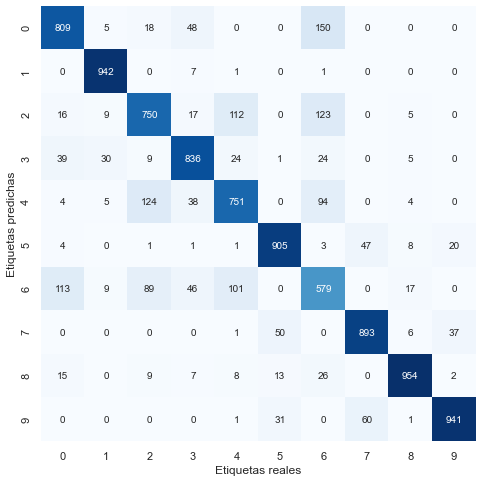

In [92]:
y_pred_test = best_model3.predict(X_test)
print('--------------------------------------------------------')
print('Reporte para el modelo sobre datos de prueba')
print(classification_report(y_test.to_numpy().argmax(axis=-1), y_pred_test))
print('--------------------------------------------------------')
plt.figure(figsize=(8,8))
mat = confusion_matrix(y_test.to_numpy().argmax(axis=-1), y_pred_test)
sns.heatmap(mat.T, square=True, annot=True, cmap='Blues',fmt='d', cbar=False)
plt.xlabel('Etiquetas reales')
plt.ylabel('Etiquetas predichas')

## Conclusiones
- Los autoencoders tienen una gran variedad de aplicaciones considerando que en el proceso de reducción de dimensionalidad son capaces de extraer las características principales de los datos de entrada al representarlos en un espacio de menor dimensión. Lo anterior posibilita, como se observó en la actividad 3, la eliminación de información dentro de los datos que no es representativa como lo es el ruido.
- Aunque la remoción de ruido fue exitosa, al omitir una gran cantidad de datos para entrenar el clasificador, se obtuvieron resultados menos favorables a causa de que en dicho proceso se pierde información relevante para poder generalizar la distribución de los datos. En este sentido, se evidencia la gran importancia de contar con la mayor cantidad de datos posibles para realizar este tipo de tareas.
- A pesar de que una red neuronal multicapa es capaz de realizar por sí misma la tarea de clasificación, se observa que al tener una etapa previa al entrenamiento de este tipo de modelos en el que los datos se representan en un mejor espacio de características, se pueden obtener mejores resultados ya que la red se debe encargar directamente de la clasificación y no de identificar los patrones en la imagen que pueden ayudarle a realizar dicha tarea.